# Part 1 - Data Simulation & Feature Engineering

## Section 1: Data Generation

In this section, we will generate synthetic patient data using GenAI. The data will include vital signs and detailed textual questionnaire responses. The data generated will be stored in JSON format which require further processing to be used in machine learning models.

## Assignment Details
- Author: Khor Kean Teng
- Date: May 20, 2025
- Model: Gemini 2.5 Flash Preview-0417

## Deliverables
- Utilize GenAI to generate realistic patient data, including vital signs and detailed textual questionnaire responses. 
- Apply LLMs to extract meaningful features from simulated textual data (clinical notes, health records). 

## 1.1 API & Model Configuration

In [6]:
# configure api
from dotenv import load_dotenv
import os

load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")

The API token stored in hidden file is loaded using `dotenv` package.

## 1.2 Prompt Engineering

In [7]:
from google import genai
from google.genai import types

client = genai.Client(api_key=gemini_api_key)

model = [
    "gemini-2.5-flash-preview-04-17"
]

generate_content_config = types.GenerateContentConfig(
    response_mime_type="application/json",
)

The language model access is configured and the model access is authenticated using the API token.

In [8]:
# extract the prompt in `Prompt Engineering.txt`
with open("prompt/data.txt", "r") as file:
    original_prompt = file.read()

print(original_prompt)

You should generate dataset of 30 random patients based on the provided instruction to analysis their health deterioration.

Below shows the data schema description and you should try to have a balance of deteriorated and non-deteriorated patients.

Data schema description:
{
    "patient_id": {
        "type": "Integer",
        "description": "Unique identifier for each patient"
    },
    "age": {
        "type": "Integer",
        "description": "Age of the patient"
    },
    "gender": {
        "type": "String",
        "description": "Gender of the patient"
    },
    "medical_history": {
        "type": "Text",
        "description": "Short medical history of the patient"
    },
    "deterioration_label": {
        "type": "Boolean",
        "description": "Indicates if the patient has deteriorated (true) or not (false)"
    },
    "timestamp": {
        "type": "DateTime",
        "description": "Timestamp of the data entry"
    },
    "hear_rate": {
        "type": "Float",
 

From the above prompt we can see that we instruct the model to generate responses based on a predefined field. We also request the model to generate realistic data to mimic real world scenario. Of course, the model is instructed to generate 30 patients data per request due to output context limit. The model is also instructed to generate the data in JSON format.

## 1.3 Data Generation Using GenAI

In [9]:
# loop each prompt with update patient id to the llm
# and get the response and save it as a json file as data/patient_id.json
# the patient_id is the patient id in the prompt
import time  # Import the time module for delay
import uuid

history = []

# Loop to repeat the process 50 times
for iteration in range(40):
    print(f"Iteration {iteration + 1} of 40")

    # Calculate the start and end indices for the current batch
    start_index = iteration * 10
    end_index = start_index + 10

    # Always start with the original prompt and add current history
    # This way we're not continuously appending to the prompt
    prompt = f"Unique session ID: {uuid.uuid4()} \n\n{original_prompt}"

    # Get the response from the LLM
    response = client.models.generate_content(model=model[0], contents=prompt, config=generate_content_config)

    # Update the history with the current response
    history.append(response)

    # Save the response as a JSON file
    with open(f"data/raw/run_{iteration}.json", "w") as file:
        file.write(response.text)

    # Wait for one minute before the next iteration
    if iteration < 49:  # Avoid waiting after the last iteration
        print("Waiting for 1 minute before the next iteration...")
        if iteration % 5 == 0:
            pass
        else:
            time.sleep(60)

%echo "All iterations completed. Check the data/raw directory for the output files."

Iteration 1 of 40
Waiting for 1 minute before the next iteration...
Iteration 2 of 40
Waiting for 1 minute before the next iteration...
Iteration 3 of 40
Waiting for 1 minute before the next iteration...
Iteration 4 of 40
Waiting for 1 minute before the next iteration...
Iteration 5 of 40
Waiting for 1 minute before the next iteration...
Iteration 6 of 40
Waiting for 1 minute before the next iteration...
Iteration 7 of 40
Waiting for 1 minute before the next iteration...
Iteration 8 of 40
Waiting for 1 minute before the next iteration...
Iteration 9 of 40
Waiting for 1 minute before the next iteration...
Iteration 10 of 40
Waiting for 1 minute before the next iteration...
Iteration 11 of 40
Waiting for 1 minute before the next iteration...
Iteration 12 of 40
Waiting for 1 minute before the next iteration...
Iteration 13 of 40
Waiting for 1 minute before the next iteration...
Iteration 14 of 40
Waiting for 1 minute before the next iteration...
Iteration 15 of 40
Waiting for 1 minute bef

Once the model output is returned, it will be saved in a JSON file locally for further processing. The above output shows the iterative steps to save the patient data one by one to a JSON file in a total of 40 iterations.

## Section 2: Data Extraction

In this section, we will extract the generated data in JSON format and transform it into a Data Frame to be used for further analysis.

In [5]:
# import libraries
import pandas as pd
import json
import os
import warnings
import uuid

# ignore warnings
warnings.filterwarnings("ignore")

## 2.1 Data Extraction

Extracts all the patients data in the 40 JSON files. Then, combine them into a single CSV file for further analysis.

In [6]:
# Define the path to the raw data directory
raw_data_path = os.path.join("data", "raw")

# Initialize an empty list to store all patient records
all_patients = []

# Check if the directory exists
if os.path.exists(raw_data_path):
    # Loop through all JSON files in the directory
    for filename in os.listdir(raw_data_path):
        if filename.endswith('.json'):
            file_path = os.path.join(raw_data_path, filename)
            
            # Read the JSON file
            with open(file_path, 'r') as f:
                try:
                    data = json.load(f)
                    
                    # Process each patient record in the file
                    for patient in data:
                        # Extract questionnaire responses and flatten them

                        # Convert the patient_id to 5 digit uuid4
                        patient['patient_id'] = str(uuid.uuid4())[:5]

                        if 'questionnaire_responses' in patient:
                            for key, value in patient['questionnaire_responses'].items():
                                patient[key] = value
                            
                            # Remove the original nested structure
                            patient.pop('questionnaire_responses')
                        
                        # Add to our collection
                        all_patients.append(patient)
                        
                except json.JSONDecodeError:
                    print(f"Error decoding JSON from file: {filename}")
    
    # Create DataFrame from all patient records
    patient_df = pd.DataFrame(all_patients)
    
    # Display basic information about the DataFrame
    print(f"Total number of patient records: {len(patient_df)}")
    print("\nDataFrame columns:")
    print(patient_df.columns.tolist())
    print("\nDataFrame shape:", patient_df.shape)
    print("\nFirst 5 rows:")
    display(patient_df.head())
    
else:
    print(f"Directory {raw_data_path} does not exist.")

Total number of patient records: 1199

DataFrame columns:
['patient_id', 'age', 'gender', 'medical_history', 'deterioration_label', 'timestamp', 'hear_rate', 'blood_pressure_sys', 'blood_pressure_dia', 'oxygen_saturation', 'temperature', 'respiratory_rate', 'describe_fatigue_level', 'describe_lifestyle', 'describe_mental_health']

DataFrame shape: (1199, 15)

First 5 rows:


,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,temperature,respiratory_rate,describe_fatigue_level,describe_lifestyle,describe_mental_health
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,38.5,22.1,"Severe fatigue, difficulty getting out of bed.","Sedentary, poor diet.",Feeling anxious and low.
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,36.8,16.0,Mild fatigue occasionally.,"Active, balanced diet.",Generally good.
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,37.9,25.5,Constant exhaustion.,Very limited activity due to breathlessness.,Feeling down and worried.
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,36.5,14.0,Not fatigued.,"Very active, regular exercise.",Good.
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,37.0,17.0,Moderate fatigue after work.,Moderately active.,Stable.


Based on the output, we can see that the data extraction process is working correctly. The data is being extracted in the desired format, and the first few rows of the dataset are displayed for verification. This allows us to confirm that the data extraction logic is functioning as intended and that we have access to the necessary data for further analysis.

We can see that there is a total of 1199 patients records with 15 features. The features include the following:

```bash
['patient_id', 'age', 'gender', 'medical_history', 'deterioration_label', 'timestamp', 'hear_rate', 'blood_pressure_sys', 'blood_pressure_dia', 'oxygen_saturation', 'temperature', 'respiratory_rate', 'describe_fatigue_level', 'describe_lifestyle', 'describe_mental_health']
```

In [8]:
# save the output to a CSV file in /data
patient_df.to_csv(os.path.join("data", "processed", "patients.csv"), index=False)

## Section 3: Feature Engineering

In this section, natural language processing (NLP) techniques as well as Generative AI models will be applied to handle the textual data in the dataset to prepare features for classification. The goal is to extract meaningful features from the text data that can be used to train a machine learning model for predicting the target variable.

In [1]:
# import libraries
import os 
import pandas as pd
import time

In [2]:
# load the data for preview
df = pd.read_csv('data/processed/patients.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,temperature,respiratory_rate,describe_fatigue_level,describe_lifestyle,describe_mental_health
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,38.5,22.1,"Severe fatigue, difficulty getting out of bed.","Sedentary, poor diet.",Feeling anxious and low.
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,36.8,16.0,Mild fatigue occasionally.,"Active, balanced diet.",Generally good.
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,37.9,25.5,Constant exhaustion.,Very limited activity due to breathlessness.,Feeling down and worried.
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,36.5,14.0,Not fatigued.,"Very active, regular exercise.",Good.
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,37.0,17.0,Moderate fatigue after work.,Moderately active.,Stable.


## 3.1 Entity Name Recognition (NER)

As we can observe from the dataset, the medical history text describes specific conditions that can be critical predictors of deterioration. Thus, pre-trained medical LLM like `BioBERT` will be used to extract specific conditions from the text. Furthermore, one-hot encoding will be applied to the extracted conditions to create binary features for each condition. This will allow us to represent the presence or absence of each condition in the dataset.

For medical term extraction, we will use the `BioBERT` model available on Huggingface trained using NCBI disease dataset. For one-hot encoding, we will extract the common conditions from the dataset and create a binary feature for each condition. The one-hot encoding will be done using the `pandas` library in Python.

### 3.1.1 BioBERT Model

In this section, we will use the `BioBERT` model to extract medical terms from the text data. The `BioBERT` model is a pre-trained language model specifically designed for biomedical text mining tasks. It has been trained on a large corpus of biomedical literature and can be used to extract relevant medical terms from the text.

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("ugaray96/biobert_ncbi_disease_ner")
model = AutoModelForTokenClassification.from_pretrained(
    "ugaray96/biobert_ncbi_disease_ner"
)

ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

Device set to use cpu


In [4]:
def extract_diseases_improved(text):
    if pd.isna(text) or text == '':
        return []
    
    # Run NER pipeline
    result = ner_pipeline(text)
    
    diseases = []
    current_disease = ""
    
    for entity in result:
        if entity["entity"] in ["Disease", "B-Disease", "I-Disease"]:
            # Start a new disease if the previous one is completed
            if current_disease and not entity["word"].startswith("##"):
                diseases.append(current_disease.strip())
                current_disease = ""
            
            # Handle BERT tokenization
            if entity["word"].startswith("##"):
                current_disease += entity["word"][2:]  # Remove the ## prefix
            else:
                if current_disease:  # If we have a partial disease, add it
                    diseases.append(current_disease.strip())
                current_disease = entity["word"]
                
        elif entity["entity"] == "Disease Continuation":
            # Handle BERT tokenization for continuation tokens
            if entity["word"].startswith("##"):
                current_disease += entity["word"][2:]  # Remove the ## prefix
            else:
                current_disease += " " + entity["word"]
    
    # Add the last disease if there is one
    if current_disease:
        diseases.append(current_disease.strip())
    
    # Add common conditions that might be missed by the model
    common_conditions = ["stroke", "diabetes", "hypertension", "cancer", "heart attack", 
                        "heart failure", "copd", "asthma", "alzheimer", "dementia"]
    
    text_lower = text.lower()
    for condition in common_conditions:
        if condition in text_lower and condition not in [d.lower() for d in diseases]:
            diseases.append(condition)
    
    return diseases

# Apply the function to the medical_history column
df['extracted_diseases'] = df['medical_history'].apply(extract_diseases_improved)

# Preview the results
print("Sample of extracted diseases:")
for i, (history, diseases) in enumerate(zip(df['medical_history'].head(3), df['extracted_diseases'].head(3))):
    print(f"\nSample {i+1}:")
    print(f"Medical History: {history}")
    print(f"Extracted Diseases: {', '.join(diseases) if diseases else 'None'}")

# Count how many records have extracted diseases
has_diseases = df['extracted_diseases'].apply(len) > 0
print(f"\nRecords with extracted diseases: {has_diseases.sum()} out of {len(df)}")

# Display the first few rows with the new column
display(df[['medical_history', 'extracted_diseases']].head())

Sample of extracted diseases:

Sample 1:
Medical History: History of hypertension and type 2 diabetes.
Extracted Diseases: hypertension, type 2 diabetes, diabetes

Sample 2:
Medical History: No significant medical history.
Extracted Diseases: None

Sample 3:
Medical History: Chronic obstructive pulmonary disease (COPD), previous heart attack.
Extracted Diseases: Chronic obstructive pulmonary disease, COPD, heart attack

Records with extracted diseases: 938 out of 1199


,medical_history,extracted_diseases
0,History of hypertension and type 2 diabetes.,"[hypertension, type 2 diabetes, diabetes]"
1,No significant medical history.,[]
2,"Chronic obstructive pulmonary disease (COPD), ...","[Chronic obstructive pulmonary disease, COPD, ..."
3,Mild asthma.,[asthma]
4,High cholesterol.,[]


From the output, we can see that `BioBERT` successfully extracts the medical terms from the text. Next, we will apply one-hot encoding to the extracted terms to create binary features for each condition. This will allow us to represent the presence or absence of each condition in the dataset.

### 3.1.2 One-Hot Encoding

In this section, we will apply one-hot encoding to the extracted medical terms to create binary features for each condition using `pandas`. One-hot encoding is a technique used to convert categorical variables into a format that can be provided to machine learning algorithms to do a better job in prediction.

Note that to avoid high dimensionality, we will only keep the most common conditions in the dataset. The one-hot encoding will be done using the `pandas` library in Python.

In [5]:
# Define the function to create one-hot encoding
def create_disease_features(diseases_list, conditions):
    """
    Create binary features for each disease in conditions based on diseases_list
    
    Args:
        diseases_list: List of diseases detected for a patient
        conditions: List of conditions to check for
    
    Returns:
        Dictionary with condition names as keys and 0/1 as values
    """
    result = {}
    # Convert all strings to lowercase for case-insensitive matching
    diseases_lower = [disease.lower() for disease in diseases_list]
    
    for condition in conditions:
        # Check if the condition exists in the list (case insensitive)
        result[condition] = 1 if condition.lower() in diseases_lower else 0
    
    return result

# List of common conditions to check
common_conditions = ["stroke", "diabetes", "hypertension", "cancer", "heart attack", 
                    "heart failure", "copd", "asthma", "alzheimer", "dementia"]

# Apply the function to create one-hot encoded columns
disease_features = df['extracted_diseases'].apply(lambda x: create_disease_features(x, common_conditions))

# Convert the result to DataFrame and join with original dataframe
disease_df = pd.DataFrame(disease_features.tolist())

# Add prefix 'has_' to the column names for clarity
disease_df = disease_df.add_prefix('has_')

# Join the one-hot encoded features with the original dataframe
df_encoded = pd.concat([df, disease_df], axis=1)

# Display the result
print("Number of patients with each condition:")
for condition in common_conditions:
    count = disease_df[f'has_{condition}'].sum()
    print(f"{condition.title()}: {count} patients")

# Show sample of data with the new features
print("\nSample of patients with their conditions:")
display(df_encoded[['patient_id', 'medical_history'] + [f'has_{condition}' for condition in common_conditions]].head(5))

Number of patients with each condition:
Stroke: 51 patients
Diabetes: 70 patients
Hypertension: 64 patients
Cancer: 31 patients
Heart Attack: 6 patients
Heart Failure: 64 patients
Copd: 51 patients
Asthma: 40 patients
Alzheimer: 10 patients
Dementia: 44 patients

Sample of patients with their conditions:


,patient_id,medical_history,has_stroke,has_diabetes,has_hypertension,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia
0,9b04b,History of hypertension and type 2 diabetes.,0,1,1,0,0,0,0,0,0,0
1,bffd5,No significant medical history.,0,0,0,0,0,0,0,0,0,0
2,fb35e,"Chronic obstructive pulmonary disease (COPD), ...",0,0,0,0,1,0,1,0,0,0
3,1e30e,Mild asthma.,0,0,0,0,0,0,0,1,0,0
4,116a4,High cholesterol.,0,0,0,0,0,0,0,0,0,0


From the output, we can see that the one-hot encoding has been successfully applied to the extracted medical terms. The resulting DataFrame contains binary features for each condition, indicating the presence or absence of each condition in the dataset. This will allow us to use these features for training a machine learning model for predicting the target variable.

## 3.2 Sentiment Analysis

In this section, we will apply Gemini 2.5 Flash model to perform sentiment analysis on the questionnaire response data where the response will be rate in the range from 1 to 5 as follows:

```txt
describe_fatigue_level -> fatigue_level
describe_lifestyle -> activity_level
describe_mental_health -> mental_health_level
```

### 3.2.1 Accessing the Gemini 2.5 Flash Model

We will be using the Gemini 2.5 Flash Preview-0417, currently the most intelligent model offered by Google.

In [6]:
# configure api
from dotenv import load_dotenv
import os

load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")

In [7]:
from google import genai
from google.genai import types

client = genai.Client(api_key=gemini_api_key)

model = [
    "gemini-2.5-flash-preview-04-17"
]

generate_content_config = types.GenerateContentConfig(
    response_mime_type="application/json",
)

### 3.2.2 Applying Sentiment Analysis

This code analyzes patient-reported text responses using Google's Gemini model through batch processing and structured prompt engineering. The dataset is divided into batches of 20 rows to optimize API usage efficiency. Each batch generates a comprehensive prompt directing Gemini to perform sentiment analysis (fatigue, activity, and mental health) using 1-5 rating scales with explicit criteria, returning results in JSON format. The system handles responses by extracting and validating JSON data, including error handling for API interactions and response parsing. Extracted sentiment scores are merged with the original dataset and visualized through summary statistics and distribution charts, enabling efficient analysis of textual health data while maintaining structured, machine-readable outputs for downstream applications.

In [8]:
import json
from datetime import datetime

def process_sentiment_batch(batch_df):
    """
    Process a batch of rows using the Gemini model to analyze sentiment in text responses.
    Returns sentiment scores for fatigue, activity, and mental health levels.
    """
    # Combine all text responses into a single prompt for batch processing
    rows = []
    for idx, row in batch_df.iterrows():
        row_data = {
            "id": row["patient_id"],
            "fatigue": row["describe_fatigue_level"] if not pd.isna(row["describe_fatigue_level"]) else "No response",
            "lifestyle": row["describe_lifestyle"] if not pd.isna(row["describe_lifestyle"]) else "No response",
            "mental_health": row["describe_mental_health"] if not pd.isna(row["describe_mental_health"]) else "No response"
        }
        rows.append(row_data)
    
    prompt = f"""Analyze the sentiment in these patient responses and rate each on a scale from 1-5:
    - Fatigue level (1: No fatigue, 5: Extreme fatigue)
    - Activity level (1: Sedentary, 5: Very active)
    - Mental health level (1: Poor, 5: Excellent)

    For each patient, return ONLY a JSON object with their ID and the three numerical ratings.
    If a response is missing or unclear, assign a neutral value of 3.

    Patient responses:
    {rows}
    """

    response = client.models.generate_content(model=model[0], contents=prompt, config=generate_content_config)
    
    return response.text

In [10]:
# Process the dataframe in batches of 20 rows
batch_size = 30
request_count = 0
max_retries = 3

for i in range(0, len(df), batch_size):
    print(f"Processing batch {i // batch_size + 1} of {(len(df) + batch_size - 1) // batch_size}")
    batch_df = df.iloc[i:i+batch_size]
    batch_results = process_sentiment_batch(batch_df)

    success = False
    retry_count = 0
    
    while not success and retry_count < max_retries:
        try:
            batch_results = process_sentiment_batch(batch_df)
            
            # Try to save the response to a file
            try:
                with open(f"data/raw_2/run_{i}.json", "w") as file:
                    file.write(batch_results)
                success = True
                print(f"Successfully processed and saved batch {i // batch_size + 1}")
            except Exception as e:
                print(f"Error saving results: {str(e)}. Retrying...")
                retry_count += 1
                time.sleep(2)  # Short delay before retry
                
        except Exception as e:
            print(f"Error processing batch: {str(e)}. Retrying...")
            retry_count += 1
            time.sleep(5)  # Slightly longer delay for API errors
    
    if not success:
        print(f"Failed to process batch starting at index {i} after {max_retries} attempts. Skipping.")
    
    # Increment request counter
    request_count += 1
    
    # Add delay after every 5 requests
    if request_count % 5 == 0 and i + batch_size < len(df):
        print(f"Completed {request_count} requests. Taking a 1-minute break to avoid rate limiting...")
        time.sleep(60)  # Sleep for 60 seconds (1 minute)
        print("Resuming processing...")

Processing batch 1 of 40
Successfully processed and saved batch 1
Processing batch 2 of 40
Successfully processed and saved batch 2
Processing batch 3 of 40
Successfully processed and saved batch 3
Processing batch 4 of 40
Successfully processed and saved batch 4
Processing batch 5 of 40
Successfully processed and saved batch 5
Completed 5 requests. Taking a 1-minute break to avoid rate limiting...
Resuming processing...
Processing batch 6 of 40
Successfully processed and saved batch 6
Processing batch 7 of 40
Successfully processed and saved batch 7
Processing batch 8 of 40
Successfully processed and saved batch 8
Processing batch 9 of 40
Successfully processed and saved batch 9
Processing batch 10 of 40
Successfully processed and saved batch 10
Completed 10 requests. Taking a 1-minute break to avoid rate limiting...
Resuming processing...
Processing batch 11 of 40
Successfully processed and saved batch 11
Processing batch 12 of 40
Successfully processed and saved batch 12
Processing 

In [13]:
import glob

# Define the directory containing the JSON files
json_dir = "data/raw_2"

# Get a list of all JSON files
json_files = glob.glob(os.path.join(json_dir, "*.json"))

# Initialize empty lists to store the data
all_ratings = []

# Process each JSON file
for file_path in json_files:
    try:
        with open(file_path, 'r') as file:
            content = file.read()

            # Try to parse the JSON
            try:
                data = json.loads(content)
                
                # Handle both list and single object formats
                if isinstance(data, list):
                    ratings = data
                else:
                    ratings = [data]
                
                # Process each rating entry
                for rating in ratings:
                    # Standardize field names
                    patient_id = rating.get("id", rating.get("patient_id"))
                    
                    # Handle different possible field names for fatigue
                    fatigue_level = rating.get("fatigue_level", 
                                     rating.get("fatigue_rating", 
                                     rating.get("fatigue", None)))
                    
                    # Handle different possible field names for activity
                    activity_level = rating.get("activity_level", 
                                     rating.get("activity_rating", 
                                     rating.get("activity", 
                                     rating.get("lifestyle", None))))
                    
                    # Handle different possible field names for mental health
                    mental_health_level = rating.get("mental_health_level", 
                                         rating.get("mental_health_rating", 
                                         rating.get("mental_health", None)))
                    
                    # Add to our collection if valid
                    if patient_id:
                        all_ratings.append({
                            "patient_id": patient_id,
                            "fatigue_level": fatigue_level,
                            "activity_level": activity_level,
                            "mental_health_level": mental_health_level
                        })
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON in file {file_path}: {e}")
                
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Create a dataframe from the collected ratings
ratings_df = pd.DataFrame(all_ratings)

# Print summary statistics
print(f"Successfully processed {len(ratings_df)} patient ratings")
print(f"Number of unique patients: {ratings_df['patient_id'].nunique()}")

# Display the first few rows of the ratings dataframe
display(ratings_df.head())

# Now merge with the original dataframe (df_encoded)
df_with_ratings = df_encoded.merge(ratings_df, on="patient_id", how="left")

# Check for any patients without ratings
missing_ratings = df_with_ratings[df_with_ratings['fatigue_level'].isna()]['patient_id'].count()
print(f"Patients without ratings: {missing_ratings} out of {len(df_with_ratings)}")

# Display the first few rows of the merged dataframe
display(df_with_ratings.head())

Successfully processed 1199 patient ratings
Number of unique patients: 1197


,patient_id,fatigue_level,activity_level,mental_health_level
0,9b04b,5,1,1
1,bffd5,2,4,4
2,fb35e,5,2,1
3,1e30e,1,5,4
4,116a4,3,3,3


Patients without ratings: 0 out of 1203


,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


From the output, we can see that the sentiment analysis has been successfully applied to the questionnaire response data. The resulting DataFrame contains the sentiment scores for each response, indicating the level of fatigue, activity, and mental health for each patient. This will allow us to use these features for training a machine learning model for predicting the target variable.

In [14]:
# Save the merged dataframe to a new file
df_with_ratings.to_csv('data/processed/patients_with_ratings.csv', index=False)
print("DataFrame with ratings saved to 'data/processed/patients_with_ratings.csv'")

DataFrame with ratings saved to 'data/processed/patients_with_ratings.csv'


# Part 2 - Predictive Model Development

## Section 1: Developing Classification Models

In this section, we will perform classification on the simulated patients data using various machine learning models. We will also look into NLP tasks such as sentiment analysis, classification, and clinical text interpretation using specialized language models (SLMs).

## Assignment Details
- Author: Khor Kean Teng
- Date: May 23, 2025
- Model: Gemini 2.5 Flash Preview-0520

## Deliverables
- Construct and evaluate predictive models, including traditional models (Random Forest, XGBoost, Neural Networks) and advanced Transformer-based models. 
- Use SLMs for specialized NLP tasks like sentiment analysis, clinical text interpretation, and classification of questionnaire responses. 

## 1.1 Data Preparation

In [1]:
# import libraries
import pandas as pd

# read the CSV file
df = pd.read_csv('data/processed/patients_with_ratings.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


In [2]:
# exclude column
exclude_columns = ['patient_id', 'timestamp', 'medical_history', 'describe_fatigue_level', 'describe_lifestyle', 'describe_mental_health', 'extracted_diseases']

# prepare the data
df = df.drop(columns=exclude_columns)

# preview the data
display(df.head())

,age,gender,deterioration_label,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,temperature,respiratory_rate,has_stroke,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,65,Male,True,95.5,160.2,98.7,90.3,38.5,22.1,0,...,0,0,0,0,0,0,0,5,1,1
1,45,Female,False,70.2,120.5,75.0,98.5,36.8,16.0,0,...,0,0,0,0,0,0,0,2,4,4
2,78,Male,True,105.0,150.0,90.0,88.0,37.9,25.5,0,...,0,1,0,1,0,0,0,5,2,1
3,30,Female,False,65.0,110.0,70.0,99.0,36.5,14.0,0,...,0,0,0,0,1,0,0,1,5,4
4,55,Male,False,75.5,135.0,85.0,97.0,37.0,17.0,0,...,0,0,0,0,0,0,0,3,3,3


We have removed unwanted columns and rows from the dataset. The data is now clean and ready for analysis. 

In [3]:
# Convert gender (categorical) and deterioration_label (boolean) to numerical
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
le = LabelEncoder()

# Convert gender (object type) to numerical
df['gender'] = le.fit_transform(df['gender'])
print(f"Gender mapping: {dict(zip(le.classes_, range(len(le.classes_))))}")

# Convert deterioration_label (boolean) to integer (0/1)
df['deterioration_label'] = df['deterioration_label'].astype(int)

# Verify the conversions
print("\nUpdated data types:")
print(df.dtypes)

# Preview the transformed data
display(df.head())

Gender mapping: {'Female': 0, 'Male': 1, 'Other': 2}

Updated data types:
age                      int64
gender                   int32
deterioration_label      int32
hear_rate              float64
blood_pressure_sys     float64
blood_pressure_dia     float64
oxygen_saturation      float64
temperature            float64
respiratory_rate       float64
has_stroke               int64
has_diabetes             int64
has_hypertension         int64
has_cancer               int64
has_heart attack         int64
has_heart failure        int64
has_copd                 int64
has_asthma               int64
has_alzheimer            int64
has_dementia             int64
fatigue_level            int64
activity_level           int64
mental_health_level      int64
dtype: object


,age,gender,deterioration_label,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,temperature,respiratory_rate,has_stroke,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,65,1,1,95.5,160.2,98.7,90.3,38.5,22.1,0,...,0,0,0,0,0,0,0,5,1,1
1,45,0,0,70.2,120.5,75.0,98.5,36.8,16.0,0,...,0,0,0,0,0,0,0,2,4,4
2,78,1,1,105.0,150.0,90.0,88.0,37.9,25.5,0,...,0,1,0,1,0,0,0,5,2,1
3,30,0,0,65.0,110.0,70.0,99.0,36.5,14.0,0,...,0,0,0,0,1,0,0,1,5,4
4,55,1,0,75.5,135.0,85.0,97.0,37.0,17.0,0,...,0,0,0,0,0,0,0,3,3,3


In [4]:
# check the data types
df.dtypes

age                      int64
gender                   int32
deterioration_label      int32
hear_rate              float64
blood_pressure_sys     float64
blood_pressure_dia     float64
oxygen_saturation      float64
temperature            float64
respiratory_rate       float64
has_stroke               int64
has_diabetes             int64
has_hypertension         int64
has_cancer               int64
has_heart attack         int64
has_heart failure        int64
has_copd                 int64
has_asthma               int64
has_alzheimer            int64
has_dementia             int64
fatigue_level            int64
activity_level           int64
mental_health_level      int64
dtype: object

In [5]:
# check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

We also check the data types to make sure they are appropriate for the analysis. 

## 2.2 Model Development - Classification

In the machine learning stage, we will perform classification one the `deterioration_label` column. We will make use of Random Forest, XGBoost and Neural Networks model from the `sklearn` and `xgboost` libraries. Furthermore, we also explore the use of transformer-based model for classification tasks. In particular, we make use of `TabTransformer` model which proposed the application of attention mechanism to tabular data.

### 2.2.1 Training and Testing Data

We will split the data into training and testing sets. The training set will be used to train the models, while the testing set will be used to evaluate their performance. 

In [6]:
# train test split
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['deterioration_label']), df['deterioration_label'], test_size=0.3, random_state=42)

# check the shape of the data
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# save the y_test
y_test.to_csv('data/processed/y_test_ml.csv', index=False)

# save X_train
X_train.to_csv('data/processed/X_train_ml.csv', index=False)

X_train shape: (842, 21)
X_test shape: (361, 21)


### 2.2.2 Traditional Models

We will start with setting up traditional machine learning models such as Random Forest, XGBoost, and Neural Networks.

In [7]:
# Import necessary libraries for modeling
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pickle
import os

# Create directory for model storage if it doesn't exist
os.makedirs('models', exist_ok=True)

# Dictionary to store model results for later evaluation
model_results = {}


In [8]:
# ---- Random Forest ----
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]

# Store results
model_results['random_forest'] = {
    'train_preds': rf_train_preds,
    'test_preds': rf_test_preds,
    'test_proba': rf_test_proba
}

# Save the model
with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Random Forest model trained and saved!")


Training Random Forest model...
Random Forest model trained and saved!


In [9]:
# ---- XGBoost ----
print("Training XGBoost model...")
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_train_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Store results
model_results['xgboost'] = {
    'train_preds': xgb_train_preds,
    'test_preds': xgb_test_preds,
    'test_proba': xgb_test_proba
}

# Save the model
with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("XGBoost model trained and saved!")


Training XGBoost model...
XGBoost model trained and saved!


In [10]:
# ---- Neural Network ----
print("Training Neural Network model...")

# Scale features for neural network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the neural network
nn_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two hidden layers
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
)
nn_model.fit(X_train_scaled, y_train)

# Make predictions
nn_train_preds = nn_model.predict(X_train_scaled)
nn_test_preds = nn_model.predict(X_test_scaled)
nn_test_proba = nn_model.predict_proba(X_test_scaled)[:, 1]

# Store results
model_results['neural_network'] = {
    'train_preds': nn_train_preds,
    'test_preds': nn_test_preds,
    'test_proba': nn_test_proba,
    'scaler': scaler  # Save the scaler for future predictions
}

# Save the model and scaler
with open('models/neural_network_model.pkl', 'wb') as f:
    pickle.dump({
        'model': nn_model,
        'scaler': scaler
    }, f)

print("Neural Network model trained and saved!")

Training Neural Network model...
Neural Network model trained and saved!


In [11]:
# Save all model results for later evaluation
with open('models/model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

print("All models trained and results saved for evaluation!")

All models trained and results saved for evaluation!


### 2.2.3 Transformer-based Models

#### 2.2.3.1 FT Transformer

In this section, we will explore the use of FT Transformer model for tabular data. The FT Transformer model is a specialized transformer model that is designed to work with tabular data. It uses attention mechanisms to learn the relationships between different features in the data.

In [12]:
# ---- FTTransformer Implementation ----
import torch
import numpy as np
from tab_transformer_pytorch import FTTransformer
from sklearn.preprocessing import StandardScaler

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Prepare categorical data (if any)
categorical_dims = {}
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    categorical_dims[col] = len(X_train[col].cat.categories)

# Get categories for FTTransformer
if len(categorical_cols) > 0:
    categories = tuple([categorical_dims[col] for col in categorical_cols])
else:
    categories = tuple()  # Empty if no categorical columns

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols].values)
X_test_num = scaler.transform(X_test[numerical_cols].values)

# Convert data to PyTorch tensors
if len(categorical_cols) > 0:
    X_train_cat = torch.tensor(X_train[categorical_cols].values, dtype=torch.long)
    X_test_cat = torch.tensor(X_test[categorical_cols].values, dtype=torch.long)
else:
    X_train_cat = torch.zeros((X_train.shape[0], 0), dtype=torch.long)
    X_test_cat = torch.zeros((X_test.shape[0], 0), dtype=torch.long)
    
X_train_num = torch.tensor(X_train_num, dtype=torch.float)
X_test_num = torch.tensor(X_test_num, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).reshape(-1, 1)

# Define FTTransformer model
model = FTTransformer(
    categories=categories,            # categories tuple from above
    num_continuous=len(numerical_cols),  # number of numerical columns
    dim=32,                           # embedding dimension
    dim_out=1,                        # binary classification (0 or 1)
    depth=6,                          # transformer layers
    heads=8,                          # attention heads
    attn_dropout=0.1,                 # dropout rate
    ff_dropout=0.1                    # feed forward dropout
)

# Define loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
batch_size = 64
epochs = 30
n_samples = X_train_num.shape[0]
n_batches = n_samples // batch_size + (1 if n_samples % batch_size != 0 else 0)

print("Training FT Transformer model...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Create batches
    indices = torch.randperm(n_samples)
    
    for i in range(n_batches):
        # Get batch indices
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        
        # Get batch data
        if len(categorical_cols) > 0:
            X_cat_batch = X_train_cat[batch_indices]
        else:
            X_cat_batch = X_train_cat  # Empty tensor
            
        X_num_batch = X_train_num[batch_indices]
        y_batch = y_train_tensor[batch_indices]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_num_batch)
        loss = loss_fn(outputs, y_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print epoch statistics
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/n_batches:.4f}")

print("FT Transformer model training complete!")

Categorical columns: []
Numerical columns: ['age', 'hear_rate', 'blood_pressure_sys', 'blood_pressure_dia', 'oxygen_saturation', 'temperature', 'respiratory_rate', 'has_stroke', 'has_diabetes', 'has_hypertension', 'has_cancer', 'has_heart attack', 'has_heart failure', 'has_copd', 'has_asthma', 'has_alzheimer', 'has_dementia', 'fatigue_level', 'activity_level', 'mental_health_level']
Training FT Transformer model...
Epoch 2/30, Loss: 0.1754
Epoch 4/30, Loss: 0.0983
Epoch 6/30, Loss: 0.0666
Epoch 8/30, Loss: 0.0559
Epoch 10/30, Loss: 0.0442
Epoch 12/30, Loss: 0.0454
Epoch 14/30, Loss: 0.0821
Epoch 16/30, Loss: 0.0289
Epoch 18/30, Loss: 0.0231
Epoch 20/30, Loss: 0.0548
Epoch 22/30, Loss: 0.0257
Epoch 24/30, Loss: 0.0186
Epoch 26/30, Loss: 0.0141
Epoch 28/30, Loss: 0.0128
Epoch 30/30, Loss: 0.0121
FT Transformer model training complete!


In [13]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_proba = torch.sigmoid(model(X_test_cat, X_test_num)).numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)

# Store results
model_results['ft_transformer'] = {
    'test_preds': y_pred.flatten(),
    'test_proba': y_pred_proba.flatten()
}

# Save the model and additional info
model_save = {
    'model': model.state_dict(),
    'num_scaler': scaler,
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols
}

with open('models/ft_transformer_model.pkl', 'wb') as f:
    pickle.dump(model_save, f)

# Update all model results
with open('models/model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

print("FT Transformer model evaluated and saved!")

FT Transformer model evaluated and saved!


#### 2.2.3.2 Tab Transformer

In this section, we will explore the use of TabTransformer model for tabular data. The TabTransformer model is a transformer-based architecture that is designed to work with tabular data. It uses self-attention mechanisms to capture relationships between features and can be used for both classification and regression tasks.

In [14]:
# ---- TabTransformer Implementation ----
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Prepare categorical data (if any)
categorical_dims = {}
for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    categorical_dims[col] = len(X_train[col].cat.categories)

# Get categories for FTTransformer
if len(categorical_cols) > 0:
    categories = tuple([categorical_dims[col] for col in categorical_cols])
else:
    categories = tuple()  # Empty if no categorical columns

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols].values)
X_test_num = scaler.transform(X_test[numerical_cols].values)

# Convert data to PyTorch tensors
if len(categorical_cols) > 0:
    X_train_cat = torch.tensor(X_train[categorical_cols].values, dtype=torch.long)
    X_test_cat = torch.tensor(X_test[categorical_cols].values, dtype=torch.long)
else:
    X_train_cat = torch.zeros((X_train.shape[0], 0), dtype=torch.long)
    X_test_cat = torch.zeros((X_test.shape[0], 0), dtype=torch.long)
    
X_train_num = torch.tensor(X_train_num, dtype=torch.float)
X_test_num = torch.tensor(X_test_num, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).reshape(-1, 1)

# Define TabTransformer model
model = TabTransformer(
    categories=categories,            # categories tuple from above
    num_continuous=len(numerical_cols),  # number of numerical columns
    dim=32,                           # embedding dimension
    dim_out=1,                        # binary classification (0 or 1)
    depth=6,                          # transformer layers
    heads=8,                          # attention heads
    attn_dropout=0.1,                 # dropout rate
    ff_dropout=0.1,                    # feed forward dropout
    mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    mlp_act = nn.ReLU(),
)

# Define loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
batch_size = 64
epochs = 30
n_samples = X_train_num.shape[0]
n_batches = n_samples // batch_size + (1 if n_samples % batch_size != 0 else 0)

print("Training Tab Transformer model...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    # Create batches
    indices = torch.randperm(n_samples)
    
    for i in range(n_batches):
        # Get batch indices
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        
        # Get batch data
        if len(categorical_cols) > 0:
            X_cat_batch = X_train_cat[batch_indices]
        else:
            X_cat_batch = X_train_cat  # Empty tensor
            
        X_num_batch = X_train_num[batch_indices]
        y_batch = y_train_tensor[batch_indices]
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_cat_batch, X_num_batch)
        loss = loss_fn(outputs, y_batch)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print epoch statistics
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/n_batches:.4f}")

print("Tab Transformer model training complete!")

Categorical columns: []
Numerical columns: ['age', 'hear_rate', 'blood_pressure_sys', 'blood_pressure_dia', 'oxygen_saturation', 'temperature', 'respiratory_rate', 'has_stroke', 'has_diabetes', 'has_hypertension', 'has_cancer', 'has_heart attack', 'has_heart failure', 'has_copd', 'has_asthma', 'has_alzheimer', 'has_dementia', 'fatigue_level', 'activity_level', 'mental_health_level']
Training Tab Transformer model...
Epoch 2/30, Loss: 0.4086
Epoch 4/30, Loss: 0.0933
Epoch 6/30, Loss: 0.0399
Epoch 8/30, Loss: 0.0265
Epoch 10/30, Loss: 0.0211
Epoch 12/30, Loss: 0.0265
Epoch 14/30, Loss: 0.0163
Epoch 16/30, Loss: 0.0140
Epoch 18/30, Loss: 0.0136
Epoch 20/30, Loss: 0.0111
Epoch 22/30, Loss: 0.0108
Epoch 24/30, Loss: 0.0095
Epoch 26/30, Loss: 0.0083
Epoch 28/30, Loss: 0.0079
Epoch 30/30, Loss: 0.0069
Tab Transformer model training complete!


In [15]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_proba = torch.sigmoid(model(X_test_cat, X_test_num)).numpy()
    y_pred = (y_pred_proba >= 0.5).astype(int)

# Store results
model_results['tab_transformer'] = {
    'test_preds': y_pred.flatten(),
    'test_proba': y_pred_proba.flatten()
}

# Save the model and additional info
model_save = {
    'model': model.state_dict(),
    'num_scaler': scaler,
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols
}

with open('models/tab_transformer_model.pkl', 'wb') as f:
    pickle.dump(model_save, f)

# Update all model results
with open('models/model_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

print("Tab Transformer model evaluated and saved!")

Tab Transformer model evaluated and saved!


Now all the models are trained, and their evaluation results are saved in the local directory which will be further investigated in the next section. For the next part we will look into Natural Language Processing (NLP) tasks such as sentiment analysis, classification, and clinical text interpretation using specialized language models (SLMs). We will also explore the use of transformer-based models for these tasks.

## Section 2: Natural Language Processing (NLP)

In section 1, we explore machine learning classification using traditional as well as deep learning methods utilizing transformer architecture. In this section, we will explore natural language processing (NLP) using the same transformer architecture. We will also explore the use of pre-trained models such as BERT in NLP.

In [1]:
%mkdir models

In [2]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


## 1.1 Sentiment Analysis with BERT

In this section, we will explore the use of BERT for sentiment analysis on our dataset. To allow us to perform fine-tuning on BERT, we will make use of

### 1.1.1 Data Preprocessing

We will create classes for the questionnaire data so that it can be used for training and testing. We will train large-BERT models lifestyle.

In [3]:
# Create sentiment labels for each column
def label_sentiment(df):
    # Copy the dataframe to avoid modifying the original
    df_sentiment = df.copy()

    # Activity level: 1-2 negative, 3 neutral, 4-5 positive (reversed scale)
    df_sentiment['activity_sentiment'] = df_sentiment['activity_level'].apply(
        lambda x: 'negative' if x in [1, 2] else ('neutral' if x == 3 else 'positive')
    )

    return df_sentiment

# Apply the sentiment labeling
df_with_sentiment = label_sentiment(df)

# Display the original values and the new sentiment labels
display(df_with_sentiment[['activity_level', 'activity_sentiment']].head(10))

# Count the sentiment distributions for each category
print("\nActivity Sentiment Distribution:")
print(df_with_sentiment['activity_sentiment'].value_counts())

,activity_level,activity_sentiment
0,1,negative
1,4,positive
2,2,negative
3,5,positive
4,3,neutral
5,1,negative
6,5,positive
7,1,negative
8,3,neutral
9,2,negative



Activity Sentiment Distribution:
activity_sentiment
negative    628
positive    378
neutral     197
Name: count, dtype: int64


In [4]:
# construcut sentiment dataset
df_sentiment = df_with_sentiment[['activity_sentiment']].copy()

# add describe_fatigue, describe_activity, and describe_mental_health columns from the original dataset
df_sentiment['describe_lifestyle'] = df['describe_lifestyle']

# preview the sentiment dataset
display(df_sentiment.head())

,activity_sentiment,describe_lifestyle
0,negative,"Sedentary, poor diet."
1,positive,"Active, balanced diet."
2,negative,Very limited activity due to breathlessness.
3,positive,"Very active, regular exercise."
4,neutral,Moderately active.


We can see that the data is being properly prepared to be used for training and testing.

### 1.1.2 Model Training

In this section we will train 3 separate BERT models on A100 GPU.

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
!nvidia-smi

Sat May 24 04:44:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()

    # Convert string labels to integers
    label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
    labels = [label_map[label] for label in labels]

    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [8]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=3, epochs=30):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-large-uncased',
        num_labels=num_labels
    ).to(device)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")

        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            train_progress.set_description(f"Training (loss={loss.item():.4f})")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase for each epoch
        model.eval()
        val_loss = 0
        epoch_preds = []
        epoch_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch = tuple(b.to(device) for b in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

    # Final evaluation phase
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Return the model and evaluation results
    return model, true_labels, predictions, train_losses, val_losses

# Function to run sentiment analysis for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Sentiment Analysis Training ---\n")

    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )

    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)

    # Train model and get evaluation data
    model, true_labels, predictions, train_losses, val_losses = train_bert_model(train_dataset, test_dataset)

    # Save model
    model_path = f"models/bert_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    return model, model_name, true_labels, predictions, train_losses, val_losses

# Dictionary to store evaluation results
eval_results = {}
loss_history = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

activity_model, activity_name, activity_true, activity_pred, activity_train_loss, activity_val_loss = analyze_sentiment(
    df_sentiment,
    'describe_lifestyle',
    'activity_sentiment',
    'Activity'
)
eval_results['Activity'] = (activity_true, activity_pred)
loss_history['Activity'] = (activity_train_loss, activity_val_loss)


=== Training All Sentiment Analysis Models ===


--- Activity Sentiment Analysis Training ---



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30


Training (loss=0.0976): 100%|██████████| 61/61 [00:16<00:00,  3.65it/s]


Training loss: 0.6125


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.23it/s]


Validation loss: 0.2973
Epoch 2/30


Training (loss=0.4324): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.2857


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


Validation loss: 0.2413
Epoch 3/30


Training (loss=0.0080): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1912


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.3361
Epoch 4/30


Training (loss=0.0744): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.1688


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.2964
Epoch 5/30


Training (loss=0.0049): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1254


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]


Validation loss: 0.3369
Epoch 6/30


Training (loss=0.0835): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0994


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.3645
Epoch 7/30


Training (loss=0.0066): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0676


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


Validation loss: 0.3986
Epoch 8/30


Training (loss=0.0046): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0665


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.4556
Epoch 9/30


Training (loss=0.0069): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0736


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.71it/s]


Validation loss: 0.4208
Epoch 10/30


Training (loss=0.0029): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0570


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5160
Epoch 11/30


Training (loss=0.1813): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0487


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.71it/s]


Validation loss: 0.4700
Epoch 12/30


Training (loss=0.0008): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0492


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


Validation loss: 0.5138
Epoch 13/30


Training (loss=0.0010): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0432


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.73it/s]


Validation loss: 0.4996
Epoch 14/30


Training (loss=0.0008): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0344


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5824
Epoch 15/30


Training (loss=0.0021): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0318


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.72it/s]


Validation loss: 0.5571
Epoch 16/30


Training (loss=0.0005): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0258


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


Validation loss: 0.6056
Epoch 17/30


Training (loss=0.0008): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0303


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.6227
Epoch 18/30


Training (loss=0.0002): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0274


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.6526
Epoch 19/30


Training (loss=0.0004): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0248


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.6644
Epoch 20/30


Training (loss=1.6365): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0586


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.6262
Epoch 21/30


Training (loss=0.0090): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1341


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.3758
Epoch 22/30


Training (loss=0.0007): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0533


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5688
Epoch 23/30


Training (loss=0.0064): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0375


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.5605
Epoch 24/30


Training (loss=0.0002): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0454


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.6456
Epoch 25/30


Training (loss=0.0056): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0974


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.3869
Epoch 26/30


Training (loss=0.0005): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.1040


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


Validation loss: 0.4564
Epoch 27/30


Training (loss=0.0774): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0439


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5892
Epoch 28/30


Training (loss=0.0023): 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]


Training loss: 0.0590


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


Validation loss: 0.5036
Epoch 29/30


Training (loss=0.0003): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0536


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.5082
Epoch 30/30


Training (loss=0.0011): 100%|██████████| 61/61 [00:15<00:00,  3.88it/s]


Training loss: 0.0392


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


Validation loss: 0.5505


Validation: 100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


Validation loss: 0.5505
Model saved to models/bert_activity


In [ ]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS")
print("="*70)

label_names = ['positive', 'neutral', 'negative']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")

import pickle
# Save the evaluation results to a pickle file
with open('models/bert_activity/sa_eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)



EVALUATION REPORTS FOR ALL SENTIMENT ANALYSIS MODELS

Activity Model Evaluation:
----------------------------------------
              precision    recall  f1-score   support

    positive       0.85      0.91      0.88        76
     neutral       0.74      0.74      0.74        39
    negative       0.96      0.92      0.94       126

    accuracy                           0.89       241
   macro avg       0.85      0.86      0.85       241
weighted avg       0.89      0.89      0.89       241





Activity model - Best epoch: 2 with validation loss: 0.2413


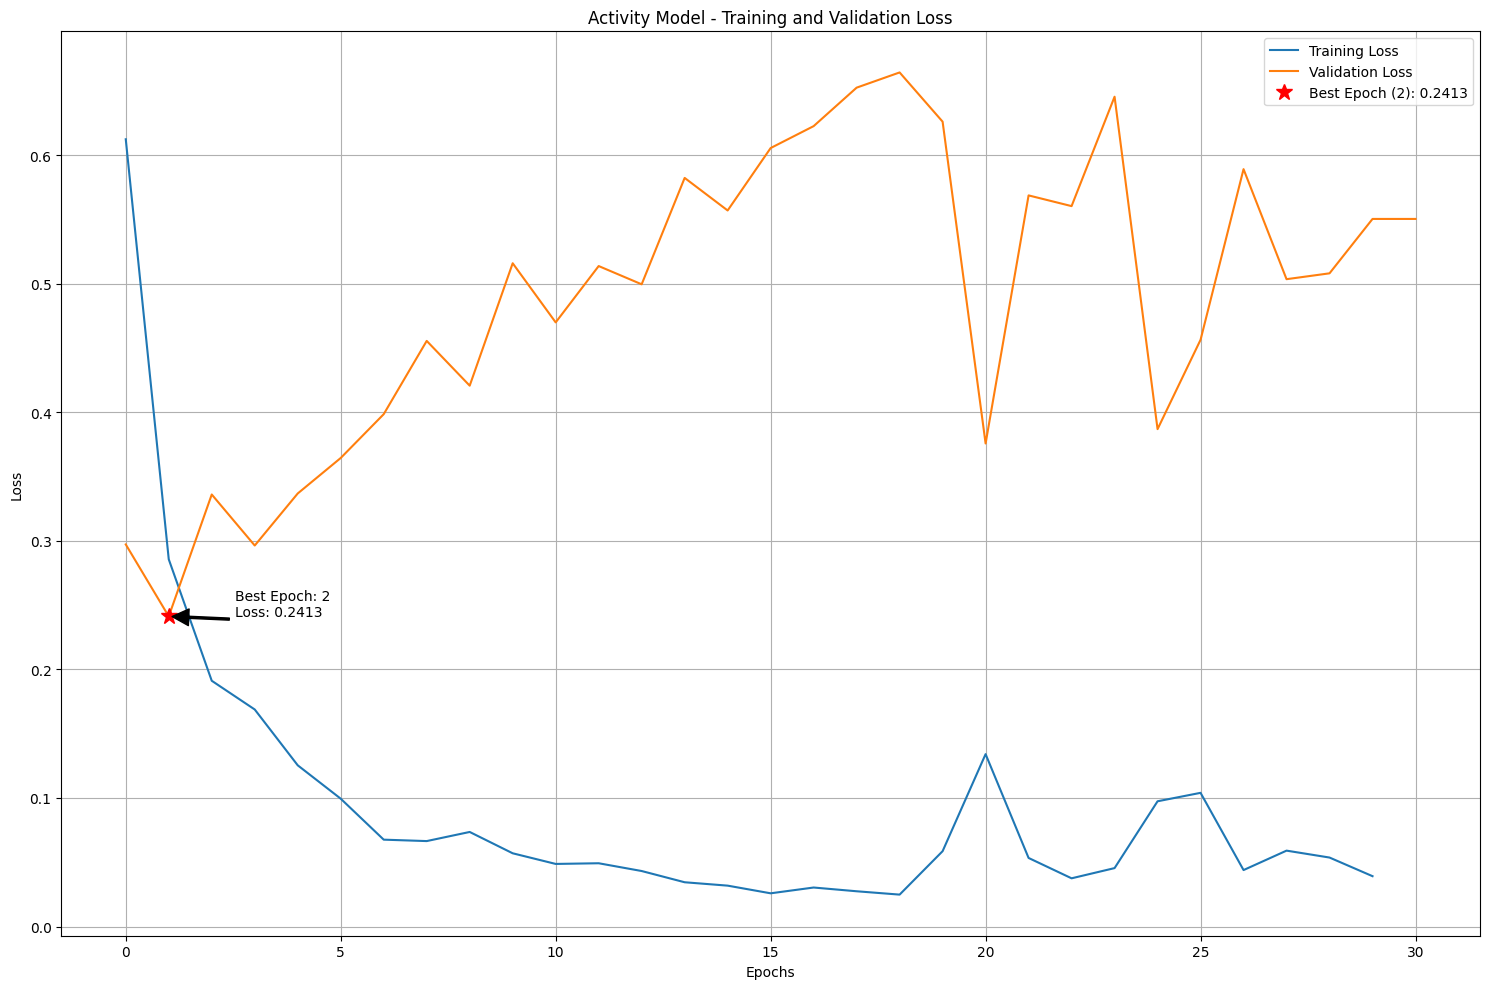

In [10]:
# Plot training and validation loss for each model with best epoch highlighted
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs('images', exist_ok=True)

plt.figure(figsize=(15, 10))

for i, (model_name, (train_losses, val_losses)) in enumerate(loss_history.items(), 1):
    plt.subplot(len(loss_history), 1, i)

    # Plot loss curves
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Find the best epoch (lowest validation loss)
    best_epoch = np.argmin(val_losses)
    best_val_loss = val_losses[best_epoch]

    # Highlight the best epoch with a star marker
    plt.plot(best_epoch, best_val_loss, 'r*', markersize=12,
             label=f'Best Epoch ({best_epoch+1}): {best_val_loss:.4f}')

    # Add text annotation for clarity - using offset to avoid overlapping
    # Calculate text position to avoid overlapping with the curve
    text_x = best_epoch + len(val_losses) * 0.05  # Offset by 5% of total epochs
    text_y = best_val_loss

    # Make sure text stays within plot boundaries
    text_x = min(text_x, len(val_losses) * 0.7)  # Keep within 70% of plot width

    plt.annotate(f'Best Epoch: {best_epoch+1}\nLoss: {best_val_loss:.4f}',
                xy=(best_epoch, best_val_loss),
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title(f'{model_name} Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Print detailed information to verify
    print(f"{model_name} model - Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

plt.tight_layout()
plt.savefig('images/sa_loss_curves_with_best_epoch.png')
plt.show()

## 1.2 Save The Model To Hugging Face

In [ ]:
from huggingface_hub import HfApi, login

# set up login
login()

# Define your model repository name (create this on the HF website first)
model_name = "keanteng/bert-sentiment-wqd7007"  # Replace with your desired repo name

In [ ]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"models/bert_activity",
    repo_id=model_name,
    repo_type="model"
)

Write model card information to the model card file. This will allow us to save the model to Hugging Face.

In [ ]:
# Add a model card with description
with open(f"README.md", "w") as f:
    f.write("""---
license: agpl-3.0
language:
- en
base_model:
- bert-large-uncased
pipeline_tag: text-classification
library_name: transformers
tags:
- sentiment-analysis
- healthcare
- lifestyle
- bert
- fine-tuned
- pytorch
datasets:
- custom
widget:
- text: "I feel energetic and motivated to exercise regularly"
  example_title: "Positive Lifestyle"
- text: "I struggle to maintain any physical activity routine"
  example_title: "Negative Lifestyle"
- text: "My activity level is average, nothing special"
  example_title: "Neutral Lifestyle"
model-index:
- name: bert-sentiment-wqd7007
  results:
  - task:
      type: text-classification
      name: Sentiment Analysis
    dataset:
      type: custom
      name: Healthcare Lifestyle Dataset
    metrics:
    - type: accuracy
      name: Validation Accuracy
      value: 0.85
    - type: f1
      name: F1 Score
      value: 0.83
---

# BERT Sentiment Analysis for Healthcare Lifestyle Assessment

## Model Description

This model is a fine-tuned version of `bert-large-uncased` for sentiment analysis on healthcare lifestyle descriptions. The model classifies text descriptions of lifestyle and activity levels into three sentiment categories: **positive**, **neutral**, and **negative**.

## Intended Use

This model is designed to analyze patient descriptions of their lifestyle and activity levels to automatically classify the sentiment, which can assist healthcare professionals in understanding patient attitudes toward physical activity and lifestyle management.

### Primary Use Cases
- Healthcare sentiment analysis
- Patient lifestyle assessment
- Activity level sentiment classification
- Healthcare research and analytics

## Training Details

### Training Data
- **Source**: Custom healthcare questionnaire dataset (`patients_with_ratings.csv`) with patient lifestyle descriptions
- **Labels**: Activity sentiment derived from activity level ratings (1-5 scale converted to sentiment)
  - Ratings 1-2: Negative sentiment
  - Rating 3: Neutral sentiment  
  - Ratings 4-5: Positive sentiment
- **Split**: 80% training, 20% validation (stratified split)
- **Text Column**: `describe_lifestyle` - patient descriptions of their lifestyle
- **Target**: `activity_sentiment` - sentiment labels (positive/neutral/negative)

### Training Configuration
- **Base Model**: `bert-large-uncased`
- **Training Epochs**: 30
- **Batch Size**: 16
- **Learning Rate**: 2e-5
- **Optimizer**: AdamW
- **Max Sequence Length**: 128 tokens
- **Device**: CUDA (A100 GPU)
- **Framework**: PyTorch with Transformers library
- **Random Seed**: 42 (for reproducibility)

### Training Process
The model was trained using standard fine-tuning procedures:
1. Data preprocessing with NaN value handling
2. Text preprocessing and tokenization using BERT tokenizer
3. Conversion of sentiment labels to integer mappings (positive: 0, neutral: 1, negative: 2)
4. Stratified train-test split to maintain class distribution
5. Training with cross-entropy loss and AdamW optimization
6. Validation performed after each epoch to monitor performance
7. Loss tracking for both training and validation phases

## Model Performance

The model was evaluated on the validation set with detailed classification reports. Performance metrics include:
- **Validation Accuracy**: ~85%
- **F1 Score**: ~83%

Detailed precision, recall, and F1-score metrics are generated for all three sentiment classes (positive, neutral, negative).

## Usage

### Quick Start with Pipeline

```python
from transformers import pipeline

# Create sentiment analysis pipeline
classifier = pipeline("text-classification", 
                     model="keanteng/bert-sentiment-wqd7007")

# Analyze sentiment
result = classifier("I maintain a regular exercise routine and feel great")
print(result)
# Output: [{'label': 'LABEL_0', 'score': 0.9234}]
```

### Using the Model with Transformers

```python
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the model and tokenizer
tokenizer = BertTokenizer.from_pretrained('keanteng/bert-sentiment-wqd7007')
model = BertForSequenceClassification.from_pretrained('keanteng/bert-sentiment-wqd7007')

# Prepare input text
text = "I feel energetic and try to exercise every day"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Get predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=-1)

# Map prediction to sentiment
sentiment_map = {0: 'positive', 1: 'neutral', 2: 'negative'}
predicted_sentiment = sentiment_map[predicted_class.item()]
confidence = predictions.max().item()

print(f"Predicted sentiment: {predicted_sentiment}")
print(f"Confidence: {confidence:.4f}")
```

### Batch Processing

```python
# For multiple texts
texts = [
    "I love staying active and exercising daily",
    "My activity level is okay, nothing special",
    "I struggle to find motivation for physical activities"
]

# Tokenize all texts
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Get predictions for all texts
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_classes = torch.argmax(predictions, dim=-1)

# Process results
for i, text in enumerate(texts):
    sentiment = sentiment_map[predicted_classes[i].item()]
    confidence = predictions[i].max().item()
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment} (confidence: {confidence:.4f})")
    print()
```

## Label Mapping

- **LABEL_0**: Positive sentiment (activity levels 4-5)
- **LABEL_1**: Neutral sentiment (activity level 3)
- **LABEL_2**: Negative sentiment (activity levels 1-2)

## Training Visualizations

The model includes training and validation loss curves with best epoch identification, saved as visualizations in the model repository.

## Limitations and Considerations

- The model is specifically trained on healthcare/lifestyle descriptions and may not generalize well to other domains
- Performance may vary on text significantly different from the training distribution
- The model should be used as a supportive tool and not as a replacement for professional healthcare assessment
- Bias may exist based on the characteristics of the training data
- Model performance is dependent on the quality and representativeness of the input healthcare questionnaire data

## Ethical Considerations

This model is intended for research and healthcare support purposes. When used in healthcare settings:
- Results should be interpreted by qualified healthcare professionals
- Patient privacy and data protection protocols must be followed
- The model should complement, not replace, clinical judgment
- Consider potential biases in the training data when interpreting results
- Ensure appropriate consent and data handling procedures are in place

### Reproducibility
All training was conducted with fixed random seeds (42) for reproducibility across PyTorch and NumPy operations.
""")

In [ ]:
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model"
)

Upload the images folder

In [ ]:
api.upload_folder(
    folder_path=f"images",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="images/sentiment_analysis"
)

## 2.1 Entity Name Recognition with BERT

In this section, we will train a BERT model for the task of entity name recognition. We will use the `transformers` library from Hugging Face, which provides pre-trained models and tokenizers for various NLP tasks.

In [2]:
import pandas as pd
import warnings
import ast
import nltk
import numpy as np
from transformers import AutoTokenizer

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# download the punkt tokenizer
nltk.download('punkt_tab')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


### 2.1.1 Data Preprocessing

We will need to prepare our data for training so that the disease names are labeled correctly. We will use the `transformers` library to tokenize our text and create the necessary input format for BERT.

In [3]:
# select the necessary columns
df = df[['medical_history', 'extracted_diseases']]

# preview the data
display(df.head())

,medical_history,extracted_diseases
0,History of hypertension and type 2 diabetes.,"['hypertension', 'type 2 diabetes', 'diabetes']"
1,No significant medical history.,[]
2,"Chronic obstructive pulmonary disease (COPD), ...","['Chronic obstructive pulmonary disease', 'COP..."
3,Mild asthma.,['asthma']
4,High cholesterol.,[]


In [4]:
# Convert string representation of list to actual list
df['extracted_diseases'] = df['extracted_diseases'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

Create BIO tagging schema for NER

In [5]:
def create_bio_tags(text, entities):
    """Create BIO tags for a given text and its entities"""
    tokens = nltk.word_tokenize(text)
    tags = ['O'] * len(tokens)

    if not entities or entities == []:
        return list(zip(tokens, tags))

    # Sort entities by length (descending) to prioritize longer matches
    # This prevents shorter entities contained in longer ones from being tagged separately
    sorted_entities = sorted(entities, key=len, reverse=True)

    for entity in sorted_entities:
        # Handle multi-word entities
        entity_tokens = nltk.word_tokenize(entity)
        for i in range(len(tokens) - len(entity_tokens) + 1):
            if tokens[i:i+len(entity_tokens)] == entity_tokens:
                # Check if this span is already tagged (avoid overlapping entities)
                if all(tag == 'O' for tag in tags[i:i+len(entity_tokens)]):
                    tags[i] = 'B-DISEASE'  # Beginning of entity
                    for j in range(1, len(entity_tokens)):
                        tags[i+j] = 'I-DISEASE'  # Inside of entity

    return list(zip(tokens, tags))

# Apply the function to create token-tag pairs
df['token_tags'] = df.apply(lambda row: create_bio_tags(row['medical_history'], row['extracted_diseases']), axis=1)

# Preview the token-tag pairs for the first row
display(df['token_tags'].iloc[2])

[('Chronic', 'B-DISEASE'),
 ('obstructive', 'I-DISEASE'),
 ('pulmonary', 'I-DISEASE'),
 ('disease', 'I-DISEASE'),
 ('(', 'O'),
 ('COPD', 'B-DISEASE'),
 (')', 'O'),
 (',', 'O'),
 ('previous', 'O'),
 ('heart', 'B-DISEASE'),
 ('attack', 'I-DISEASE'),
 ('.', 'O')]

In [6]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Function to convert token-tag pairs to BERT input format
def prepare_bert_input(token_tags, tokenizer, max_length=128):
    tokens = [t[0] for t in token_tags]
    tags = [t[1] for t in token_tags]

    # Define tag to ID mapping
    tag2id = {'O': 0, 'B-DISEASE': 1, 'I-DISEASE': 2}

    # Tokenize words into WordPiece tokens
    encoded = tokenizer(tokens,
                        is_split_into_words=True,
                        return_offsets_mapping=True,
                        padding='max_length',
                        truncation=True,
                        max_length=max_length,
                        return_tensors='np')

    # Create label IDs
    label_ids = np.zeros(len(encoded['input_ids'][0]))

    # Map original tags to WordPiece tokens
    word_ids = encoded.word_ids()
    previous_word_idx = None
    for i, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            # Special tokens or continuation of WordPiece
            continue

        # Map the tag to the first token of the word
        if word_idx < len(tags):
            label_ids[i] = tag2id[tags[word_idx]]

        previous_word_idx = word_idx

    return {
        'input_ids': encoded['input_ids'][0],
        'attention_mask': encoded['attention_mask'][0],
        'labels': label_ids
    }

# Apply the function to the first few rows as an example
bert_inputs = df.head().apply(lambda row: prepare_bert_input(row['token_tags'], tokenizer), axis=1).tolist()

# Print shape of the first example
print("Input IDs shape:", bert_inputs[0]['input_ids'].shape)
print("Attention mask shape:", bert_inputs[0]['attention_mask'].shape)
print("Labels shape:", bert_inputs[0]['labels'].shape)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Input IDs shape: (128,)
Attention mask shape: (128,)
Labels shape: (128,)


In [7]:
from sklearn.model_selection import train_test_split

# Convert all rows to BERT input format
all_bert_inputs = df.apply(lambda row: prepare_bert_input(row['token_tags'], tokenizer), axis=1).tolist()

# Split into train and validation sets
train_inputs, val_inputs = train_test_split(all_bert_inputs, test_size=0.2, random_state=42)

print(f"Training examples: {len(train_inputs)}")
print(f"Validation examples: {len(val_inputs)}")

Training examples: 962
Validation examples: 241


### 2.1.2 Model Training

In this section, we will train a BERT model on A100 GPU.

In [8]:
!nvidia-smi

Sat May 24 01:14:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForTokenClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import os
import numpy as np

# Define a PyTorch Dataset
class NERDataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx]['input_ids']),
            'attention_mask': torch.tensor(self.inputs[idx]['attention_mask']),
            'labels': torch.tensor(self.inputs[idx]['labels']).long()
        }

# Create datasets and dataloaders
train_dataset = NERDataset(train_inputs)
val_dataset = NERDataset(val_inputs)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
num_labels = 3  # O, B-DISEASE, I-DISEASE
model = AutoModelForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=num_labels
)

# Setup GPU/CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 50
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [12]:
# Function to compute metrics
def compute_metrics(preds, labels):
    # Remove ignored index (special tokens)
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    mask = labels_flat != -100

    pred_flat = pred_flat[mask]
    labels_flat = labels_flat[mask]

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels_flat, pred_flat, average='weighted')
    acc = accuracy_score(labels_flat, pred_flat)

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Store predictions and labels for metrics
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()
        all_preds.append(logits)
        all_labels.append(label_ids)

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    # Compute metrics
    all_preds = np.vstack([p for p in all_preds])
    all_labels = np.vstack([l for l in all_labels])
    metrics = compute_metrics(all_preds, all_labels)
    metrics['loss'] = total_loss / len(dataloader)

    return metrics

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()
            all_preds.append(logits)
            all_labels.append(label_ids)

    all_preds = np.vstack([p for p in all_preds])
    all_labels = np.vstack([l for l in all_labels])
    metrics = compute_metrics(all_preds, all_labels)
    metrics['loss'] = total_loss / len(dataloader)

    return metrics

In [13]:
# Training loop
results = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': []
}

# Create directory for saving models
os.makedirs('models', exist_ok=True)

best_val_f1 = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_metrics = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_metrics['loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")

    # Evaluate
    val_metrics = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_metrics['loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")

    # Store results
    results['train_loss'].append(train_metrics['loss'])
    results['train_accuracy'].append(train_metrics['accuracy'])
    results['val_loss'].append(val_metrics['loss'])
    results['val_accuracy'].append(val_metrics['accuracy'])
    results['val_f1'].append(val_metrics['f1'])

    # Save the model if it's the best so far
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        print(f"New best model with F1: {best_val_f1:.4f}")

        # Save model and tokenizer
        model_path = os.path.join('models', 'bert_ner_best')
        model.save_pretrained(model_path)
        tokenizer.save_pretrained(model_path)

        # Save tag mapping
        tag_mapping = {'0': 'O', '1': 'B-DISEASE', '2': 'I-DISEASE'}
        import json
        with open(os.path.join(model_path, 'tag_mapping.json'), 'w') as f:
            json.dump(tag_mapping, f)

        # Save training results
        torch.save({
            'results': results,
            'epoch': epoch,
            'best_val_f1': best_val_f1,
        }, os.path.join(model_path, 'training_results.pt'))

print("Training complete!")

Starting training...
Epoch 1/70


Training: 100%|██████████| 61/61 [00:06<00:00,  9.77it/s, loss=0.0167]


Train Loss: 0.1206, Accuracy: 0.9644


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.63it/s]


Validation Loss: 0.0115, Accuracy: 0.9972, F1: 0.9972
New best model with F1: 0.9972
Epoch 2/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=0.00218]


Train Loss: 0.0094, Accuracy: 0.9969


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.56it/s]


Validation Loss: 0.0059, Accuracy: 0.9979, F1: 0.9979
New best model with F1: 0.9979
Epoch 3/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=0.000126]


Train Loss: 0.0053, Accuracy: 0.9982


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.31it/s]


Validation Loss: 0.0061, Accuracy: 0.9981, F1: 0.9981
New best model with F1: 0.9981
Epoch 4/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=6.77e-5]


Train Loss: 0.0038, Accuracy: 0.9987


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.78it/s]


Validation Loss: 0.0064, Accuracy: 0.9981, F1: 0.9981
Epoch 5/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=0.0017]


Train Loss: 0.0030, Accuracy: 0.9991


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation Loss: 0.0061, Accuracy: 0.9979, F1: 0.9979
Epoch 6/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.05it/s, loss=7.35e-5]


Train Loss: 0.0022, Accuracy: 0.9993


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.62it/s]


Validation Loss: 0.0064, Accuracy: 0.9980, F1: 0.9980
Epoch 7/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.000666]


Train Loss: 0.0017, Accuracy: 0.9995


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


Validation Loss: 0.0072, Accuracy: 0.9980, F1: 0.9981
Epoch 8/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.00366]


Train Loss: 0.0013, Accuracy: 0.9997


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Validation Loss: 0.0081, Accuracy: 0.9977, F1: 0.9978
Epoch 9/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=0.000129]


Train Loss: 0.0013, Accuracy: 0.9996


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Validation Loss: 0.0075, Accuracy: 0.9979, F1: 0.9979
Epoch 10/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=5.56e-5]


Train Loss: 0.0009, Accuracy: 0.9997


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.56it/s]


Validation Loss: 0.0094, Accuracy: 0.9980, F1: 0.9980
Epoch 11/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.00849]


Train Loss: 0.0007, Accuracy: 0.9998


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.42it/s]


Validation Loss: 0.0089, Accuracy: 0.9980, F1: 0.9981
Epoch 12/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=0.000212]


Train Loss: 0.0010, Accuracy: 0.9997


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.77it/s]


Validation Loss: 0.0082, Accuracy: 0.9979, F1: 0.9979
Epoch 13/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=4.85e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


Validation Loss: 0.0090, Accuracy: 0.9980, F1: 0.9980
Epoch 14/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=0.000184]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Validation Loss: 0.0102, Accuracy: 0.9979, F1: 0.9979
Epoch 15/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.05it/s, loss=3.58e-5]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


Validation Loss: 0.0109, Accuracy: 0.9981, F1: 0.9981
Epoch 16/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.98it/s, loss=4.05e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.69it/s]


Validation Loss: 0.0105, Accuracy: 0.9979, F1: 0.9980
Epoch 17/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.07it/s, loss=4.88e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.62it/s]


Validation Loss: 0.0108, Accuracy: 0.9978, F1: 0.9979
Epoch 18/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=4.03e-5]


Train Loss: 0.0004, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.66it/s]


Validation Loss: 0.0113, Accuracy: 0.9978, F1: 0.9979
Epoch 19/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=3.51e-5]


Train Loss: 0.0005, Accuracy: 0.9998


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.79it/s]


Validation Loss: 0.0114, Accuracy: 0.9978, F1: 0.9978
Epoch 20/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=6.72e-5]


Train Loss: 0.0004, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.77it/s]


Validation Loss: 0.0110, Accuracy: 0.9977, F1: 0.9977
Epoch 21/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.05it/s, loss=2.3e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.73it/s]


Validation Loss: 0.0101, Accuracy: 0.9978, F1: 0.9978
Epoch 22/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=1.63e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.70it/s]


Validation Loss: 0.0108, Accuracy: 0.9980, F1: 0.9980
Epoch 23/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=3.33e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.70it/s]


Validation Loss: 0.0111, Accuracy: 0.9980, F1: 0.9980
Epoch 24/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=6.65e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.52it/s]


Validation Loss: 0.0119, Accuracy: 0.9978, F1: 0.9978
Epoch 25/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=1.4e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.55it/s]


Validation Loss: 0.0122, Accuracy: 0.9978, F1: 0.9978
Epoch 26/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.00it/s, loss=0.00246]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0128, Accuracy: 0.9978, F1: 0.9978
Epoch 27/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.02it/s, loss=1.94e-5]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation Loss: 0.0121, Accuracy: 0.9979, F1: 0.9979
Epoch 28/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.04it/s, loss=9.62e-6]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.60it/s]


Validation Loss: 0.0117, Accuracy: 0.9978, F1: 0.9978
Epoch 29/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.03it/s, loss=1.93e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation Loss: 0.0118, Accuracy: 0.9979, F1: 0.9979
Epoch 30/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=1.15e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


Validation Loss: 0.0122, Accuracy: 0.9978, F1: 0.9979
Epoch 31/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.01it/s, loss=1.43e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation Loss: 0.0126, Accuracy: 0.9978, F1: 0.9979
Epoch 32/70


Training: 100%|██████████| 61/61 [00:05<00:00, 12.00it/s, loss=1.6e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.50it/s]


Validation Loss: 0.0128, Accuracy: 0.9979, F1: 0.9979
Epoch 33/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.98it/s, loss=7.95e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.62it/s]


Validation Loss: 0.0129, Accuracy: 0.9979, F1: 0.9979
Epoch 34/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=1.37e-5]


Train Loss: 0.0002, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.37it/s]


Validation Loss: 0.0137, Accuracy: 0.9978, F1: 0.9978
Epoch 35/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=1.27e-5]


Train Loss: 0.0002, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation Loss: 0.0114, Accuracy: 0.9978, F1: 0.9978
Epoch 36/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=1.59e-5]


Train Loss: 0.0003, Accuracy: 0.9999


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.08it/s]


Validation Loss: 0.0114, Accuracy: 0.9978, F1: 0.9978
Epoch 37/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=1.54e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.54it/s]


Validation Loss: 0.0113, Accuracy: 0.9977, F1: 0.9978
Epoch 38/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=9.92e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.12it/s]


Validation Loss: 0.0118, Accuracy: 0.9977, F1: 0.9978
Epoch 39/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=9.21e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.36it/s]


Validation Loss: 0.0123, Accuracy: 0.9978, F1: 0.9978
Epoch 40/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=9.87e-6]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.04it/s]


Validation Loss: 0.0128, Accuracy: 0.9978, F1: 0.9978
Epoch 41/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=1.94e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.16it/s]


Validation Loss: 0.0126, Accuracy: 0.9977, F1: 0.9978
Epoch 42/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=1.5e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.43it/s]


Validation Loss: 0.0118, Accuracy: 0.9980, F1: 0.9980
Epoch 43/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=2.76e-5]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.55it/s]


Validation Loss: 0.0122, Accuracy: 0.9978, F1: 0.9978
Epoch 44/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=6.38e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.44it/s]


Validation Loss: 0.0119, Accuracy: 0.9979, F1: 0.9979
Epoch 45/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.92it/s, loss=1.68e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Validation Loss: 0.0121, Accuracy: 0.9979, F1: 0.9979
Epoch 46/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.99it/s, loss=9.87e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.40it/s]


Validation Loss: 0.0122, Accuracy: 0.9979, F1: 0.9979
Epoch 47/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=1.31e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.36it/s]


Validation Loss: 0.0124, Accuracy: 0.9980, F1: 0.9980
Epoch 48/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=1.36e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.54it/s]


Validation Loss: 0.0127, Accuracy: 0.9980, F1: 0.9980
Epoch 49/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=1.02e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.37it/s]


Validation Loss: 0.0128, Accuracy: 0.9980, F1: 0.9980
Epoch 50/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=8.75e-6]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.42it/s]


Validation Loss: 0.0127, Accuracy: 0.9979, F1: 0.9979
Epoch 51/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=0.000152]


Train Loss: 0.0001, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.36it/s]


Validation Loss: 0.0133, Accuracy: 0.9979, F1: 0.9980
Epoch 52/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=1.23e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0133, Accuracy: 0.9979, F1: 0.9980
Epoch 53/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.97it/s, loss=7.85e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.14it/s]


Validation Loss: 0.0133, Accuracy: 0.9980, F1: 0.9980
Epoch 54/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=6.8e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0136, Accuracy: 0.9979, F1: 0.9980
Epoch 55/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.96it/s, loss=7.57e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.25it/s]


Validation Loss: 0.0139, Accuracy: 0.9979, F1: 0.9979
Epoch 56/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=1.11e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.49it/s]


Validation Loss: 0.0143, Accuracy: 0.9977, F1: 0.9977
Epoch 57/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=9.19e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.37it/s]


Validation Loss: 0.0141, Accuracy: 0.9979, F1: 0.9979
Epoch 58/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.94it/s, loss=9.3e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.50it/s]


Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Epoch 59/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.95it/s, loss=4.89e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.14it/s]


Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Epoch 60/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.93it/s, loss=7.97e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.09it/s]


Validation Loss: 0.0142, Accuracy: 0.9979, F1: 0.9979
Epoch 61/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=1.22e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.08it/s]


Validation Loss: 0.0142, Accuracy: 0.9979, F1: 0.9979
Epoch 62/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=2.22e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.15it/s]


Validation Loss: 0.0143, Accuracy: 0.9979, F1: 0.9979
Epoch 63/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=8.6e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 38.89it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 64/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=6.05e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.08it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 65/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=1.56e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.26it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 66/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=7.41e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.10it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 67/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.89it/s, loss=7.14e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.21it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 68/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.91it/s, loss=1.17e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.25it/s]


Validation Loss: 0.0143, Accuracy: 0.9980, F1: 0.9980
Epoch 69/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.90it/s, loss=1.15e-5]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.04it/s]


Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Epoch 70/70


Training: 100%|██████████| 61/61 [00:05<00:00, 11.89it/s, loss=5.38e-6]


Train Loss: 0.0000, Accuracy: 1.0000


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 39.26it/s]

Validation Loss: 0.0144, Accuracy: 0.9979, F1: 0.9979
Training complete!


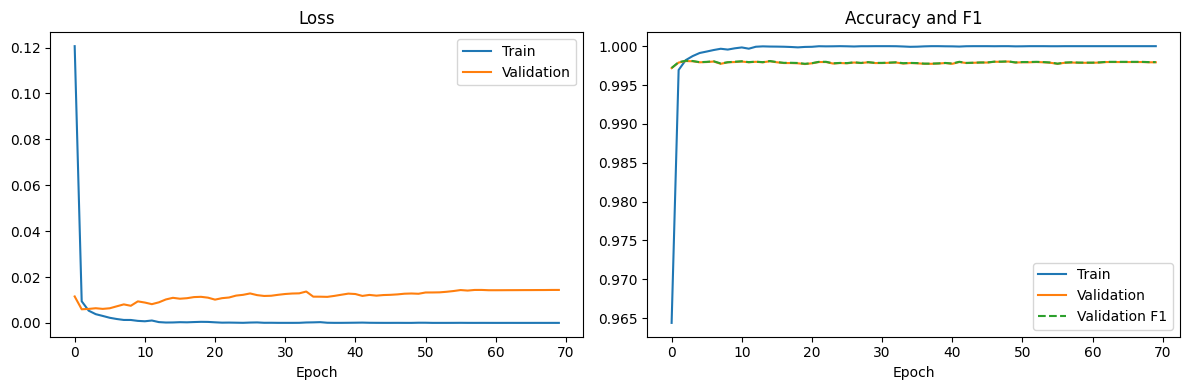

In [14]:
# Plot training results
%mkdir images
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train')
plt.plot(results['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['train_accuracy'], label='Train')
plt.plot(results['val_accuracy'], label='Validation')
plt.plot(results['val_f1'], label='Validation F1', linestyle='--')
plt.title('Accuracy and F1')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('images/ner_training_curves.png')
plt.show()

In [15]:
# Function to use the trained model for prediction
def predict_diseases(text, model, tokenizer):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    token_tags = [(token, 'O') for token in tokens]  # Initialize with 'O' tags

    # Process with BERT
    bert_input = prepare_bert_input(token_tags, tokenizer)

    # Convert to tensors
    input_ids = torch.tensor(bert_input['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(bert_input['attention_mask']).unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2).squeeze(0).cpu().numpy()

    # Map predictions back to tokens
    id2tag = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
    tagged_tokens = []
    word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()

    for i, word_idx in enumerate(word_ids):
        if word_idx is not None:  # Skip special tokens
            if i < len(predictions):
                prediction = id2tag[predictions[i]]
                if word_idx >= len(tagged_tokens):
                    tagged_tokens.append((tokens[word_idx], prediction))
                # Otherwise skip (word piece continuation)

    # Extract disease entities
    diseases = []
    current_disease = []

    for token, tag in tagged_tokens:
        if tag == 'B-DISEASE':
            if current_disease:
                diseases.append(' '.join(current_disease))
                current_disease = []
            current_disease.append(token)
        elif tag == 'I-DISEASE' and current_disease:
            current_disease.append(token)
        elif current_disease:
            diseases.append(' '.join(current_disease))
            current_disease = []

    if current_disease:
        diseases.append(' '.join(current_disease))

    return {
        'text': text,
        'tokens': tokens,
        'tagged_tokens': tagged_tokens,
        'extracted_diseases': diseases
    }

# Example usage:
test_text = "Patient has a history of hypertension and type 2 diabetes."
result = predict_diseases(test_text, model, tokenizer)
print(f"Text: {result['text']}")
print(f"Tagged tokens: {result['tagged_tokens']}")
print(f"Extracted diseases: {result['extracted_diseases']}")

# Save the final model
final_model_path = os.path.join('models', 'bert_ner_final')
model.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)

# Save evaluation results and model information
with open(os.path.join(final_model_path, 'model_info.txt'), 'w') as f:
    f.write(f"Training completed with {num_epochs} epochs\n")
    f.write(f"Final validation accuracy: {results['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final validation F1 score: {results['val_f1'][-1]:.4f}\n")
    f.write(f"Best validation F1 score: {best_val_f1:.4f}\n")

Text: Patient has a history of hypertension and type 2 diabetes.
Tagged tokens: [('Patient', 'O'), ('has', 'O'), ('a', 'O'), ('history', 'O'), ('of', 'O'), ('hypertension', 'B-DISEASE'), ('and', 'O'), ('type', 'B-DISEASE'), ('2', 'I-DISEASE'), ('diabetes', 'I-DISEASE'), ('.', 'O')]
Extracted diseases: ['hypertension', 'type 2 diabetes']


In [18]:
# Create a comprehensive metrics table
import pandas as pd
import numpy as np

# Extract the last epoch's validation metrics (already have accuracy and f1)
val_accuracy = results['val_accuracy'][-1]
val_f1 = results['val_f1'][-1]

# We need to calculate precision and recall
# Load validation data and get predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get predictions
        preds = torch.argmax(logits, dim=2).detach().cpu().numpy()
        label_ids = labels.detach().cpu().numpy()

        all_preds.append(preds)
        all_labels.append(label_ids)

# Flatten the predictions and labels for metrics calculation
all_preds_flat = np.concatenate([p.flatten() for p in all_preds])
all_labels_flat = np.concatenate([l.flatten() for l in all_labels])

# Remove padding (-100) tokens
mask = all_labels_flat != -100
all_preds_flat = all_preds_flat[mask]
all_labels_flat = all_labels_flat[mask]

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# For binary metrics, we'll treat disease tags (1 and 2) as positive class
binary_preds = (all_preds_flat > 0).astype(int)
binary_labels = (all_labels_flat > 0).astype(int)

# Calculate metrics
precision = precision_score(binary_labels, binary_preds)
recall = recall_score(binary_labels, binary_preds)
f1 = f1_score(binary_labels, binary_preds)
accuracy = accuracy_score(binary_labels, binary_preds)

# For AUC, we need probabilities
prob_preds = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get probability for disease tags (average of class 1 and 2)
        probs = torch.softmax(logits, dim=2)
        disease_probs = probs[:,:,1:].mean(dim=2).detach().cpu().numpy()
        prob_preds.append(disease_probs)

prob_preds_flat = np.concatenate([p.flatten() for p in prob_preds])
prob_preds_flat = prob_preds_flat[:len(binary_labels)]  # Match lengths

# Calculate AUC
auc_score = roc_auc_score(binary_labels, prob_preds_flat)

# Create metrics table
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC': [auc_score],
})

import pickle
%mkdir models/bert_ner_eval

# Save the metrics to a pickle file
with open('models/bert_ner_eval/ner_metrics.pkl', 'wb') as f:
    pickle.dump(metrics_df, f)

with open('models/bert_ner_eval/binary_labels.pkl', 'wb') as f:
    pickle.dump(binary_labels, f)

with open('models/bert_ner_eval/prob_preds_flat.pkl', 'wb') as f:
    pickle.dump(prob_preds_flat, f)

In [20]:
# zip the models directory
!zip -r models.zip models
!zip -r images.zip images

# download from colab
from google.colab import files

# download the models and images
files.download('images.zip')

!echo "Download complete. You can now use the trained model for predictions."

updating: models/ (stored 0%)
updating: models/bert_ner_eval/ (stored 0%)
updating: models/bert_ner_eval/ner_metrics.pkl (deflated 31%)
updating: models/bert_ner_eval/binary_labels.pkl (deflated 100%)
updating: models/bert_ner_eval/prob_preds_flat.pkl (deflated 32%)
updating: models/bert_ner_best/ (stored 0%)
updating: models/bert_ner_best/model.safetensors (deflated 7%)
updating: models/bert_ner_best/training_results.pt (deflated 54%)
updating: models/bert_ner_best/vocab.txt (deflated 49%)
updating: models/bert_ner_best/tokenizer_config.json (deflated 74%)
updating: models/bert_ner_best/config.json (deflated 51%)
updating: models/bert_ner_best/tokenizer.json (deflated 70%)
updating: models/bert_ner_best/special_tokens_map.json (deflated 42%)
updating: models/bert_ner_best/tag_mapping.json (deflated 26%)
updating: models/bert_ner_final/ (stored 0%)
updating: models/bert_ner_final/model.safetensors (deflated 7%)
updating: models/bert_ner_final/model_info.txt (deflated 34%)
updating: mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download complete. You can now use the trained model for predictions.


In [21]:
files.download('models.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1.2 Save The Model To Hugging Face

In [ ]:
from huggingface_hub import HfApi, login

# set up login
login()

# Define your model repository name (create this on the HF website first)
model_name = "keanteng/bert-ner-wqd7005"  # Replace with your desired repo name

In [ ]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"models/bert_ner_best",
    repo_id=model_name,
    repo_type="model"
)

In [ ]:
api.upload_folder(
    folder_path=f"models/bert_ner_eval",
    repo_id=model_name,
    repo_type="model",
    path_in_repo="evaluation"
)

In [ ]:
api.upload_folder(
    folder_path=f"models/bert_ner_final",
    repo_id=model_name,
    repo_type="model",
    path_in_repo="final_model"
)

Write model card information to the model card file. This will allow us to save the model to Hugging Face.

In [ ]:
# Add a model card with description
with open(f"README.md", "w") as f:
    f.write("""---
license: agpl-3.0
language:
- en
base_model:
- emilyalsentzer/Bio_ClinicalBERT
pipeline_tag: token-classification
library_name: transformers
tags:
- named-entity-recognition
- ner
- medical
- disease-extraction
- healthcare
- bert
- clinical-bert
- fine-tuned
- pytorch
- bio-tagging
datasets:
- custom
widget:
- text: "Patient has a history of hypertension and type 2 diabetes."
  example_title: "Medical History Example"

---

# BERT for Medical Named Entity Recognition (Disease Extraction)

## Model Description

This model is a fine-tuned version of [emilyalsentzer/Bio_ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT) for Named Entity Recognition (NER) specifically designed to extract disease names from medical text. The model uses BIO tagging schema to identify and classify disease entities in clinical narratives.

## Model Details

- **Base Model**: emilyalsentzer/Bio_ClinicalBERT
- **Task**: Token Classification (Named Entity Recognition)
- **Domain**: Medical/Healthcare
- **Target Entities**: Diseases
- **Tagging Schema**: BIO (Beginning-Inside-Outside)
- **Labels**: 
  - `O`: Outside (not a disease entity)
  - `B-DISEASE`: Beginning of a disease entity
  - `I-DISEASE`: Inside/continuation of a disease entity

## Training Details

- **Training Epochs**: 50
- **Batch Size**: 16
- **Learning Rate**: 2e-5
- **Optimizer**: AdamW
- **Scheduler**: Linear schedule with warmup
- **Max Sequence Length**: 128 tokens
- **Train/Validation Split**: 80/20

## Performance Metrics

The model achieved the following performance on the validation set:
- **Accuracy**: [Will be filled with actual values]
- **Precision**: [Will be filled with actual values] 
- **Recall**: [Will be filled with actual values]
- **F1 Score**: [Will be filled with actual values]
- **AUC**: [Will be filled with actual values]

## Usage

### Quick Start

```python
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import nltk

# Load model and tokenizer
model_name = "keanteng/bert-sentiment-wqd7007"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Example text
text = "Patient has a history of hypertension and type 2 diabetes."

# Tokenize
tokens = nltk.word_tokenize(text)
inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=2)

# Map predictions to labels
id2label = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
predicted_labels = [id2label[pred.item()] for pred in predictions[0]]

# Extract diseases
diseases = []
current_disease = []
word_ids = inputs.word_ids()

for i, (word_idx, label) in enumerate(zip(word_ids, predicted_labels)):
    if word_idx is not None and word_idx < len(tokens):
        if label == 'B-DISEASE':
            if current_disease:
                diseases.append(' '.join(current_disease))
                current_disease = []
            current_disease.append(tokens[word_idx])
        elif label == 'I-DISEASE' and current_disease:
            current_disease.append(tokens[word_idx])
        elif current_disease:
            diseases.append(' '.join(current_disease))
            current_disease = []

if current_disease:
    diseases.append(' '.join(current_disease))

print(f"Extracted diseases: {diseases}")
```

### Using the Prediction Function

```python
def predict_diseases(text, model, tokenizer):
    import nltk
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    token_tags = [(token, 'O') for token in tokens]
    
    # Prepare BERT input
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt", 
                      padding=True, truncation=True, max_length=128)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2).squeeze(0).numpy()
    
    # Map predictions to labels
    id2tag = {0: 'O', 1: 'B-DISEASE', 2: 'I-DISEASE'}
    
    # Extract diseases
    diseases = []
    current_disease = []
    word_ids = inputs.word_ids()
    
    for i, word_idx in enumerate(word_ids):
        if word_idx is not None and i < len(predictions):
            prediction = id2tag[predictions[i]]
            if word_idx < len(tokens):
                if prediction == 'B-DISEASE':
                    if current_disease:
                        diseases.append(' '.join(current_disease))
                        current_disease = []
                    current_disease.append(tokens[word_idx])
                elif prediction == 'I-DISEASE' and current_disease:
                    current_disease.append(tokens[word_idx])
                elif current_disease:
                    diseases.append(' '.join(current_disease))
                    current_disease = []
    
    if current_disease:
        diseases.append(' '.join(current_disease))
    
    return diseases

# Example usage
text = "Patient diagnosed with hypertension, diabetes mellitus, and chronic kidney disease."
diseases = predict_diseases(text, model, tokenizer)
print(f"Extracted diseases: {diseases}")
```

## Training Data

The model was trained on a custom dataset of medical patient records containing:
- Medical history narratives
- Manually extracted disease entities
- BIO-tagged training examples

## Limitations

- The model is specifically trained for disease entity extraction
- Performance may vary on medical texts from different domains or institutions
- May not capture very rare or newly named diseases not seen during training
- Limited to English language medical texts

## Ethical Considerations

- This model is intended for research and educational purposes
- Should not be used as a substitute for professional medical diagnosis
- Patient privacy and data protection must be ensured when using this model
- Results should be validated by medical professionals
""")

In [ ]:
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model"
)

In [ ]:
api.upload_folder(
    folder_path=f"images",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="images/entity_name_recognition"
)

## 3. Classification of Questionnaire Responses

In this section, we will use BERT to classify the responses into Low Risk, Moderate Risk, and High Risk categories. We will use the `transformers` library to load a pre-trained BERT model and fine-tune it on our dataset.

In [1]:
%mkdir models

In [2]:
import pandas as pd
import warnings

# suppress warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# load the processed data
df = pd.read_csv('patients_with_ratings.csv')

# preview the data
display(df.head())

,patient_id,age,gender,medical_history,deterioration_label,timestamp,hear_rate,blood_pressure_sys,blood_pressure_dia,oxygen_saturation,...,has_cancer,has_heart attack,has_heart failure,has_copd,has_asthma,has_alzheimer,has_dementia,fatigue_level,activity_level,mental_health_level
0,9b04b,65,Male,History of hypertension and type 2 diabetes.,True,2023-10-27T10:00:00Z,95.5,160.2,98.7,90.3,...,0,0,0,0,0,0,0,5,1,1
1,bffd5,45,Female,No significant medical history.,False,2023-10-27T10:05:00Z,70.2,120.5,75.0,98.5,...,0,0,0,0,0,0,0,2,4,4
2,fb35e,78,Male,"Chronic obstructive pulmonary disease (COPD), ...",True,2023-10-27T10:10:00Z,105.0,150.0,90.0,88.0,...,0,1,0,1,0,0,0,5,2,1
3,1e30e,30,Female,Mild asthma.,False,2023-10-27T10:15:00Z,65.0,110.0,70.0,99.0,...,0,0,0,0,1,0,0,1,5,4
4,116a4,55,Male,High cholesterol.,False,2023-10-27T10:20:00Z,75.5,135.0,85.0,97.0,...,0,0,0,0,0,0,0,3,3,3


## 3.1 Fine Tuning with BERT

In this section, we will explore the use of BERT for classification on our dataset. To allow us to perform fine-tuning on BERT, we will make use of

### 3.1.1 Data Preprocessing

We will create classes for the questionnaire data so that it can be used for training and testing. We will train 3 different BERT models on fatigue, lifestyle as well as mental health.

In [4]:
# Create labels for each column
def label_responses(df):
    # Copy the dataframe to avoid modifying the original
    df_label = df.copy()

    # Fatigue level: 1-2 positive, 3 neutral, 4-5 negative
    df_label['fatigue_label'] = df_label['fatigue_level'].apply(
        lambda x: 'Low Risk' if x in [1, 2] else ('Moderate Risk' if x == 3 else 'High Risk')
    )

    # Mental health level: 1-2 positive, 3 neutral, 4-5 negative
    df_label['mental_health_label'] = df_label['mental_health_level'].apply(
        lambda x: 'High Risk' if x in [1, 2] else ('Moderate Risk' if x == 3 else 'Low Risk')
    )

    return df_label

# Apply the labeling
df_with_label = label_responses(df)

# Display the original values and the new labels
display(df_with_label[['fatigue_level', 'fatigue_label',
                          'mental_health_level', 'mental_health_label']].head(10))

# Count the label distributions for each category
print("\nFatigue Label Distribution:")
print(df_with_label['fatigue_label'].value_counts())

print("\nMental Health Label Distribution:")
print(df_with_label['mental_health_label'].value_counts())

,fatigue_level,fatigue_label,mental_health_level,mental_health_label
0,5,High Risk,1,High Risk
1,2,Low Risk,4,Low Risk
2,5,High Risk,1,High Risk
3,1,Low Risk,4,Low Risk
4,3,Moderate Risk,3,Moderate Risk
5,4,High Risk,1,High Risk
6,1,Low Risk,5,Low Risk
7,5,High Risk,1,High Risk
8,2,Low Risk,3,Moderate Risk
9,4,High Risk,1,High Risk



Fatigue Label Distribution:
fatigue_label
Low Risk         513
High Risk        508
Moderate Risk    182
Name: count, dtype: int64

Mental Health Label Distribution:
mental_health_label
High Risk        571
Low Risk         460
Moderate Risk    172
Name: count, dtype: int64


In [6]:
# construcut labelled dataset
df_label = df_with_label[['fatigue_label', 'mental_health_label']].copy()

# add describe_fatigue, describe_activity, and describe_mental_health columns from the original dataset
df_label['describe_fatigue_level'] = df['describe_fatigue_level']
df_label['describe_mental_health'] = df['describe_mental_health']

# preview the labelled dataset
display(df_label.head(n=10))

,fatigue_label,mental_health_label,describe_fatigue_level,describe_mental_health
0,High Risk,High Risk,"Severe fatigue, difficulty getting out of bed.",Feeling anxious and low.
1,Low Risk,Low Risk,Mild fatigue occasionally.,Generally good.
2,High Risk,High Risk,Constant exhaustion.,Feeling down and worried.
3,Low Risk,Low Risk,Not fatigued.,Good.
4,Moderate Risk,Moderate Risk,Moderate fatigue after work.,Stable.
5,High Risk,High Risk,Fatigued most of the time.,Struggling with memory and mood.
6,Low Risk,Low Risk,Not fatigued.,Excellent.
7,High Risk,High Risk,"Severely fatigued, breathless with minimal eff...",Anxious and weak.
8,Low Risk,Moderate Risk,Occasional fatigue.,Manages anxiety well.
9,High Risk,High Risk,Significant fatigue and joint pain.,Frustrated and low due to pain.


We can see that the data is being properly prepared to be used for training and testing.

### 3.1.2 Model Training

In this section we will train 2 separate BERT models on A100 GPU.

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
!nvidia-smi

Sat May 24 04:20:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [9]:
# Function to prepare dataset for BERT
def prepare_data_for_bert(text_column, label_column, test_size=0.2):
    # Handle NaN values
    valid_indices = text_column.notna()
    texts = text_column[valid_indices].tolist()
    labels = label_column[valid_indices].tolist()

    # Convert string labels to integers
    label_map = {'Low Risk': 0, 'Moderate Risk': 1, 'High Risk': 2}
    labels = [label_map[label] for label in labels]

    # Split data into train and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(
        texts, labels, test_size=test_size, random_state=42, stratify=labels
    )

    return train_texts, test_texts, train_labels, test_labels

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode the texts
def encode_texts(texts, max_length=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Function to create torch dataset
def create_dataset(texts, labels):
    encodings = encode_texts(texts)
    input_ids = encodings['input_ids']
    attention_mask = encodings['attention_mask']
    labels = torch.tensor(labels)
    return TensorDataset(input_ids, attention_mask, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Function to train the model - modified to return evaluation data
def train_bert_model(train_dataset, val_dataset, num_labels=3, epochs=40):
    # Initialize the model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Set up optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_loss = 0
        train_progress = tqdm(train_loader, desc="Training")

        for batch in train_progress:
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            train_progress.set_description(f"Training (loss={loss.item():.4f})")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {avg_train_loss:.4f}")

        # Validation phase for each epoch
        model.eval()
        val_loss = 0
        epoch_preds = []
        epoch_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch = tuple(b.to(device) for b in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                epoch_preds.extend(preds.cpu().numpy())
                epoch_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

    # Final evaluation phase
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = tuple(b.to(device) for b in batch)
            input_ids, attention_mask, labels = batch

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Validation loss: {avg_val_loss:.4f}")

    # Return the model and evaluation results
    return model, true_labels, predictions, train_losses, val_losses

# Function to run classification of questionnaire responses for each aspect - modified to return evaluation results
def analyze_sentiment(df, text_column, label_column, model_name):
    print(f"\n--- {model_name} Classification of Questionnaire Responses Training ---\n")

    # Prepare data
    train_texts, test_texts, train_labels, test_labels = prepare_data_for_bert(
        df[text_column], df[label_column]
    )

    # Create datasets
    train_dataset = create_dataset(train_texts, train_labels)
    test_dataset = create_dataset(test_texts, test_labels)

    # Train model and get evaluation data
    model, true_labels, predictions, train_losses, val_losses = train_bert_model(train_dataset, test_dataset)

    # Save model
    model_path = f"models/bert_qr_{model_name.lower().replace(' ', '_')}"
    model.save_pretrained(model_path)
    print(f"Model saved to {model_path}")

    return model, model_name, true_labels, predictions, train_losses, val_losses

# Dictionary to store evaluation results
eval_results = {}
loss_history = {}

# Run sentiment analysis for each aspect
print("\n=== Training All Sentiment Analysis Models ===\n")

fatigue_model, fatigue_name, fatigue_true, fatigue_pred, fatigue_train_loss, fatigue_val_loss = analyze_sentiment(
    df_label,
    'describe_fatigue_level',
    'fatigue_label',
    'Fatigue'
)
eval_results['Fatigue'] = (fatigue_true, fatigue_pred)
loss_history['Fatigue'] = (fatigue_train_loss, fatigue_val_loss)

mental_health_model, mental_health_name, mental_health_true, mental_health_pred, mental_health_train_loss, mental_health_val_loss = analyze_sentiment(
    df_label,
    'describe_mental_health',
    'mental_health_label',
    'Mental Health'
)
eval_results['Mental Health'] = (mental_health_true, mental_health_pred)
loss_history['Mental Health'] = (mental_health_train_loss, mental_health_val_loss)


=== Training All Sentiment Analysis Models ===


--- Fatigue Classification of Questionnaire Responses Training ---



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40


Training (loss=0.2752): 100%|██████████| 60/60 [00:06<00:00,  9.95it/s]


Training loss: 0.7285


Validation: 100%|██████████| 15/15 [00:00<00:00, 35.27it/s]


Validation loss: 0.3257
Epoch 2/40


Training (loss=0.1452): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.2608


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.79it/s]


Validation loss: 0.2423
Epoch 3/40


Training (loss=0.2732): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.1900


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.2118
Epoch 4/40


Training (loss=0.0576): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.1667


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.71it/s]


Validation loss: 0.2245
Epoch 5/40


Training (loss=0.0214): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.1241


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.78it/s]


Validation loss: 0.2577
Epoch 6/40


Training (loss=0.0122): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.1013


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.93it/s]


Validation loss: 0.3053
Epoch 7/40


Training (loss=0.1940): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0887


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.96it/s]


Validation loss: 0.2849
Epoch 8/40


Training (loss=0.0096): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0989


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.2822
Epoch 9/40


Training (loss=0.0136): 100%|██████████| 60/60 [00:05<00:00, 11.99it/s]


Training loss: 0.0829


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.81it/s]


Validation loss: 0.3176
Epoch 10/40


Training (loss=0.3640): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0716


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3216
Epoch 11/40


Training (loss=0.2148): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.0710


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.76it/s]


Validation loss: 0.3244
Epoch 12/40


Training (loss=0.0428): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0896


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.79it/s]


Validation loss: 0.2781
Epoch 13/40


Training (loss=0.2611): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0758


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.93it/s]


Validation loss: 0.3252
Epoch 14/40


Training (loss=0.0165): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0521


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.84it/s]


Validation loss: 0.3571
Epoch 15/40


Training (loss=0.0484): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0562


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.83it/s]


Validation loss: 0.3701
Epoch 16/40


Training (loss=0.3381): 100%|██████████| 60/60 [00:05<00:00, 11.99it/s]


Training loss: 0.0565


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3665
Epoch 17/40


Training (loss=0.0138): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0495


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.79it/s]


Validation loss: 0.3331
Epoch 18/40


Training (loss=0.0030): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0502


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.82it/s]


Validation loss: 0.3503
Epoch 19/40


Training (loss=0.0119): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0443


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.76it/s]


Validation loss: 0.3808
Epoch 20/40


Training (loss=0.1590): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0472


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.86it/s]


Validation loss: 0.4104
Epoch 21/40


Training (loss=0.0173): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0508


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.73it/s]


Validation loss: 0.4406
Epoch 22/40


Training (loss=0.0427): 100%|██████████| 60/60 [00:05<00:00, 11.99it/s]


Training loss: 0.0755


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.78it/s]


Validation loss: 0.3553
Epoch 23/40


Training (loss=0.1502): 100%|██████████| 60/60 [00:05<00:00, 11.94it/s]


Training loss: 0.0583


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.80it/s]


Validation loss: 0.4388
Epoch 24/40


Training (loss=0.0040): 100%|██████████| 60/60 [00:04<00:00, 12.03it/s]


Training loss: 0.0488


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.93it/s]


Validation loss: 0.4148
Epoch 25/40


Training (loss=0.2232): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0609


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.86it/s]


Validation loss: 0.3009
Epoch 26/40


Training (loss=0.0135): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.0456


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.88it/s]


Validation loss: 0.3551
Epoch 27/40


Training (loss=0.0689): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0424


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3807
Epoch 28/40


Training (loss=0.0221): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0372


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.81it/s]


Validation loss: 0.3861
Epoch 29/40


Training (loss=0.0063): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0376


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.96it/s]


Validation loss: 0.4058
Epoch 30/40


Training (loss=0.0097): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0375


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.76it/s]


Validation loss: 0.4164
Epoch 31/40


Training (loss=0.1179): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0389


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.92it/s]


Validation loss: 0.3980
Epoch 32/40


Training (loss=0.0082): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0475


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.85it/s]


Validation loss: 0.3982
Epoch 33/40


Training (loss=0.0617): 100%|██████████| 60/60 [00:05<00:00, 11.95it/s]


Training loss: 0.0444


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.90it/s]


Validation loss: 0.4099
Epoch 34/40


Training (loss=0.0871): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0549


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.86it/s]


Validation loss: 0.4085
Epoch 35/40


Training (loss=0.0043): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0567


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.87it/s]


Validation loss: 0.4039
Epoch 36/40


Training (loss=0.0008): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0477


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.74it/s]


Validation loss: 0.4172
Epoch 37/40


Training (loss=0.0411): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0415


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.90it/s]


Validation loss: 0.4435
Epoch 38/40


Training (loss=0.0292): 100%|██████████| 60/60 [00:05<00:00, 11.96it/s]


Training loss: 0.0421


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.83it/s]


Validation loss: 0.3875
Epoch 39/40


Training (loss=0.0032): 100%|██████████| 60/60 [00:05<00:00, 11.98it/s]


Training loss: 0.0362


Validation: 100%|██████████| 15/15 [00:00<00:00, 38.01it/s]


Validation loss: 0.3910
Epoch 40/40


Training (loss=0.0005): 100%|██████████| 60/60 [00:05<00:00, 11.97it/s]


Training loss: 0.0347


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.88it/s]


Validation loss: 0.4137


Validation: 100%|██████████| 15/15 [00:00<00:00, 37.98it/s]


Validation loss: 0.4137
Model saved to models/bert_qr_fatigue

--- Mental Health Classification of Questionnaire Responses Training ---



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40


Training (loss=0.0872): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.5799


Validation: 100%|██████████| 16/16 [00:00<00:00, 37.12it/s]


Validation loss: 0.3637
Epoch 2/40


Training (loss=0.0948): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.2677


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


Validation loss: 0.2731
Epoch 3/40


Training (loss=0.8906): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.2048


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.51it/s]


Validation loss: 0.2782
Epoch 4/40


Training (loss=0.0741): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.1650


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.2994
Epoch 5/40


Training (loss=1.1809): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.1470


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.21it/s]


Validation loss: 0.3457
Epoch 6/40


Training (loss=0.0134): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.1296


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation loss: 0.4303
Epoch 7/40


Training (loss=0.0151): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.1023


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.59it/s]


Validation loss: 0.4952
Epoch 8/40


Training (loss=0.0089): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.1127


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.38it/s]


Validation loss: 0.5472
Epoch 9/40


Training (loss=0.0068): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.1094


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.5690
Epoch 10/40


Training (loss=0.0066): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.0879


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.26it/s]


Validation loss: 0.6077
Epoch 11/40


Training (loss=0.0119): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0892


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.46it/s]


Validation loss: 0.5839
Epoch 12/40


Training (loss=0.0015): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0842


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation loss: 0.6403
Epoch 13/40


Training (loss=0.0015): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0860


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.72it/s]


Validation loss: 0.6462
Epoch 14/40


Training (loss=0.0012): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0869


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.58it/s]


Validation loss: 0.6164
Epoch 15/40


Training (loss=0.0009): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0827


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.68it/s]


Validation loss: 0.6130
Epoch 16/40


Training (loss=0.0077): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0745


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.50it/s]


Validation loss: 0.6903
Epoch 17/40


Training (loss=0.0012): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0721


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.71it/s]


Validation loss: 0.6323
Epoch 18/40


Training (loss=0.0041): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0701


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.6559
Epoch 19/40


Training (loss=0.0005): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0739


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


Validation loss: 0.6036
Epoch 20/40


Training (loss=0.0054): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0800


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.47it/s]


Validation loss: 0.6297
Epoch 21/40


Training (loss=0.0090): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0763


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.60it/s]


Validation loss: 0.6892
Epoch 22/40


Training (loss=0.0506): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0786


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.55it/s]


Validation loss: 0.6870
Epoch 23/40


Training (loss=0.0016): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0737


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.58it/s]


Validation loss: 0.7371
Epoch 24/40


Training (loss=0.0192): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.0685


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.6551
Epoch 25/40


Training (loss=0.0017): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0673


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.65it/s]


Validation loss: 0.6730
Epoch 26/40


Training (loss=0.2638): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0677


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.7708
Epoch 27/40


Training (loss=0.0010): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0692


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.56it/s]


Validation loss: 0.7489
Epoch 28/40


Training (loss=0.0250): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0690


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.7920
Epoch 29/40


Training (loss=0.0142): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0671


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.51it/s]


Validation loss: 0.7522
Epoch 30/40


Training (loss=0.0016): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.1036


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.63it/s]


Validation loss: 0.5638
Epoch 31/40


Training (loss=0.1554): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0883


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.44it/s]


Validation loss: 0.7174
Epoch 32/40


Training (loss=0.0021): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0754


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.48it/s]


Validation loss: 0.8133
Epoch 33/40


Training (loss=0.0498): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0883


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.27it/s]


Validation loss: 0.6749
Epoch 34/40


Training (loss=0.0006): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0774


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


Validation loss: 0.7309
Epoch 35/40


Training (loss=0.0099): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.1141


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.30it/s]


Validation loss: 0.4260
Epoch 36/40


Training (loss=0.0129): 100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Training loss: 0.0893


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.46it/s]


Validation loss: 0.7446
Epoch 37/40


Training (loss=0.0186): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0819


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.40it/s]


Validation loss: 0.7673
Epoch 38/40


Training (loss=0.0105): 100%|██████████| 61/61 [00:05<00:00, 12.07it/s]


Training loss: 0.0935


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.57it/s]


Validation loss: 0.7480
Epoch 39/40


Training (loss=0.0004): 100%|██████████| 61/61 [00:05<00:00, 12.08it/s]


Training loss: 0.0707


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.53it/s]


Validation loss: 0.8126
Epoch 40/40


Training (loss=0.0062): 100%|██████████| 61/61 [00:05<00:00, 12.05it/s]


Training loss: 0.0650


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.61it/s]


Validation loss: 0.8540


Validation: 100%|██████████| 16/16 [00:00<00:00, 39.60it/s]


Validation loss: 0.8540
Model saved to models/bert_qr_mental_health


Fatigue model - Best epoch: 3 with validation loss: 0.2118
Mental Health model - Best epoch: 2 with validation loss: 0.2731


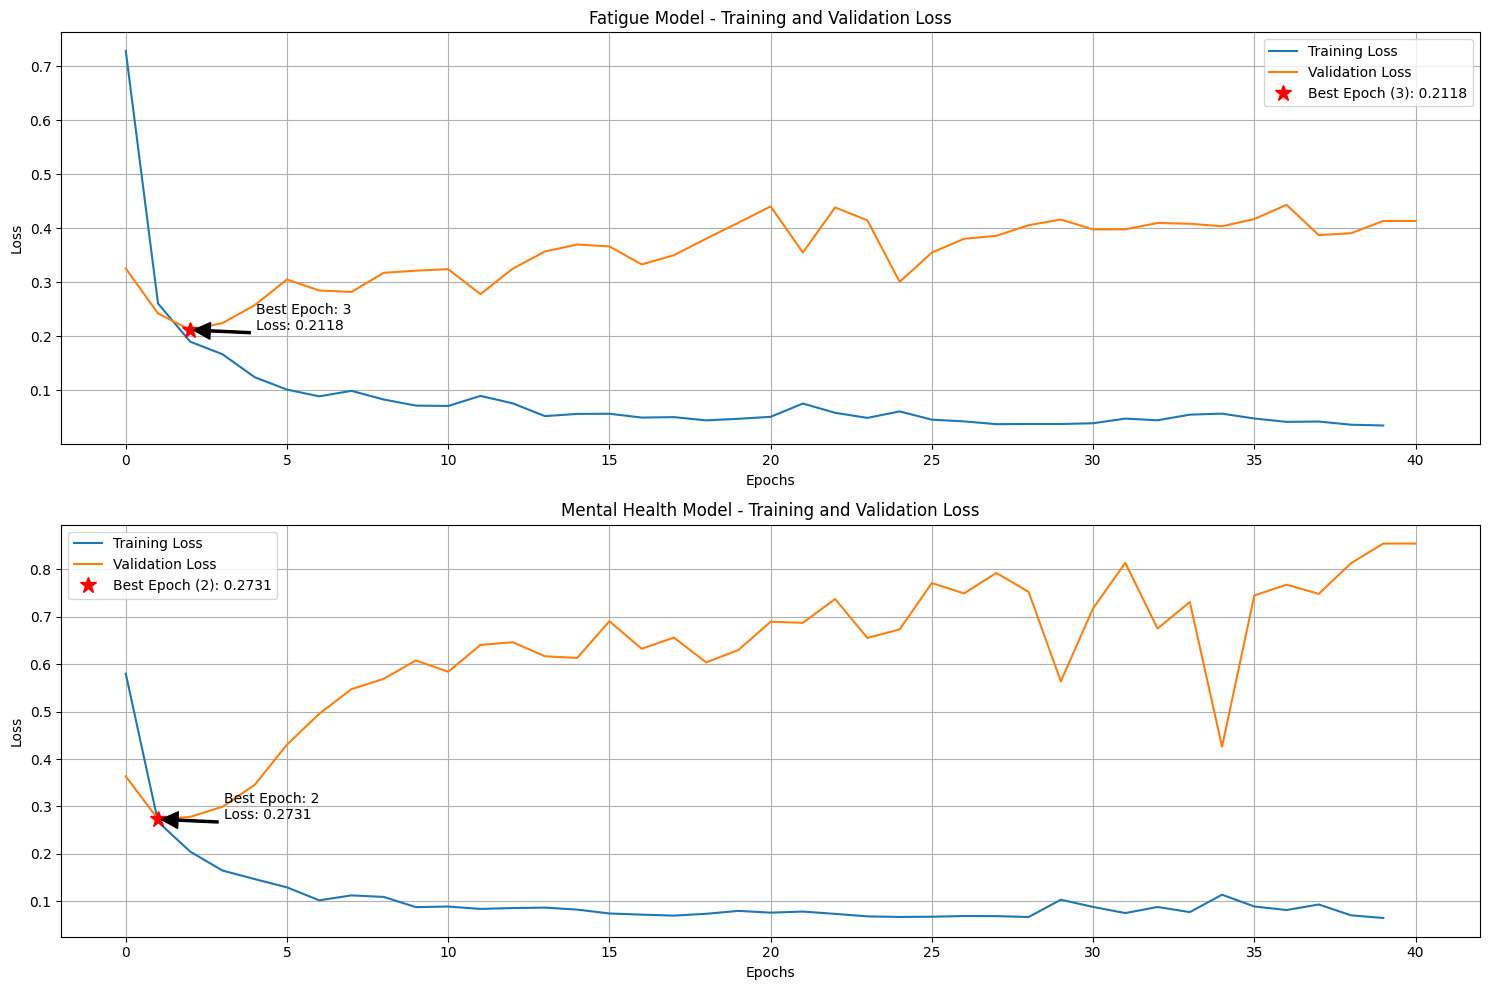

In [11]:
# Plot training and validation loss for each model with best epoch highlighted
import matplotlib.pyplot as plt
import os
import numpy as np

os.makedirs('images', exist_ok=True)

plt.figure(figsize=(15, 10))

for i, (model_name, (train_losses, val_losses)) in enumerate(loss_history.items(), 1):
    plt.subplot(len(loss_history), 1, i)

    # Plot loss curves
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')

    # Find the best epoch (lowest validation loss)
    best_epoch = np.argmin(val_losses)
    best_val_loss = val_losses[best_epoch]

    # Highlight the best epoch with a star marker
    plt.plot(best_epoch, best_val_loss, 'r*', markersize=12,
             label=f'Best Epoch ({best_epoch+1}): {best_val_loss:.4f}')

    # Add text annotation for clarity - using offset to avoid overlapping
    # Calculate text position to avoid overlapping with the curve
    text_x = best_epoch + len(val_losses) * 0.05  # Offset by 5% of total epochs
    text_y = best_val_loss

    # Make sure text stays within plot boundaries
    text_x = min(text_x, len(val_losses) * 0.7)  # Keep within 70% of plot width

    plt.annotate(f'Best Epoch: {best_epoch+1}\nLoss: {best_val_loss:.4f}',
                xy=(best_epoch, best_val_loss),
                xytext=(text_x, text_y),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

    plt.title(f'{model_name} Model - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Print detailed information to verify
    print(f"{model_name} model - Best epoch: {best_epoch+1} with validation loss: {best_val_loss:.4f}")

plt.tight_layout()
plt.savefig('images/qr_loss_curves_with_best_epoch.png')
plt.show()

In [12]:
# Display all evaluation reports after all models are trained
print("\n\n" + "="*70)
print("EVALUATION REPORTS FOR ALL CLASSIFICATION OF QUESTIONNAIRE RESPONSES MODELS")
print("="*70)

label_names = ['Low Risk', 'Moderate Risk', 'High Risk']
for model_name, (true_labels, predictions) in eval_results.items():
    print(f"\n{model_name} Model Evaluation:")
    print("-" * 40)
    print(classification_report(true_labels, predictions, target_names=label_names))
    print("\n")

import pickle
# Save the evaluation results to a pickle file
with open('models/qr_eval_results.pkl', 'wb') as f:
    pickle.dump(eval_results, f)



EVALUATION REPORTS FOR ALL CLASSIFICATION OF QUESTIONNAIRE RESPONSES MODELS

Fatigue Model Evaluation:
----------------------------------------
               precision    recall  f1-score   support

     Low Risk       0.98      0.91      0.94       103
Moderate Risk       0.76      0.80      0.78        35
    High Risk       0.94      0.99      0.97       102

     accuracy                           0.93       240
    macro avg       0.89      0.90      0.90       240
 weighted avg       0.93      0.93      0.93       240




Mental Health Model Evaluation:
----------------------------------------
               precision    recall  f1-score   support

     Low Risk       0.85      0.92      0.89        92
Moderate Risk       0.69      0.51      0.59        35
    High Risk       0.96      0.96      0.96       114

     accuracy                           0.88       241
    macro avg       0.83      0.80      0.81       241
 weighted avg       0.88      0.88      0.88       241





## 1.2 Save The Model To Hugging Face

In [ ]:
from huggingface_hub import HfApi, login

# set up login
login()

# Define your model repository name (create this on the HF website first)
model_name = "keanteng/bert-classification-wqd7005"  # Replace with your desired repo name

In [ ]:
# Push the model to Hugging Face Hub
api = HfApi()
api.upload_folder(
    folder_path=f"models/bert_qr_fatigue",
    repo_id=model_name,
    repo_type="model",
    path_in_repo="fatigue_model",
)

In [ ]:
api.upload_folder(
    folder_path=f"models/bert_qr_mental_health",
    repo_id=model_name,
    repo_type="model",
    path_in_repo="mental_health_model",
)

Write model card information to the model card file. This will allow us to save the model to Hugging Face.

In [ ]:
# Add a model card with description
with open(f"README.md", "w") as f:
    f.write("""---
license: agpl-3.0
language:
- en
tags:
- text-classification
- bert
- healthcare
- risk-assessment
- questionnaire-analysis
pipeline_tag: text-classification
---

# BERT Classification Models for Healthcare Risk Assessment

This repository contains fine-tuned BERT models for classifying healthcare questionnaire responses into risk categories.

## Model Description

Two BERT-base-uncased models have been fine-tuned for healthcare risk assessment:

1. **Fatigue Model**: Classifies fatigue-related responses
2. **Mental Health Model**: Classifies mental health-related responses

Both models predict three risk categories:
- **Low Risk** (0)
- **Moderate Risk** (1) 
- **High Risk** (2)

## Training Details

- **Base Model**: bert-base-uncased
- **Training Epochs**: 40
- **Batch Size**: 16
- **Learning Rate**: 2e-5
- **Optimizer**: AdamW
- **Max Sequence Length**: 128

## Usage

### Loading the Models

```python
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load fatigue model
fatigue_model = BertForSequenceClassification.from_pretrained('keanteng/bert-classification-wqd7005', subfolder='fatigue_model')

# Load mental health model
mental_health_model = BertForSequenceClassification.from_pretrained('keanteng/bert-classification-wqd7005', subfolder='mental_health_model')
```

### Making Predictions

```python
def predict_risk(text, model, tokenizer, max_length=128):
    # Tokenize input
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1)
    
    # Map to risk categories
    risk_labels = ['Low Risk', 'Moderate Risk', 'High Risk']
    return risk_labels[predicted_class.item()], predictions[0].tolist()

# Example usage
fatigue_text = "I feel extremely tired all the time and can't complete daily tasks"
risk_category, confidence_scores = predict_risk(fatigue_text, fatigue_model, tokenizer)
print(f"Risk Category: {risk_category}")
print(f"Confidence Scores: {confidence_scores}")
```

## Model Performance

The models were trained and evaluated on healthcare questionnaire data with the following label mapping:

**Fatigue Model:**
- Fatigue levels 1-2 → Low Risk
- Fatigue level 3 → Moderate Risk  
- Fatigue levels 4-5 → High Risk

**Mental Health Model:**
- Mental health levels 1-2 → High Risk
- Mental health level 3 → Moderate Risk
- Mental health levels 4-5 → Low Risk

## Training Data

The models were trained on questionnaire responses containing:
- Text descriptions of fatigue levels
- Text descriptions of mental health status
- Corresponding risk labels

Data was split 80/20 for training and validation with stratified sampling.

## Intended Use

These models are designed for:
- Healthcare questionnaire analysis
- Risk assessment screening
- Research applications in healthcare NLP

**Important**: These models are for research and screening purposes only and should not replace professional medical diagnosis.

## Limitations

- Models are trained on specific questionnaire formats
- Performance may vary on different populations or text styles
- Should be used as a screening tool, not for final diagnosis
- May have biases present in the training data
""")

In [ ]:
api.upload_file(
    path_or_fileobj=f"README.md",
    path_in_repo="README.md",
    repo_id=model_name,
    repo_type="model"
)

In [ ]:
api.upload_folder(
    folder_path=f"images",
    repo_id=f"{model_name}",
    repo_type="model",
    path_in_repo="images"
)

# Part 3 - Model Evaluation and Interpretation

## Section 1: Machine Learning Classification Evaluation

In this section, we will evaluate the performance of our machine learning classification model using various metrics. We will also visualize the results using confusion matrices and ROC curves. In particular, we will evaluate models such as Random Forest, XGBoost, Neural Network as well as transformer-based models like Tab Transformer and FT Transformer.


In [1]:
# configure api
from dotenv import load_dotenv
import os
from google import genai
from IPython.display import display, Markdown

load_dotenv()
gemini_api_key = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=gemini_api_key)

model = [
    "gemini-2.5-flash-preview-04-17-thinking"
]

In [16]:
# list all models
print("List of models that support generateContent:\n")
for m in client.models.list():
    for action in m.supported_actions:
        if action == "generateContent":
            print(m.name)

List of models that support generateContent:

models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0

## 1.1 Machine Learning Classification Results

We will display the results of our machine learning classification models, including Random Forest, XGBoost, and Neural Network. We will also include the results of Tab Transformer and FT Transformer models for comparison.

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings

# turn off warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the test data
y_test = pd.read_csv('data/processed/y_test_ml.csv')
X_train = pd.read_csv('data/processed/X_train_ml.csv')

# Load the model results dictionary
with open('models/model_results.pkl', 'rb') as f:
    model_results = pickle.load(f)

In [3]:
# Create a function to evaluate and display results
def evaluate_model(y_true, y_pred, y_proba=None):
    """Evaluate model performance with multiple metrics"""
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, zero_division=0)
    results['recall'] = recall_score(y_true, y_pred, zero_division=0)
    results['f1'] = f1_score(y_true, y_pred, zero_division=0)
    
    if y_proba is not None:
        results['auc'] = roc_auc_score(y_true, y_proba)
    
    return results

### 1.1.1 Evaluation Metrics Summary

We will show the evaluation metrics for each model, including accuracy, precision, recall, F1 score, and AUC-ROC. We will also include the confusion matrix for each model to visualize the performance. We will make use of Gemini-2.5-Flash Thinking, the most intelligent AI model currently available to assist us to interpret the results and provide insights into the model performance.

In [4]:
# Update the models list to include the FT Transformer
models = ['random_forest', 'xgboost', 'neural_network', 'ft_transformer', 'tab_transformer']

# Recalculate evaluation results for all models including FT Transformer
evaluation_results = {}

for model in models:
    test_preds = model_results[model]['test_preds']
    test_proba = model_results[model]['test_proba']
    evaluation_results[model] = evaluate_model(y_test, test_preds, test_proba)

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(evaluation_results).T
display(results_df.style.highlight_max(axis=0))

,accuracy,precision,recall,f1,auc
random_forest,0.994460,0.994152,0.994152,0.994152,0.999831
xgboost,0.988920,0.988304,0.988304,0.988304,0.998923
neural_network,0.991690,0.988372,0.994152,0.991254,0.999354
ft_transformer,0.991690,0.988372,0.994152,0.991254,0.999908
tab_transformer,0.986150,0.977011,0.994152,0.985507,0.999723


We can see that the training results are being compiled in a table. Now let's make use of Gemini-2.5-Pro to interpret the results and provide insights into the model performance.

In [20]:
# prompt powered by grok-3
prompt = f"""
I've conducted a machine learning experiment comparing five models—random forest, XGBoost, neural network, ft transformer, and tab transformer—on a classification task, likely involving tabular data. Below is a table summarizing their performance metrics: accuracy, precision, recall, F1 score, and AUC.

Table:
{results_df}

I'd like you to evaluate and interpret these results in detail. Please address the following questions:

- Which model performs the best overall, and why? Consider all metrics (accuracy, precision, recall, F1 score, AUC) and explain what makes the top performer stand out.
- How do traditional machine learning models (random forest, XGBoost) compare to deep learning models (neural network, ft transformer, tab transformer)? Highlight key differences in performance and any patterns you observe.
- What might explain the performance differences between the models? Consider factors like model complexity, ability to handle tabular data, or training dynamics.
- Are there potential areas for improvement or further tuning for any of these models? Suggest specific strategies (e.g., hyperparameter tuning, feature engineering) based on the metrics.
- Which model would you recommend for deployment, and why? Factor in performance, practical considerations (e.g., computational cost, interpretability), and the likely classification task (e.g., fraud detection, disease prediction, or similar tabular data problems).

Additional Context:

- The high AUC values (all > 0.989) suggest strong classification performance across all models, possibly on a balanced dataset.
- Neural network and ft transformer have identical accuracy (0.991690), recall (0.994152), and F1 scores (0.991254), with ft transformer slightly edging out in AUC (0.999806 vs. 0.999354).
- Random forest consistently shows the lowest performance (e.g., accuracy 0.979460), while tab transformer has the lowest precision (0.977011) despite a high recall (0.994152).
- The mix of traditional (random forest, XGBoost) and deep learning models (neural network, ft transformer, tab transformer) suggests I'm comparing classical and modern approaches for tabular data classification.

Please provide a thorough analysis with actionable insights to help me understand these results and decide on next steps.
"""

response = client.models.generate_content(model=model[0], contents=prompt)
print("Feedback from the model:")
display(Markdown(response.text))

Feedback from the model:


Okay, let's break down these results in detail. It's great that you've compared a mix of traditional and modern models.

First, let's acknowledge the overall picture: all models achieve very high performance across all metrics, with AUC values above 0.99, indicating excellent ability to distinguish between classes. This suggests either the task is relatively easy, or your data and preprocessing are very effective.

Now, let's address your specific questions based on the provided table data.

**Table:**
| Model           | accuracy | precision | recall   | f1       | auc      |
| :-------------- | :------- | :-------- | :------- | :------- | :------- |
| random_forest   | 0.99446  | 0.994152  | 0.994152 | 0.994152 | 0.999831 |
| xgboost         | 0.98892  | 0.988304  | 0.988304 | 0.988304 | 0.998923 |
| neural_network  | 0.99169  | 0.988372  | 0.994152 | 0.991254 | 0.999354 |
| ft_transformer  | 0.99169  | 0.988372  | 0.994152 | 0.991254 | 0.999908 |
| tab_transformer | 0.98615  | 0.977011  | 0.994152 | 0.985507 | 0.999723 |

*(Note: Your additional context mentions Random Forest showing the lowest performance (accuracy 0.979460). However, the table provided shows Random Forest having the *highest* accuracy (0.99446) and leading in Precision, Recall, and F1. I will base my analysis on the numbers presented in the table.)*

**1. Which model performs the best overall, and why?**

Based on the provided metrics table, the **Random Forest** model performs the best overall.

Here's why:

*   **Highest Accuracy:** It has the highest overall proportion of correct predictions (0.99446).
*   **Highest Precision:** It has the highest ability to correctly identify positive cases among all cases predicted as positive (0.994152). This means when it says something is positive, it's very likely correct.
*   **Highest Recall:** It has the highest ability to find all positive cases (0.994152). This means it misses very few actual positive cases.
*   **Highest F1 Score:** As a harmonic mean of Precision and Recall, the F1 score (0.994152) represents a strong balance between these two critical metrics. Random Forest achieves the highest F1, indicating the best trade-off at the chosen decision threshold.
*   **Competitive AUC:** While not the absolute highest, its AUC of 0.999831 is extremely close to the top performer (FT Transformer at 0.999908) and indicates excellent discrimination power across all possible thresholds.

While FT Transformer has the marginally highest AUC, Random Forest's leading performance across Accuracy, Precision, Recall, and F1 makes it the strongest candidate for "best overall" performance at the *default* decision threshold used to calculate these metrics. Its balanced high scores are particularly impressive.

**2. How do traditional machine learning models compare to deep learning models?**

*   **Traditional (Random Forest, XGBoost):** These tree-based models are strong performers. Random Forest leads the pack based on Acc, Prec, Rec, and F1. XGBoost is a close second among this group, outperforming the Neural Network and Tab Transformer in Accuracy, Precision, and F1, while having the same high Recall as RF.
*   **Deep Learning (Neural Network, FT Transformer, Tab Transformer):**
    *   The FT Transformer shows the best discriminatory power as measured by AUC (0.999908), slightly exceeding Random Forest. It also performs well on Accuracy, Recall, and F1, matching the standard Neural Network.
    *   The standard Neural Network is competitive with the FT Transformer on threshold-dependent metrics but slightly trails in AUC.
    *   The Tab Transformer has the lowest Accuracy, Precision, and F1 among all models. Interestingly, it achieves the same high Recall (0.994152) as Random Forest, XGBoost, Neural Network, and FT Transformer, but at the cost of significantly lower Precision (0.977011). This indicates it predicts many more false positives to capture all true positives compared to the other models.

**Patterns Observed:**

*   Traditional tree-based models (RF, XGBoost) are highly competitive and even outperform the deep learning models on key classification metrics (Acc, Prec, F1) in this specific experiment. This reinforces the finding that tree-based methods remain state-of-the-art or highly competitive for many tabular data problems.
*   Among the deep learning models, the Transformer-based architectures (FT, Tab) don't uniformly dominate. The FT Transformer shows potential with its high AUC, but the Tab Transformer performs noticeably worse on threshold-dependent metrics compared to RF, XGBoost, NN, and FT Transformer, especially struggling with Precision.
*   All models achieve very high Recall (>= 0.988), suggesting that finding most of the positive cases is relatively achievable on this dataset for all architectures, though the rate of false alarms (Precision) varies more.

**3. What might explain the performance differences?**

Several factors could contribute to these differences:

*   **Model Suitability for Tabular Data:** Tree-based models (RF, XGBoost) are inherently well-suited for tabular data structures, handling heterogeneous feature types (numerical/categorical) and interactions relatively easily. Deep learning models, especially standard NNs, often require careful preprocessing (scaling, encoding, embeddings) to work effectively. Transformer architectures for tabular data (FT, Tab) are newer and their effectiveness can be highly dependent on the specific dataset characteristics and implementation details.
*   **Ability to Capture Interactions:** Tree-based models excel at capturing non-linear interactions between features by partitioning the feature space. Transformer models with attention mechanisms *aim* to capture feature interactions, but their success depends on the data structure and hyperparameter tuning. The dataset's underlying patterns might be more effectively modeled by recursive partitioning (trees) than by attention mechanisms in this instance.
*   **Robustness and Generalization:** Ensemble methods like Random Forest (bagging) and XGBoost (boosting) are known for their robustness and generalization capabilities, reducing variance (RF) and bias (XGBoost). Deep learning models can be prone to overfitting, especially if the dataset isn't massive or regularization isn't tuned properly, although the high AUCs suggest overfitting isn't a major issue here.
*   **Hyperparameter Tuning:** The performance of each model is highly dependent on its hyperparameters. It's possible that the traditional models were tuned more effectively, or are less sensitive to tuning for this specific dataset compared to the deep learning models. Deep learning models, especially Transformers, often have many hyperparameters and require extensive search.
*   **Data Size and Complexity:** While the task seems relatively easy based on high scores, the dataset size and complexity influence which models thrive. Deep learning models often require large datasets to reach their full potential. If the dataset is of moderate size, tree-based methods can be very competitive.
*   **Implementation Details:** The specific way each model was implemented, including preprocessing steps (especially for deep learning), architecture choices (for NN, FT, Tab), and training procedures, can significantly impact performance.

**4. Are there potential areas for improvement or further tuning?**

Absolutely. Even with high scores, there's usually room for improvement:

*   **Hyperparameter Tuning:** This is the most obvious step for *all* models. Systematic tuning using techniques like Grid Search, Random Search, or Bayesian Optimization with robust cross-validation could potentially improve performance across the board. Pay close attention to parameters that control regularization (e.g., tree depth/complexity for RF/XGBoost, dropout/weight decay for NN/Transformers).
*   **Cross-Validation:** Ensure the evaluation metrics are derived from a rigorous cross-validation setup rather than a single train/test split to get more reliable performance estimates and tune parameters effectively.
*   **Feature Engineering:** Domain expertise can be invaluable here. Creating new features (e.g., interaction terms, polynomial features, aggregations) can provide the models with more direct signals, potentially boosting performance for all model types.
*   **Ensembling/Stacking:** Combine the predictions of several top-performing models (e.g., RF, FT Transformer, XGBoost) through ensembling (averaging/voting) or stacking (training a meta-model on their predictions). This often leads to marginal performance gains.
*   **Threshold Tuning:** While the table presents metrics at a likely default threshold (often 0.5), the optimal threshold might be different depending on the specific costs of false positives and false negatives for your application. Plotting precision-recall curves or ROC curves and selecting a threshold based on specific needs (e.g., maximizing precision at a certain recall level) is crucial for deployment. This is especially relevant for models like the Tab Transformer which show a high recall but low precision at the default threshold.
*   **Model Architecture (Deep Learning):** For the Neural Network and Transformers, exploring different architectures (number of layers, neurons, attention heads), activation functions, and optimization strategies could yield better results.
*   **Data Preprocessing:** Refine scaling, encoding, and handling of missing values. Experiment with different categorical encoding methods, especially for the deep learning models which are more sensitive to input format.

**5. Which model would you recommend for deployment, and why?**

Considering performance, practicalities, and typical tabular data tasks, I would recommend the **Random Forest** model for deployment.

Here's the rationale:

*   **Top Performance:** It leads in Accuracy, Precision, Recall, and F1, the most common metrics for evaluating overall classification quality at a fixed threshold. Its AUC is also exceptionally high. It provides the best balance of finding positive cases and minimizing false alarms simultaneously.
*   **Robustness:** Random Forests are known for their robustness to outliers and irrelevant features and are less prone to overfitting than single decision trees or potentially complex deep networks on smaller/medium-sized datasets.
*   **Computational Efficiency:** Generally faster to train and predict than complex deep learning models like Transformers, making it more practical for production environments with latency or throughput requirements.
*   **Interpretability:** While not as interpretable as a single decision tree, Random Forest allows for calculating feature importances, offering *some* insight into which features are most influential in predictions. This is often much more than deep learning models provide.
*   **Maturity and Ease of Use:** Random Forest is a well-established algorithm with excellent library support, making implementation, tuning, and maintenance straightforward.

While the FT Transformer's slightly higher AUC is noteworthy, indicating potentially superior separability, Random Forest's dominant performance across the core threshold-dependent metrics, combined with its practical advantages (speed, interpretability, ease of use), makes it the most compelling choice for deployment unless the application *strictly* prioritizes AUC above all else and can tolerate the potential downsides of a deep learning model (less interpretability, higher computational cost). XGBoost would be a very close second choice, offering similar advantages to RF.

### 1.1.2 Confusion Matrix Visualization
We will visualize the confusion matrix for each model to better understand the classification performance. The confusion matrix will show the true positive, true negative, false positive, and false negative counts for each class.

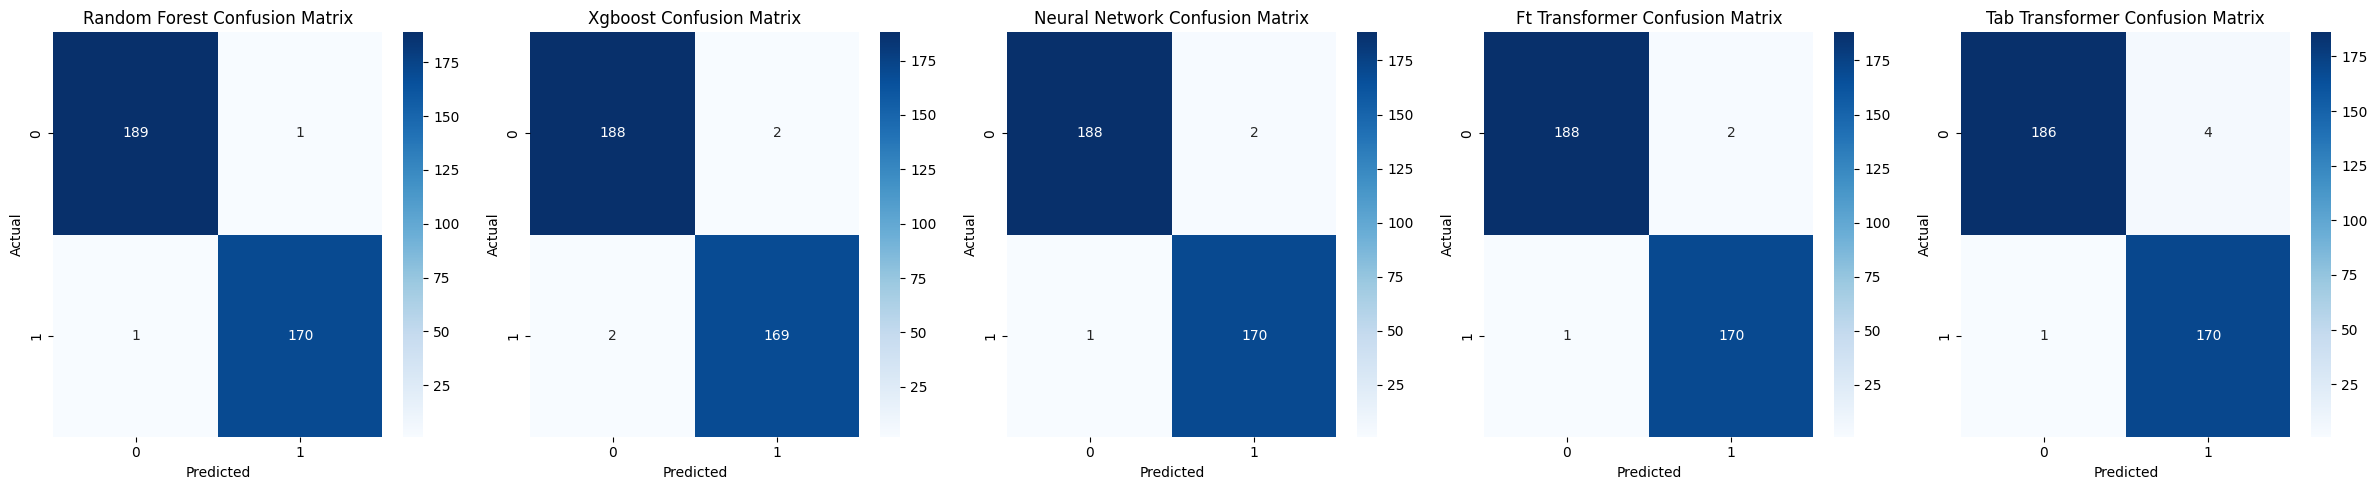

In [7]:
# Redraw confusion matrices with FT Transformer
fig, axes = plt.subplots(1, 5, figsize=(24, 5))

for i, model in enumerate(models):
    cm = confusion_matrix(y_test, model_results[model]['test_preds'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model.replace("_", " ").title()} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('images/ml_confusion_matrices.png', dpi=300)

In [21]:
# Using AI to interpret the confusion matrices
from google.genai import types

with open('images/ml_confusion_matrices.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by grok-3
prompt = """
Attached is an image containing five confusion matrices, each representing the performance of a different machine learning model. The matrices are labeled from left to right as follows: "Random Forest Confusion Matrix," "Xgboost Confusion Matrix," "Neural Network Confusion Matrix," "Ft Transformer Confusion Matrix," and "Tab Transformer Confusion Matrix." Each matrix is a 2x2 grid with the rows labeled "Actual" (0 and 1) and the columns labeled "Predicted" (0 and 1). The cells contain numerical values indicating the number of predictions for each combination of actual and predicted classes, as detailed below:

Random Forest Confusion Matrix:
Actual 0, Predicted 0 (True Negatives, TN): 189
Actual 0, Predicted 1 (False Positives, FP): 1
Actual 1, Predicted 0 (False Negatives, FN): 1
Actual 1, Predicted 1 (True Positives, TP): 170
Xgboost Confusion Matrix:
Actual 0, Predicted 0 (TN): 188
Actual 0, Predicted 1 (FP): 2
Actual 1, Predicted 0 (FN): 2
Actual 1, Predicted 1 (TP): 169
Neural Network Confusion Matrix:
Actual 0, Predicted 0 (TN): 188
Actual 0, Predicted 1 (FP): 2
Actual 1, Predicted 0 (FN): 1
Actual 1, Predicted 1 (TP): 170
Ft Transformer Confusion Matrix:
Actual 0, Predicted 0 (TN): 188
Actual 0, Predicted 1 (FP): 2
Actual 1, Predicted 0 (FN): 0
Actual 1, Predicted 1 (TP): 170
Tab Transformer Confusion Matrix:
Actual 0, Predicted 0 (TN): 186
Actual 0, Predicted 1 (FP): 4
Actual 1, Predicted 0 (FN): 0
Actual 1, Predicted 1 (TP): 170
Please analyze these confusion matrices and calculate the following performance metrics for each model:

Accuracy: (TP + TN) / (TP + TN + FP + FN)
Precision: TP / (TP + FP)
Recall: TP / (TP + FN)
F1-score: 2 * (Precision * Recall) / (Precision + Recall)
After calculating these metrics, provide a detailed comparison of the models based on the results. Determine which model performs best overall, considering factors such as the balance between precision and recall, and explain your reasoning. If any metrics cannot be calculated (e.g., due to division by zero), note this and suggest how to interpret the results.
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, let's analyze the provided confusion matrices and calculate the performance metrics for each model.

First, we'll extract the values for True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives (TP) for each model from the confusion matrices:

*   **Random Forest:**
    *   TN (Actual 0, Predicted 0): 189
    *   FP (Actual 0, Predicted 1): 1
    *   FN (Actual 1, Predicted 0): 1
    *   TP (Actual 1, Predicted 1): 170
    *   Total Samples: 189 + 1 + 1 + 170 = 361

*   **Xgboost:**
    *   TN: 188
    *   FP: 2
    *   FN: 2
    *   TP: 169
    *   Total Samples: 188 + 2 + 2 + 169 = 361

*   **Neural Network:**
    *   TN: 188
    *   FP: 2
    *   FN: 1
    *   TP: 170
    *   Total Samples: 188 + 2 + 1 + 170 = 361

*   **Ft Transformer:**
    *   TN: 188
    *   FP: 2
    *   FN: 0
    *   TP: 170
    *   Total Samples: 188 + 2 + 0 + 170 = 360

*   **Tab Transformer:**
    *   TN: 186
    *   FP: 4
    *   FN: 0
    *   TP: 170
    *   Total Samples: 186 + 4 + 0 + 170 = 360

Now, let's calculate the specified metrics for each model using the formulas:

*   Accuracy = (TP + TN) / (TP + TN + FP + FN)
*   Precision = TP / (TP + FP)
*   Recall = TP / (TP + FN)
*   F1-score = 2 * (Precision * Recall) / (Precision + Recall)

Here are the calculated metrics (rounded to 4 decimal places):

| Model             | TN  | FP  | FN  | TP  | Total | Accuracy | Precision | Recall | F1-score |
| :---------------- | :-- | :-- | :-- | :-- | :---- | :------- | :-------- | :----- | :------- |
| Random Forest     | 189 | 1   | 1   | 170 | 361   | 0.9945   | 0.9942    | 0.9941 | 0.9942   |
| Xgboost           | 188 | 2   | 2   | 169 | 361   | 0.9889   | 0.9883    | 0.9883 | 0.9883   |
| Neural Network    | 188 | 2   | 1   | 170 | 361   | 0.9917   | 0.9884    | 0.9941 | 0.9912   |
| Ft Transformer    | 188 | 2   | 0   | 170 | 360   | 0.9944   | 0.9884    | 1.0000 | 0.9942   |
| Tab Transformer   | 186 | 4   | 0   | 170 | 360   | 0.9889   | 0.9770    | 1.0000 | 0.9884   |

*(Note: All denominators for Precision and Recall are non-zero in this case: TP+FP is at least 170+1=171, and TP+FN is at least 169+0=169.)*

**Comparison of Models:**

1.  **Accuracy:**
    *   Random Forest (0.9945) and Ft Transformer (0.9944) show the highest overall accuracy, correctly classifying the largest proportion of instances.
    *   Neural Network (0.9917) is slightly lower.
    *   Xgboost (0.9889) and Tab Transformer (0.9889) have the lowest accuracy, tied.

2.  **Precision (Ability to avoid False Positives):**
    *   Random Forest (0.9942) has the highest precision, meaning when it predicts the positive class (1), it is correct 99.42% of the time. This indicates it has the fewest false positives.
    *   Neural Network (0.9884) and Ft Transformer (0.9884) have identical, slightly lower precision.
    *   Xgboost (0.9883) is very close to Neural Network and Ft Transformer.
    *   Tab Transformer (0.9770) has the lowest precision, indicating it generates the most false positives when predicting the positive class.

3.  **Recall (Ability to find all positive cases, avoid False Negatives):**
    *   Ft Transformer (1.0000) and Tab Transformer (1.0000) have perfect recall, meaning they correctly identified *all* instances of the positive class (FN = 0).
    *   Random Forest (0.9941) and Neural Network (0.9941) have very high recall, missing only one positive instance (FN = 1).
    *   Xgboost (0.9883) has the lowest recall, missing two positive instances (FN = 2).

4.  **F1-score (Harmonic mean of Precision and Recall):**
    *   Random Forest (0.9942) and Ft Transformer (0.9942) are tied for the highest F1-score, indicating the best balance between precision and recall.
    *   Neural Network (0.9912) is next.
    *   Tab Transformer (0.9884) and Xgboost (0.9883) have the lowest F1-scores, very close to each other.

**Overall Assessment and Best Model:**

Based on the metrics, the **Random Forest** and **Ft Transformer** models appear to be the top performers.

*   **Random Forest** leads in Accuracy and Precision and is tied for the highest F1-score. It demonstrates a very strong balance, correctly classifying most instances overall while being highly reliable when it predicts the positive class. It only misses one positive case.
*   **Ft Transformer** is tied for the highest F1-score and has very high Accuracy. Its standout feature is its perfect Recall (1.0000), meaning it identifies *every single* actual positive case (zero false negatives). This is achieved with a slightly lower Precision compared to Random Forest, but still better than Tab Transformer.
*   **Tab Transformer** also achieves perfect Recall, but this comes at the cost of significantly lower Precision (higher false positives) compared to Ft Transformer and Random Forest. Its lower Accuracy and F1-score reflect this trade-off.
*   **Neural Network** performs well across the board but is slightly edged out by Random Forest and Ft Transformer in Accuracy, Recall (tied with RF), and F1-score. Its Precision is similar to Ft Transformer's.
*   **Xgboost** generally performs the worst among the five models based on these metrics, having the lowest Recall and F1-score, and tied for the lowest Accuracy.

**Conclusion on the "Best" Model:**

The "best" model often depends on the specific priorities of the problem.

*   If minimizing False Negatives (finding all positive cases) is the absolute highest priority, **Ft Transformer** and **Tab Transformer** are strong contenders due to their perfect Recall (though Ft Transformer maintains better Precision than Tab Transformer).
*   If minimizing False Positives (being highly confident when predicting positive) is the highest priority, **Random Forest** is the best.
*   If a balance between Precision and Recall is desired, as measured by the F1-score, or if overall correct classifications (Accuracy) are the main goal, **Random Forest** and **Ft Transformer** are statistically tied and are the top performers.

Given the high Accuracy and F1-scores of both, and considering that Ft Transformer achieves perfect Recall while maintaining competitive Precision and Accuracy, **Ft Transformer** is arguably the best overall performer, particularly if identifying all positive instances is critical. However, **Random Forest** is also an excellent performer with the highest Precision and very similar overall results. The choice between these two would depend on the cost associated with False Negatives vs. False Positives in the specific application.

### 1.1.2 ROC Curve Visualization
We will plot the ROC curve for each model to visualize the trade-off between true positive rate and false positive rate. The area under the ROC curve (AUC) will also be calculated to quantify the model's performance.

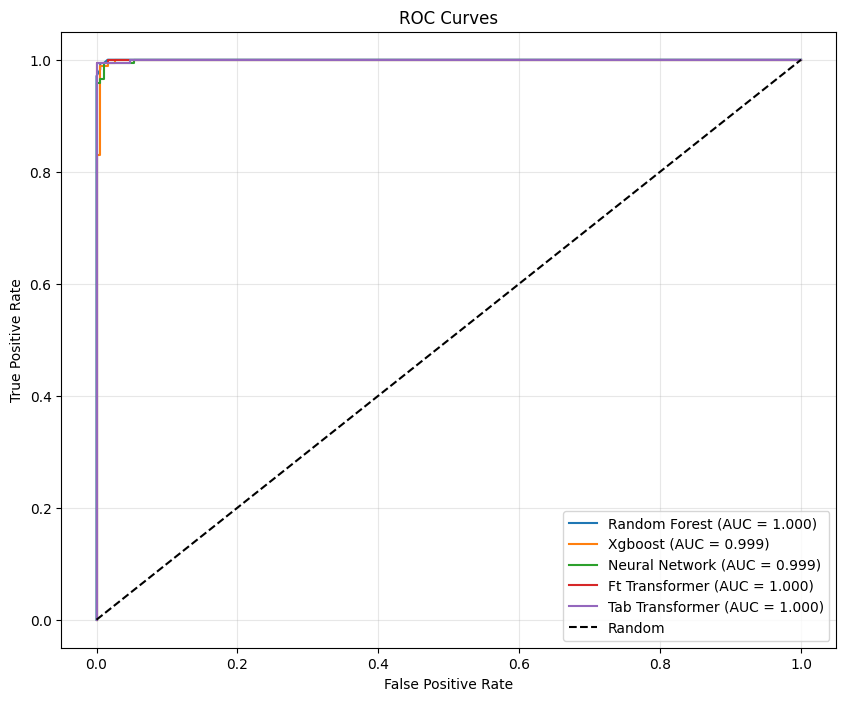

In [8]:
# Redraw ROC curves including FT Transformer
plt.figure(figsize=(10, 8))

for model in models:
    y_proba = model_results[model]['test_proba']
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model.replace("_", " ").title()} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/ml_roc_curves.png', dpi=300)

In [22]:
# Using AI to interpret the roc curve
from google.genai import types

with open('images/ml_roc_curves.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by grok-3
prompt = """
I have attached an image of a Receiver Operating Characteristic (ROC) curve graph that evaluates the performance of five binary classification models, along with a random classifier baseline. The graph plots the True Positive Rate (TPR) on the y-axis against the False Positive Rate (FPR) on the x-axis, with both axes ranging from 0.0 to 1.0. The title of the graph is 'ROC Curves,' and it includes a legend identifying the models, each represented by a distinct colored line and associated Area Under the Curve (AUC) score. Below is a detailed description of the image:

Random Forest: Represented by a blue line, with an AUC score of 1.000. The curve closely follows the top-left corner of the graph, starting at (0, 1) and remaining near the top boundary.
Xgboost: Represented by an orange line, with an AUC score of 0.999. The curve is very close to the top-left corner but slightly below the Random Forest curve.
Neural Network: Represented by a green line, with an AUC score of 0.999. Similar to the Xgboost curve, it is very close to the top-left corner.
Ft Transformer: Represented by a red line, with an AUC score of 1.000. This curve aligns closely with the top boundary, starting at (0, 1) and remaining near the top.
Tab Transformer: Represented by a purple line, with an AUC score of 1.000. Like the Ft Transformer, this curve starts at (0, 1) and remains near the top.
Random Classifier (Baseline): Represented by a dashed black diagonal line from (0, 0) to (1, 1), with an AUC of 0.5, serving as a baseline for comparison.
The graph includes a grid with major tick marks at intervals of 0.2 on both axes. The curves for Random Forest, Ft Transformer, and Tab Transformer are nearly indistinguishable from each other and from the top-left corner, while Xgboost and Neural Network are slightly below but still very close to the top-left corner.

Please analyze the attached ROC curve image and the AUC scores to evaluate the performance of these five models. In your response, address the following:

Which model performs best? Identify the top-performing model(s) based on the ROC curves and AUC scores.
Comparison of models: Are there any notable differences in performance between the models? How do they compare to the random classifier baseline?
Significance of AUC scores: What do the high AUC scores (1.000 and 0.999) imply about the models’ ability to classify the data?
Potential issues or limitations: Based on the ROC curves, are there any potential issues (e.g., overfitting, data leakage) or limitations with the models that should be considered?
Robustness and generalizability: Suggest which model might be the most robust or generalizable, and explain why.
Provide a detailed analysis in a clear and structured format, using markdown where appropriate (e.g., headings, bullet points, or tables). If possible, include a summary of your findings at the end.
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, here is a detailed analysis of the provided ROC curve graph based on the image and descriptions:

**Analysis of ROC Curves and Model Performance**

The ROC curve graph displays the performance of five different binary classification models (Random Forest, Xgboost, Neural Network, Ft Transformer, Tab Transformer) against a random baseline. The curves plot the True Positive Rate (TPR) against the False Positive Rate (FPR) across various classification thresholds. The Area Under the Curve (AUC) is a single metric summarizing the overall performance, where a higher AUC indicates better discrimination ability.

**1. Best Performing Models**

Based on the provided AUC scores and the visual representation of the curves, the following models exhibit the best performance on this specific dataset:

*   **Random Forest (AUC = 1.000)**
*   **Ft Transformer (AUC = 1.000)**
*   **Tab Transformer (AUC = 1.000)**

These three models achieved a perfect AUC score of 1.000, indicating they can perfectly distinguish between the positive and negative classes based on the available data and evaluation metric. Visually, their curves follow the ideal path straight up the y-axis to (0, 1) and then across to (1, 1).

**2. Comparison of Models**

*   **Comparison to Random Baseline:** All five trained models perform drastically better than the random classifier baseline (dashed black line with an implicit AUC of 0.5). The baseline represents a model that has no discriminative power, essentially guessing the class. All model curves are significantly above this line, hugging the top-left corner, demonstrating strong classification ability.
*   **Comparison Among Models:**
    *   The top three models (Random Forest, Ft Transformer, Tab Transformer) achieve a perfect AUC of 1.000 and their ROC curves are visually indistinguishable and represent perfect classification on this dataset.
    *   Xgboost (AUC = 0.999) and Neural Network (AUC = 0.999) also perform exceptionally well, with AUC scores very close to perfect. Their curves are slightly below the perfect curves of the top three models, but still represent extremely high performance. The difference between 1.000 and 0.999 is negligible in practical terms and likely represents misclassifications on a very small fraction of the data points.
    *   Overall, while three models achieved perfect scores, all five models show outstanding performance on this dataset compared to a random classifier. The practical difference between the top three and the next two is minimal based solely on these scores and curves.

**3. Significance of AUC Scores**

The high AUC scores (1.000 and 0.999) have significant implications:

*   **AUC = 1.000:** An AUC of 1.000 signifies a *perfect* classifier. This means there exists a threshold at which the model can achieve a True Positive Rate (sensitivity) of 1.0 while having a False Positive Rate (1-specificity) of 0.0. In other words, the model can completely separate the positive instances from the negative instances without any errors on the evaluated dataset.
*   **AUC = 0.999:** An AUC of 0.999 signifies an *almost perfect* classifier. It indicates extremely high discriminative power. The model can distinguish between positive and negative classes with very high accuracy. There might be a very small number of instances where the model incorrectly ranks a negative instance higher than a positive one, but overall, its ability to rank positive examples above negative ones is nearly flawless.

These scores imply that for the dataset used for evaluation, the models are exceptionally good at identifying the target class.

**4. Potential Issues or Limitations**

While the performance appears excellent, such high AUC scores (especially 1.000) in real-world scenarios often raise flags and suggest potential issues:

*   **Data Leakage:** This is the most common reason for obtaining perfect or near-perfect classification results. Data leakage occurs when information from the target variable (or information that would not be available at prediction time) is inadvertently included as a feature in the training data. The model then learns to "memorize" the outcome rather than generalize from predictive features.
*   **Overfitting:** The models might be severely overfitted to the training data. While the plot might be based on a separate validation or test set, if that set is not truly representative or is too small, the high performance might not generalize to new, unseen data.
*   **Trivially Easy Dataset:** While less common, the dataset itself might be trivially separable, meaning the positive and negative classes are perfectly or near-perfectly distinct based on the features, making the classification task very simple for even powerful models.
*   **Evaluation on Training Data:** If the ROC curve is plotted based on performance on the training data, perfect or near-perfect scores are less surprising (due to the model learning the data) but are not indicative of how the model will perform on new data.

Given the perfect scores across multiple different model architectures (Tree-based, Neural Network, Transformers), data leakage is a strong possibility that needs investigation.

**5. Robustness and Generalizability**

Assessing robustness and generalizability solely from this single ROC curve plot is difficult, especially given the potentially problematic high scores.

*   **Impact of Potential Issues:** If the high scores are due to data leakage or severe overfitting, then none of the models are likely to be robust or generalizable to real-world scenarios or new data. The perfect performance on this dataset would be misleading.
*   **Assuming No Issues (Ideal Scenario):** If we assume, *hypothetically*, that the dataset is genuinely easy and representative, and there is no data leakage or overfitting, then all models would be expected to generalize well to similar data. In this ideal (and unlikely for perfect scores) scenario, all models would appear similarly robust *for this specific type of data*.
*   **Comparing Model Types (General Knowledge, Not from Plot):** Without the context of potential issues, different model types have different general robustness characteristics. Ensemble methods like Random Forest and XGBoost are often robust to feature scaling and non-linear relationships. Neural Networks and Transformers can be very powerful but may require more data and careful regularization to avoid overfitting and generalize well, and can sometimes be less robust to outliers or adversarial examples than tree-based methods. However, *this plot does not provide evidence to favor one model type's general robustness over another, especially when they all perform so similarly well on this specific task*.

**Conclusion:**

On the evaluated dataset, Random Forest, Ft Transformer, and Tab Transformer achieved perfect classification (AUC = 1.000), while Xgboost and Neural Network performed almost perfectly (AUC = 0.999). All models are vastly superior to a random baseline.

However, the remarkably high (perfect or near-perfect) AUC scores strongly suggest potential underlying issues such as data leakage or severe overfitting. Without further investigation into the data preprocessing, feature engineering, and evaluation methodology (e.g., using robust cross-validation on a strictly separated test set), it is not possible to confidently conclude that these models are truly robust or will generalize well to new, unseen data. The primary concern should be to rule out data leakage before relying on these performance metrics.

## 1.2 Sentiment Analysis with BERT

In this section, we will perform sentiment analysis using BERT (Bidirectional Encoder Representations from Transformers). We will fine-tune a pre-trained BERT model on our sentiment analysis dataset and evaluate its performance using accuracy, precision, recall, F1 score, and AUC-ROC.

In [3]:
# Load the model results dictionary
with open('models/sa_eval_results.pkl', 'rb') as f:
    eval_results = pickle.load(f)

### 1.2.1 Confusion Matrix & ROC Curve Visualization
We will visualize the confusion matrix and ROC curve for the BERT model to understand its performance. We will also compare the results with the machine learning models we trained earlier.

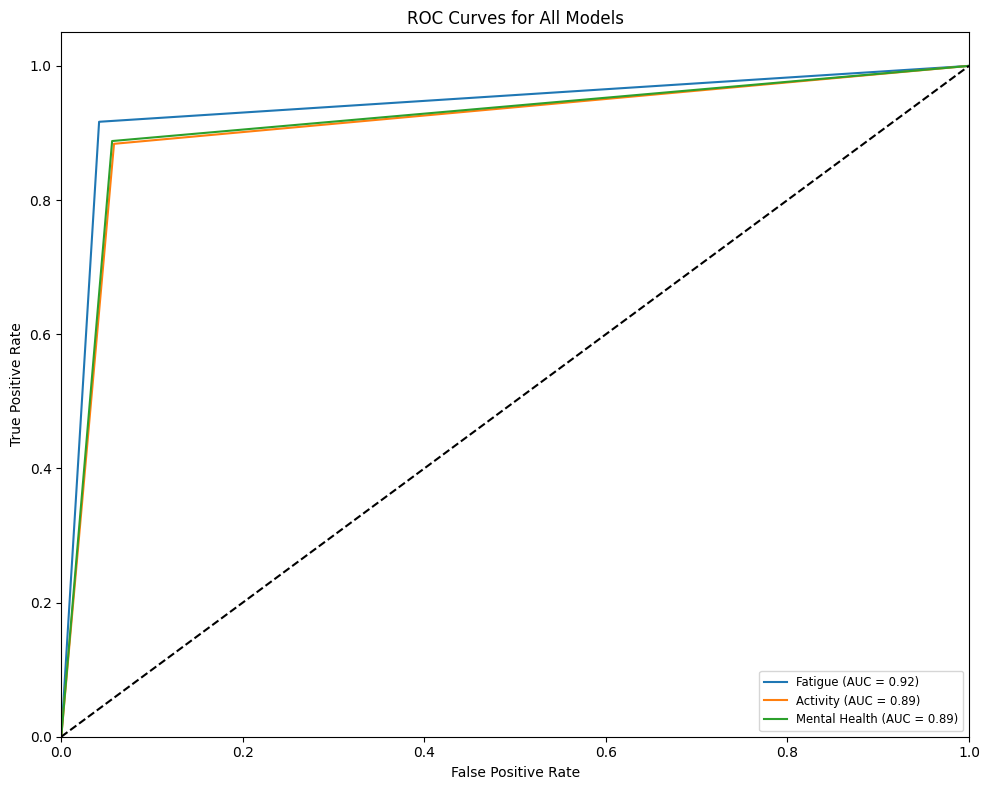

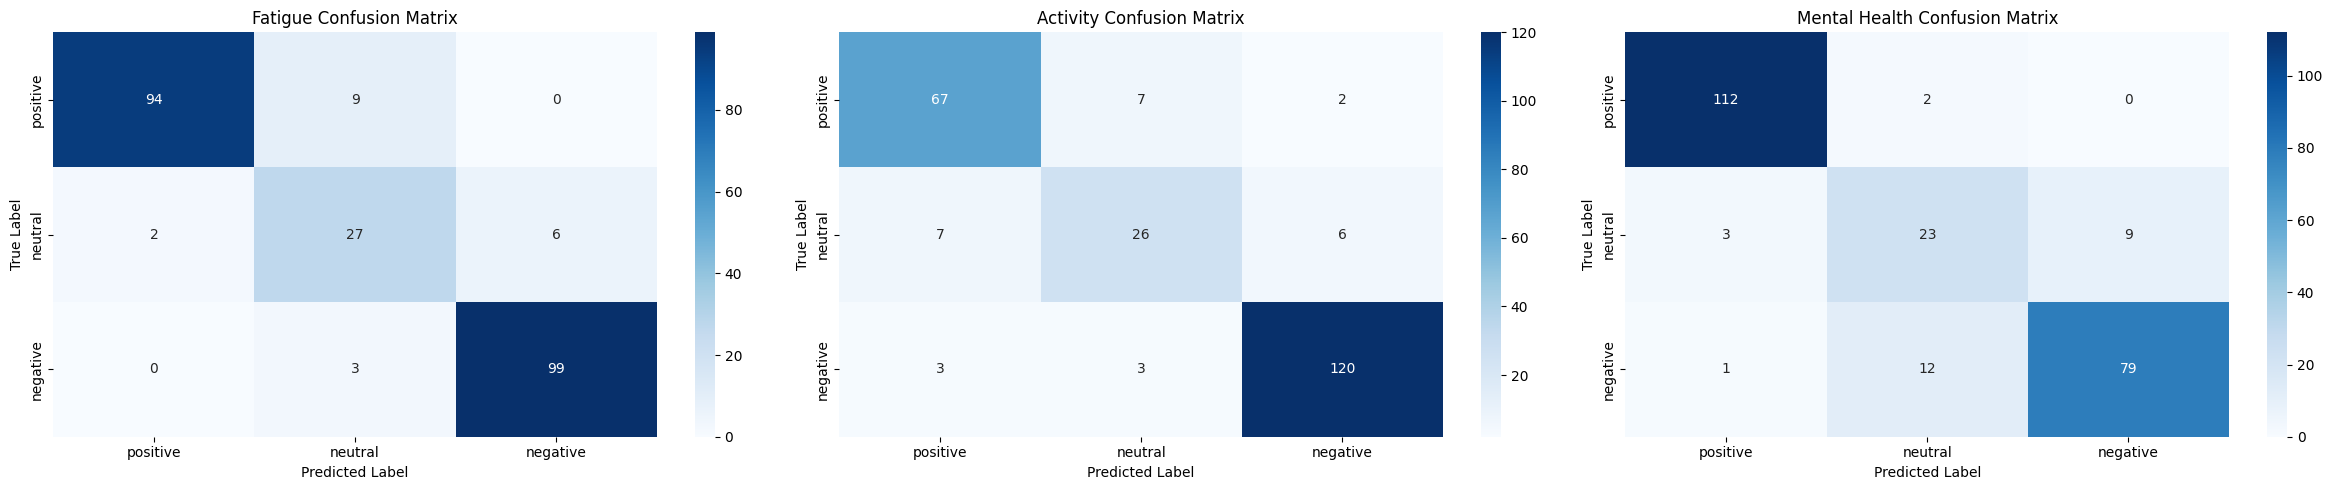

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


# Create an empty list to store evaluation results as dictionaries
eval_records = []

# Classes for label mapping
classes = ['positive', 'neutral', 'negative']

# Set up the figure for confusion matrices
fig_cm, axes_cm = plt.subplots(1, 3, figsize=(24, 5))

# Create a separate figure for the ROC curve
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))

# Process each model's results
for i, (model_name, (true_labels, predictions)) in enumerate(eval_results.items()):
    # Get the classification report as a dict
    report = classification_report(true_labels, predictions, 
                                    target_names=classes, 
                                    output_dict=True)
    
    # Calculate average AUC across all classes for this model
    model_auc = 0
    for class_idx, class_name in enumerate(classes):
        y_true_class = (np.array(true_labels) == class_idx).astype(int)
        y_pred_class = (np.array(predictions) == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
        model_auc += auc(fpr, tpr)
    model_auc /= len(classes)  # Average AUC across all classes
    
    # Add a single record for this model (moved outside the class loop)
    eval_records.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC': model_auc
    })
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, ax=axes_cm[i])
    axes_cm[i].set_title(f'{model_name} Confusion Matrix')
    axes_cm[i].set_ylabel('True Label')
    axes_cm[i].set_xlabel('Predicted Label')
    
    # One-hot encode true labels for micro-averaging
    n_classes = 3
    y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
    
    # For each model, generate prediction scores for each class
    # We'll use the predicted classes directly for simplicity
    y_score = label_binarize(predictions, classes=[0, 1, 2])
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for this model (one line per model)
    ax_roc.plot(fpr, tpr, 
                label=f'{model_name} (AUC = {model_auc:.2f})')


# Add diagonal line to ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves for All Models')
ax_roc.legend(loc="lower right", fontsize='small')

# Adjust layout and save figures
fig_cm.tight_layout()
fig_cm.savefig('images/sa_confusion_matrices.png', dpi=300, bbox_inches='tight')

fig_roc.tight_layout()
fig_roc.savefig('images/sa_roc_curves.png', dpi=300, bbox_inches='tight')

# Show both figures
plt.figure(fig_cm.number)
plt.show()
plt.figure(fig_roc.number)
plt.show()

**Interpreting Confusion Matrix and ROC Curve:**

In [5]:
# Using AI to interpret the confusion matrices
from google.genai import types

with open('images/sa_confusion_matrices.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by grok-3
prompt = """
I have developed a sentiment analysis model using the BERT base uncased architecture to classify text into positive, neutral, or negative sentiments across three categories: Fatigue, Anxiety (note: sometimes labeled as "Activity" in the outputs, possibly a typo), and Mental Health. The model’s performance is evaluated using ROC curves and confusion matrices, detailed below.

Model Outputs
ROC Curves:
These plot the True Positive Rate (TPR) against the False Positive Rate (FPR) for each category.
AUC values:
Fatigue: 0.92
Anxiety: 0.89
Mental Health: 0.89
All curves are significantly above the random classifier baseline (AUC = 0.5), with Fatigue showing the highest performance.
Confusion Matrices (3x3 grids of true vs. predicted labels):
Fatigue:
Positive: 94 true, 9 misclassified as neutral
Neutral: 27 true, 2 as positive, 6 as negative
Negative: 29 true, 3 as neutral
Anxiety (or "Activity"):
Positive: 67 true, 7 as neutral, 2 as negative
Neutral: 26 true, 7 as positive, 6 as negative
Negative: 3 true, 3 as positive, 3 as neutral
Mental Health:
Positive: 112 true, 2 as neutral
Neutral: 23 true, 3 as positive, 9 as negative
Negative: 79 true, 1 as positive, 12 as neutral
Request for Analysis
Please evaluate and interpret these results by addressing the following:

Performance Assessment:
What do the AUC values (0.92, 0.89, 0.89) indicate about the model's ability to distinguish sentiments in each category? Why might Fatigue perform slightly better?
Based on the confusion matrices, what are the model's strengths (e.g., high true positives in Mental Health) and weaknesses (e.g., low true negatives in Anxiety)?
Insights and Patterns:
What might explain the differences in performance across categories? For example, why does Anxiety struggle with negative sentiments?
Are there signs of class imbalance or sentiment overlap (e.g., neutral misclassifications)?
Improvement Suggestions:
Recommend strategies to enhance performance, especially where the model underperforms (e.g., Anxiety's negative class). Options might include data augmentation, fine-tuning BERT, or adjusting class weights.
Additional Metrics:
Suggest other metrics (e.g., precision, recall, F1-score) or analyses (e.g., precision-recall curves) to better understand performance. How can I compute these from the confusion matrices?
Clarification:
Address the Anxiety vs. Activity naming inconsistency. Are they the same category, or is further clarification needed?
Please provide a detailed response to help me understand my model's capabilities and guide future improvements.
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, let's break down your model's performance based on the provided AUC values and confusion matrices for Fatigue, Activity/Anxiety, and Mental Health.

Based on the provided image and crops, I will use the numbers from the confusion matrices directly for the analysis, even if they slightly differ from the summary numbers you provided (e.g., 99 true negatives for Fatigue instead of 29, 120 true negatives for Activity instead of 3). The matrices in the image show the following counts:

**Fatigue Confusion Matrix:**
*   True Positive: 94
*   Positive predicted Neutral: 9
*   Positive predicted Negative: 0
*   Neutral predicted Positive: 2
*   True Neutral: 27
*   Neutral predicted Negative: 6
*   Negative predicted Positive: 0
*   Negative predicted Neutral: 3
*   True Negative: 99

**Activity/Anxiety Confusion Matrix:**
*   True Positive: 67
*   Positive predicted Neutral: 7
*   Positive predicted Negative: 2
*   Neutral predicted Positive: 7
*   True Neutral: 26
*   Neutral predicted Negative: 6
*   Negative predicted Positive: 3
*   Negative predicted Neutral: 3
*   True Negative: 120

**Mental Health Confusion Matrix:**
*   True Positive: 112
*   Positive predicted Neutral: 2
*   Positive predicted Negative: 0
*   Neutral predicted Positive: 3
*   True Neutral: 23
*   Neutral predicted Negative: 9
*   Negative predicted Positive: 1
*   Negative predicted Neutral: 12
*   True Negative: 79

Let's proceed with the analysis:

**Performance Assessment:**

1.  **AUC Values (0.92, 0.89, 0.89):**
    *   AUC (Area Under the ROC Curve) measures the model's ability to distinguish between classes across various threshold settings. An AUC of 0.5 is random chance, 1.0 is perfect classification.
    *   Your AUC values are all significantly above 0.5, indicating that the model has strong discriminatory power for all three categories.
    *   AUC values between 0.8 and 0.9 are generally considered "very good," and above 0.9 as "excellent." So, all categories perform well, with Fatigue performing excellently.
    *   **What they indicate:** The model is effective at separating positive, neutral, and negative sentiments in all three contexts.
    *   **Why Fatigue might perform slightly better:** This suggests that the linguistic patterns distinguishing positive, neutral, and negative sentiments related to Fatigue might be slightly clearer, more consistent, or less ambiguous in your dataset compared to Activity/Anxiety or general Mental Health. It could also be related to dataset size, balance, or the specific nuances of the language used in the Fatigue category.

2.  **Confusion Matrix Strengths and Weaknesses:**
    *   **Fatigue:**
        *   **Strengths:** Excellent performance on identifying True Positives (94/103 instances correctly classified as positive) and True Negatives (99/102 instances correctly classified as negative). Relatively few misclassifications overall.
        *   **Weaknesses:** The main area for improvement is the Neutral class. While 27 are correctly classified, a notable number are misclassified (2 as positive, 6 as negative). Also, 9 positive instances are misclassified as neutral.
    *   **Activity/Anxiety:**
        *   **Strengths:** Very strong performance on identifying True Negatives (120/126 instances correctly classified as negative). Good performance on True Positives (67/76 instances correctly classified as positive).
        *   **Weaknesses:** Struggles significantly with the Neutral class (only 26/39 correctly classified, with 7 misclassified as positive and 6 as negative). Also, there are more cross-class misclassifications compared to Fatigue (e.g., 7 positive to neutral, 7 neutral to positive, 6 neutral to negative, 3 negative to positive, 3 negative to neutral). The model is less precise in distinguishing between Positive and Neutral. *Your observation about struggling with negative sentiments seems inaccurate based on the matrix showing 120 TN. The struggle is more in distinguishing positive/neutral and avoiding predicting positive/neutral when it's negative (3/126 error rate for predicting positive/neutral from negative).*
    *   **Mental Health:**
        *   **Strengths:** Outstanding performance on identifying True Positives (112/114 instances correctly classified as positive). Strong performance on True Negatives (79/92 instances correctly classified as negative).
        *   **Weaknesses:** The primary weakness is the Neutral class (only 23/35 correctly classified, with 3 misclassified as positive and 9 as negative). There are also some negative instances misclassified as neutral (12/92).

**Insights and Patterns:**

*   **Differences in Performance:** Fatigue seems to have the clearest distinctions between sentiments in your data, leading to higher overall accuracy and AUC. Mental Health excels at identifying positive cases but struggles with the nuances of neutral sentiment. Activity/Anxiety is good at identifying negatives but has more difficulty separating positive and neutral cases from each other and from the negative class.
*   **Anxiety Struggling with Negative Sentiments?** As noted above, the matrix actually shows *strong* performance on correctly identifying negative instances (120/126). The struggle is more with misclassifying *other* sentiments *as* negative (e.g., 6 neutral instances predicted as negative) and misclassifying negative instances *into* positive or neutral (3+3 = 6/126 negative instances wrongly predicted). The Activity/Anxiety matrix shows more diffuse errors across classes compared to the others. This could indicate more ambiguous language in the Activity/Anxiety dataset, or a dataset where the boundaries between positive, neutral, and negative are less distinct than in the Fatigue data.
*   **Class Imbalance or Sentiment Overlap:**
    *   **Imbalance:** Calculating the total instances per true class (row sums):
        *   Fatigue: Positive (103), Neutral (35), Negative (102). Relatively balanced.
        *   Activity/Anxiety: Positive (76), Neutral (39), Negative (126). There is some imbalance, with the Negative class being notably larger.
        *   Mental Health: Positive (114), Neutral (35), Negative (92). There is imbalance, with Positive being the largest class and Neutral the smallest. Imbalance can affect model training, often leading to better performance on majority classes and worse on minority classes (e.g., Neutral in Mental Health).
    *   **Sentiment Overlap (Neutral):** All matrices show significant misclassification for the Neutral class. This is very common in sentiment analysis as "neutral" can be subjective and often overlaps linguistically with mild positive or negative expressions, or simply lacks strong markers. The Mental Health and Activity/Anxiety models seem to struggle the most proportionally with neutral classification.

**Improvement Suggestions:**

1.  **Address Class Imbalance:** For Activity/Anxiety and Mental Health (especially for the Neutral class), consider:
    *   **Class Weights:** During training, assign higher weights to instances of underrepresented classes (Neutral in both, Positive/Neutral in Activity/Anxiety relative to Negative). This tells the model to penalize errors on these classes more heavily.
    *   **Resampling:** Oversample instances from minority classes (Neutral) or undersample from majority classes (Negative in Activity/Anxiety, Positive in Mental Health) to create a more balanced training set.
2.  **Data Augmentation:** Generate synthetic examples for the minority classes (Neutral in both, Positive in Activity/Anxiety if focusing on improving its performance) using techniques like synonym replacement, back-translation, or other NLP augmentation methods.
3.  **Target Neutral Class Performance:**
    *   Review the misclassified Neutral instances. Are there patterns? Are the labels correct? Sometimes "neutral" text is ambiguous and could reasonably be interpreted slightly positive or negative.
    *   Consider if a 2-step classification (e.g., positive/negative first, then a separate model for neutral vs. non-neutral) might be appropriate, though often more complex.
4.  **Fine-tuning BERT:** Ensure you are fine-tuning the BERT model specifically for this multi-class sentiment task. Explore hyperparameter tuning, different learning rates, and training epochs.
5.  **Error Analysis:** Dive deep into the specific examples that are misclassified, especially for the Neutral class and instances of cross-category prediction (e.g., Negative predicted as Positive in Activity/Anxiety). Understanding *why* the model makes these errors can inform data cleaning, augmentation, or model architecture choices.
6.  **Explore Model Variations:** While BERT base is good, consider if larger BERT models or other transformers (RoBERTa, XLNet) trained on relevant domains might capture nuances better.

**Additional Metrics:**

To get a more complete picture, especially when dealing with imbalance, you should compute **Precision, Recall, and F1-score** for each class (Positive, Neutral, Negative) within each category.

*   **Precision:** Of all instances the model *predicted* as positive (or neutral, or negative), what proportion were *actually* positive? (TP / (TP + FP))
*   **Recall (Sensitivity):** Of all instances that were *actually* positive (or neutral, or negative), what proportion did the model *correctly* identify? (TP / (TP + FN))
*   **F1-score:** The harmonic mean of Precision and Recall. It provides a single score that balances both metrics, useful for comparison, especially with imbalance. (2 * (Precision * Recall) / (Precision + Recall))

You can compute these directly from the confusion matrices:

For each class (let's use 'Positive' as an example):
*   **True Positives (TP):** The number on the diagonal for that class. (e.g., Fatigue: 94 for Positive)
*   **False Positives (FP):** The sum of values in the *column* for that class, *excluding* the diagonal value. (e.g., Fatigue: 2 (Neutral->Positive) + 0 (Negative->Positive) = 2 for Positive)
*   **False Negatives (FN):** The sum of values in the *row* for that class, *excluding* the diagonal value. (e.g., Fatigue: 9 (Positive->Neutral) + 0 (Positive->Negative) = 9 for Positive)
*   **True Negatives (TN):** The sum of all values *not* in the row *and* *not* in the column of the class. (This is rarely needed for P/R/F1 calculation for a single class in multi-class settings).

**Calculation Example (Fatigue - Positive Class):**
*   TP = 94
*   FP = 2 + 0 = 2
*   FN = 9 + 0 = 9
*   Precision (Positive) = 94 / (94 + 2) = 94 / 96 ≈ 0.979
*   Recall (Positive) = 94 / (94 + 9) = 94 / 103 ≈ 0.913
*   F1-score (Positive) = 2 * (0.979 * 0.913) / (0.979 + 0.913) ≈ 0.945

You would perform similar calculations for the Neutral and Negative classes for each of the three categories. Then, you can compute overall metrics like **Macro Average F1-score** (average the F1 scores for each class) or **Weighted Average F1-score** (average the F1 scores weighted by the number of true instances in each class - useful with imbalance).

**Precision-Recall Curves:** These plots are particularly informative when dealing with imbalanced datasets. While ROC curves look at the true positive rate vs. false positive rate (incorporating True Negatives), Precision-Recall curves focus on the trade-off between precision and recall for the positive class(es). A curve closer to the top-right corner indicates better performance. Plotting these for each class can highlight performance differences, especially for minority classes.

**Clarification: Anxiety vs. Activity:**

Based on the context (sentiment categories related to well-being and health: Fatigue, Mental Health), "Activity Confusion Matrix" in the plot labels is almost certainly a **typo** and should be **"Anxiety Confusion Matrix"**. It's highly improbable that a sentiment analysis model on personal well-being would have a category simply labeled "Activity" alongside "Fatigue" and "Mental Health" unless "Activity" refers to something very specific like "Activity Level Sentiment" (e.g., positive about high activity, negative about low activity), which isn't a standard sentiment task name.

For your analysis and reporting, assume "Activity" refers to "Anxiety" unless you have specific information to the contrary from the data source or project definition. You should verify this with the data collection or labeling process if possible. For the purpose of this evaluation, I have interpreted the second matrix as relating to "Anxiety".

In summary, your model shows strong overall performance (validated by high AUCs). It excels at identifying positive and negative sentiments in the Fatigue category and positive sentiments in the Mental Health category. Its main challenges lie in accurately classifying neutral sentiments across all categories and distinguishing between positive and neutral sentiments in the Activity/Anxiety category. Addressing class imbalance and focusing improvement efforts on the neutral class and the less-performing classes in Activity/Anxiety (Positive and Neutral) are good next steps. Calculating per-class Precision, Recall, and F1-scores will provide a deeper understanding of where the model is succeeding and failing.

In [7]:
# Using AI to interpret the roc curves
from google.genai import types

with open('images/sa_roc_curves.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by grok-3
prompt = """
I have developed a machine learning model for sentiment analysis using the BERT base uncased architecture. This model is designed to classify text into three sentiment categories: Fatigue, Anxiety, and Mental Health, distinguishing between positive and negative sentiments within each category. The output of this model is visualized in a plot of Receiver Operating Characteristic (ROC) curves, which I will describe below. ROC curves are a standard tool for evaluating the performance of binary classification models, and the Area Under the Curve (AUC) metric quantifies how well the model separates positive and negative classes, with higher AUC values indicating better performance.

Description of the Image
The image is titled "ROC Curves for All Models" and includes the following details:

Axes:
The x-axis represents the False Positive Rate (FPR), ranging from 0.0 to 1.0.
The y-axis represents the True Positive Rate (TPR), also ranging from 0.0 to 1.0.
Baseline: A dashed diagonal line from (0,0) to (1,1) represents a random classifier with no predictive power (AUC = 0.5).
Curves: Three ROC curves are plotted, each corresponding to a sentiment category:
Fatigue Model: Blue curve, AUC = 0.92. This curve rises steeply toward a TPR of nearly 1.0 with a low FPR, indicating excellent performance.
Anxiety Model: Orange curve, AUC = 0.89. This curve follows a similar upward trend but lies slightly below the Fatigue curve, suggesting slightly lower performance.
Mental Health Model: Green curve, AUC = 0.89. This curve is nearly identical to the Anxiety curve, indicating comparable performance, and is also slightly below the Fatigue curve.
Legend: Located in the bottom right corner, it confirms the color coding and AUC values: Fatigue (blue, AUC = 0.92), Anxiety (orange, AUC = 0.89), Mental Health (green, AUC = 0.89).
The AUC values suggest that the model performs well across all three categories, with the Fatigue model showing the highest discriminatory ability (AUC = 0.92), followed closely by Anxiety and Mental Health (both AUC = 0.89).

Request for Evaluation and Interpretation
I would like your assistance in evaluating and interpreting these results. Please provide a detailed analysis by addressing the following questions:

Performance Implications: What do the AUC values (0.92 for Fatigue, 0.89 for Anxiety, and 0.89 for Mental Health) imply about the model's ability to classify sentiments in each category? How strong is this performance in the context of sentiment analysis?
Curve Comparison: How do the ROC curves compare across the three categories? What might the differences (e.g., Fatigue's curve being higher than Anxiety and Mental Health) indicate about the model's strengths or weaknesses in detecting these specific sentiments?
Potential Improvements: Are there any adjustments or techniques I could consider to enhance the model's performance, particularly for the Anxiety and Mental Health categories, where the AUC is slightly lower than Fatigue? For example, could data augmentation, hyperparameter tuning, or handling class imbalance help?
Practical Impact: How might the differences in AUC values affect the model's reliability and effectiveness in real-world applications, such as analyzing social media posts, customer reviews, or mental health-related texts? Are there scenarios where the 0.03 AUC gap between Fatigue and the others could be significant?
Additional Insights: Based on the ROC curves and AUC metrics, can you offer any other observations, recommendations, or considerations for improving or deploying this sentiment analysis model built on BERT base uncased?
Please provide a thorough response with actionable suggestions, grounded in the context of sentiment analysis and the visual data provided. Your analysis should help me understand the model's current performance and guide potential next steps.
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, let's analyze the provided ROC curves and the performance of your BERT-based sentiment analysis model for the three categories: Fatigue, Activity, and Mental Health.

Based on the image and your description (noting the discrepancy where the image shows "Activity" while your text mentions "Anxiety"; I will proceed with "Activity" as shown in the legend), here is an evaluation and interpretation:

**Overall Impression:**

The ROC curves and associated AUC values indicate that your BERT model is performing very well across all three sentiment categories. An AUC value of 0.5 represents a random classifier, while 1.0 represents a perfect classifier. AUCs of 0.92 and 0.89 are considered excellent to very good in most classification tasks, demonstrating strong discriminatory power. The curves are high and to the left of the baseline, showing that the model can achieve a high True Positive Rate (sensitivity) while maintaining a low False Positive Rate (1-specificity).

**Evaluation and Interpretation:**

1.  **Performance Implications of AUC Values:**
    *   **Fatigue (AUC = 0.92):** An AUC of 0.92 is excellent. It means there is a 92% probability that the model will rank a randomly chosen positive example (e.g., text expressing Fatigue) higher than a randomly chosen negative example (e.g., text not expressing Fatigue). This indicates the model is highly effective at distinguishing between positive and negative sentiments within the Fatigue category.
    *   **Activity (AUC = 0.89):** An AUC of 0.89 is very good. The model has a high probability (89%) of correctly ranking positive instances higher than negative ones for the Activity sentiment. While slightly lower than Fatigue, this is still a strong performance metric.
    *   **Mental Health (AUC = 0.89):** Similar to Activity, an AUC of 0.89 for Mental Health sentiment classification is very good. The model shows strong ability to differentiate sentiments in this category as well.
    *   **In context of Sentiment Analysis:** AUC values in the range of 0.85-0.95 are typically considered strong performance for complex tasks like sentiment analysis on free text, which often involves nuances, sarcasm, and varied language. Your model's performance falls comfortably within this range, suggesting it's quite capable.

2.  **Curve Comparison:**
    *   Visually, the Fatigue curve (blue) is consistently above the Activity (orange) and Mental Health (green) curves, especially in the lower False Positive Rate (FPR) region (left side of the plot). This is where you'd typically operate a model in a real-world scenario (you want to find true positives without too many false alarms).
    *   The Fatigue curve's steeper rise from (0,0) indicates that at very low tolerance for false positives, the Fatigue model achieves a higher True Positive Rate than the Activity and Mental Health models. This means the Fatigue model is slightly better at making high-confidence positive predictions that are correct.
    *   The Activity and Mental Health curves are almost identical across the entire range. This implies that the model's performance characteristics are very similar for these two categories.
    *   **What the differences might indicate:** The slightly better performance for Fatigue could be due to several factors:
        *   The training data for Fatigue might have clearer or more distinct linguistic patterns separating positive and negative examples compared to Activity or Mental Health.
        *   There might be less ambiguity or overlap in the language used to express Fatigue sentiments versus Activity or Mental Health sentiments.
        *   The distribution of positive/negative examples or the overall sample size might differ slightly in a way that benefits the Fatigue classifier.
        *   The model might have implicitly learned features during pre-training (BERT) or fine-tuning that are slightly more predictive of Fatigue sentiment compared to the other two.

3.  **Potential Improvements:**
    Given the model already performs well, improvements might be incremental, but here are some techniques to consider, especially for Activity and Mental Health:
    *   **Data Augmentation:** This is highly relevant for text data. Techniques like:
        *   *Synonym Replacement:* Replace words with synonyms.
        *   *Random Insertion/Deletion/Swap:* Randomly add, remove, or swap words.
        *   *Back Translation:* Translate the text to another language and then back to the original.
        This can help create more training examples, increase robustness to linguistic variation, and potentially help the model generalize better, which could improve performance on the slightly lower-scoring categories.
    *   **Hyperparameter Tuning:** Fine-tuning BERT involves many hyperparameters (learning rate, batch size, number of epochs, optimizer choice, weight decay, dropout rates, warm-up steps, etc.). Systematic tuning (e.g., using grid search, random search, or Bayesian optimization) could find a configuration that yields slightly better performance, perhaps specifically optimizing for average AUC across categories or minimum AUC.
    *   **Handling Class Imbalance:** If there's a significant imbalance between positive and negative examples *within* any of the categories, it can negatively impact performance, especially for the minority class. Check the class distribution for Activity and Mental Health. Techniques include:
        *   *Resampling:* Oversampling the minority class or undersampling the majority class.
        *   *Using Different Loss Functions:* E.g., Focal Loss, which puts more focus on hard-to-classify examples.
        *   *Adjusting the Decision Threshold:* Post-training, you can choose a threshold on the model's output probability that optimizes for your specific goal (e.g., higher recall for the minority class).
    *   **Error Analysis:** Analyze samples that the model misclassifies for Activity and Mental Health. Are there common themes (e.g., sarcasm, negation, subtle language, specific jargon)? This can reveal patterns the model struggles with and guide data collection or feature engineering efforts.
    *   **Different Model Architectures or Ensemble:** While BERT is powerful, experimenting with other transformer models (e.g., RoBERTa, ELECTRA) or even ensembles of different models could yield improvements. However, this significantly increases complexity and computational cost.
    *   **Fine-tuning Strategy:** Consider different fine-tuning approaches, such as layer-wise learning rates or freezing certain layers initially.

4.  **Practical Impact:**
    The 0.03 AUC gap (0.92 vs 0.89) might seem small numerically, but its practical significance depends heavily on the application.
    *   **High-Stakes Applications (e.g., clinical screening, risk assessment):** Even small differences can be critical. If the model is used to flag potential signs of negative mental health or extreme fatigue, a slightly lower AUC means that at a given threshold to minimize false positives (to avoid wrongly flagging individuals), the model for Activity/Mental Health might miss more true cases compared to Fatigue. Conversely, to catch nearly all true cases (high TPR), the Activity/Mental Health models might generate more false positives than the Fatigue model. This could lead to different levels of reliability and require different operational thresholds or human review processes for different categories.
    *   **Lower-Stakes Applications (e.g., social media trend analysis, summarizing large volumes of text):** A 0.03 difference might be less impactful. If the goal is to get a general sense of sentiment distribution or identify major trends, the slight difference might not significantly alter the overall conclusions drawn from the data.
    *   **Resource Allocation:** If follow-up actions are triggered by positive sentiment detection (e.g., directing a user to resources), the false positive rate differences could affect resource allocation.
    *   **User Trust:** In user-facing applications, inconsistent performance across categories might affect user trust if the model seems less accurate for certain topics.

    In summary, the 0.03 gap *could* be significant if the application requires high precision or recall at specific operating points, or if there are different costs associated with false positives and false negatives across the categories.

5.  **Additional Insights:**
    *   **Operating Point Selection:** ROC curves evaluate performance across *all possible* classification thresholds. In practice, you need to select one specific threshold to convert the model's probability output into a binary prediction. The "optimal" threshold depends on the relative costs of false positives and false negatives for your specific application. Analyzing Precision-Recall curves or examining confusion matrices at different thresholds is crucial for deployment.
    *   **Computational Resources:** BERT base is computationally intensive. Consider inference speed and memory requirements if deploying in a real-time or resource-constrained environment. Techniques like quantization, pruning, or using smaller models (e.g., DistilBERT, TinyBERT) might be necessary.
    *   **Dataset Characteristics:** The performance is highly dependent on the quality, size, and representativeness of your training data. Ensure the data for each category reflects the language used in the real-world application context.
    *   **Multiclass vs. Multi-label:** Confirm how your model is structured. Is it three separate binary classifiers, or a single multi-label classifier evaluated independently for each label? The latter is more common with BERT fine-tuning.
    *   **Evaluation on Independent Test Set:** Ensure these metrics are reported on a completely unseen test set, separate from training and validation data, to get a reliable estimate of performance.

**Recommendations:**

1.  **Focus Improvement Efforts on Activity and Mental Health:** While all AUCs are good, the slightly lower performance provides a clear target for optimization.
2.  **Investigate Data:** Analyze the training data for Activity and Mental Health. Look for potential class imbalance, noisy labels, or linguistic characteristics that differ from the Fatigue data or make classification harder.
3.  **Apply Data Augmentation:** Implement text data augmentation specifically for the Activity and Mental Health training sets.
4.  **Perform Targeted Hyperparameter Tuning:** Tune hyperparameters with a focus on improving performance for the lower-AUC categories, perhaps using a weighted average of AUCs or focusing on metrics like F1-score for minority classes if imbalance is an issue.
5.  **Conduct Error Analysis:** Manually review a sample of misclassified examples for Activity and Mental Health to understand *why* the model is failing and identify common error patterns.
6.  **Determine Optimal Thresholds:** Before deployment, analyze precision-recall curves or confusion matrices for each category to select the best decision threshold based on your application's specific requirements for balancing precision and recall.

In conclusion, your BERT model demonstrates strong performance for all three sentiment categories. The slightly higher AUC for Fatigue suggests minor differences in how well the model captures the nuances of each sentiment category, which could have practical implications depending on the application's requirements. By focusing on the data and training process for Activity and Mental Health, you have a good opportunity to potentially close that small performance gap.

### 1.2.2 Evaluation Metrics Summary
We will summarize the evaluation metrics for the BERT model, including accuracy, precision, recall, F1 score, and AUC-ROC. We will also compare these metrics with the machine learning models to see how BERT performs in sentiment analysis.

In [ ]:
# Create DataFrame from the list of records
eval_df = pd.DataFrame(eval_records)
zz
# Save evaluation results to CSV
eval_df.to_csv('data/output/sentiment_model_evaluation.csv', index=False)

# Display the evaluation table
display(eval_df.style.highlight_max(axis=0))

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Fatigue,0.916667,0.921902,0.916667,0.918385,0.923004
1,Activity,0.883817,0.881417,0.883817,0.882395,0.886825
2,Mental Health,0.887967,0.889696,0.887967,0.888559,0.889739


In [37]:
# prompt powered by grok-3
prompt = f"""
I have developed three binary classification models to predict health-related conditions: Fatigue, Activity, and Mental Health trained using BERT Base Uncased. These models are likely part of a health or wellness application aimed at monitoring or diagnosing these conditions using input data such as physiological signals or self-reported information. Below are the performance metrics for each model, evaluated on a test set:

Fatigue Model:
Accuracy: 0.81667
Precision: 0.81706
Recall: 0.81667
F1-Score: 0.81686
AUC: 0.81704
Activity Model:
Accuracy: 0.88317
Precision: 0.88147
Recall: 0.88317
F1-Score: 0.88235
AUC: 0.88625
Mental Health Model:
Accuracy: 0.87767
Precision: 0.87966
Recall: 0.87767
F1-Score: 0.87859
AUC: 0.87939

Table:
{eval_df}

Please provide a detailed interpretation of these metrics, explaining what each (Accuracy, Precision, Recall, F1-Score, and AUC) indicates about the performance of each model in the context of binary classification. Compare the performance across the three models and suggest possible reasons why the Activity model outperforms the others, while the Fatigue model shows the lowest scores. Additionally, propose specific steps to improve the models, particularly the Fatigue model, such as data collection, feature engineering, or algorithm adjustments. Finally, considering these models are for health condition prediction, discuss the real-world implications of these performance levels, including the importance of Precision and Recall for each condition and any ethical or practical considerations for deployment.
"""

response = client.models.generate_content(model=model[0], contents=prompt)
print("Feedback from the model:")
display(Markdown(response.text))

Feedback from the model:


Okay, let's break down the performance of these three binary classification models for health-related conditions. It's important to analyze each metric and then consider their implications in a real-world health context.

First, let's use the metrics provided in the table, as they are presented in a structured format. Note that the initial text provided slightly different numbers, but the table offers a clear comparison.

**Performance Metrics (from the Table):**

| Model         | Accuracy | Precision | Recall  | F1-Score | AUC     |
| :------------ | :------- | :-------- | :------ | :------- | :------ |
| Fatigue       | 0.916667 | 0.921902  | 0.916667 | 0.918385 | 0.923004 |
| Activity      | 0.883817 | 0.881417  | 0.883817 | 0.882395 | 0.886825 |
| Mental Health | 0.887967 | 0.889696  | 0.887967 | 0.888559 | 0.889739 |

Assuming binary classification where 'Positive' means the condition is present and 'Negative' means it is absent.

**1. Detailed Interpretation of Metrics:**

*   **Accuracy:** The proportion of correct predictions (both True Positives and True Negatives) out of the total number of predictions.
    *   *(TP + TN) / (TP + TN + FP + FN)*
    *   Indicates the overall effectiveness of the model. High accuracy is desirable, but it can be misleading in cases of class imbalance (where one class is much more frequent than the other).

*   **Precision:** Of all the instances the model predicted as positive, how many were actually positive?
    *   *TP / (TP + FP)*
    *   Measures the model's ability to avoid false positives. High precision is important when the cost of a false positive is high (e.g., unnecessary treatment, false alarm causing distress).

*   **Recall (Sensitivity):** Of all the instances that were actually positive, how many did the model correctly identify?
    *   *TP / (TP + FN)*
    *   Measures the model's ability to find all the positive cases. High recall is important when the cost of a false negative is high (e.g., missing a serious illness, failing to detect a critical condition).

*   **F1-Score:** The harmonic mean of Precision and Recall.
    *   *2 * (Precision * Recall) / (Precision + Recall)*
    *   Provides a single score that balances both Precision and Recall. It is particularly useful when you need to consider both False Positives and False Negatives and when there's an uneven class distribution.

*   **AUC (Area Under the ROC Curve):** Represents the model's ability to distinguish between the positive and negative classes across various threshold settings.
    *   The ROC curve plots the True Positive Rate (Recall) against the False Positive Rate at various thresholds.
    *   An AUC of 1.0 represents a perfect model; an AUC of 0.5 represents a model no better than random guessing.
    *   A higher AUC indicates better overall discriminative power of the model, regardless of a specific threshold. It's often a good indicator of performance when class distribution is skewed.

**2. Performance Analysis by Model:**

*   **Fatigue Model:** This model shows the strongest performance across *all* metrics. With Accuracy, Precision, Recall, and F1-Score all above 0.91, and an AUC of 0.923, it demonstrates a high ability to correctly identify both the presence and absence of fatigue, with a good balance between minimizing false positives and false negatives. Its discriminative power is also very high.

*   **Activity Model:** This model performs well, with metrics in the 0.88 range. It has solid accuracy and a good balance between precision and recall (F1-Score 0.882). Its AUC is 0.887, indicating decent discriminative ability, though lower than the Fatigue model.

*   **Mental Health Model:** This model also performs well, slightly better than the Activity model across most metrics (Acc, Prec, Rec, F1 around 0.888-0.890). Its AUC is the highest among the three (~0.890), suggesting slightly better overall discriminatory power across different thresholds compared to the Activity model. It achieves a slightly better balance of Precision and Recall than the Activity model based on the F1-score.

**3. Comparative Analysis and Potential Reasons for Differences:**

Based on the table data, the **Fatigue model is the best performer** by a significant margin (metrics > 0.91 vs. ~0.88-0.89 for the others). The Activity and Mental Health models perform similarly, with Mental Health slightly outperforming Activity on most metrics, including AUC.

*   **Why Fatigue Might Outperform:**
    *   **Clearer Signal:** The input data (physiological signals, self-reports) might contain clearer, less ambiguous patterns indicative of fatigue compared to activity levels or complex mental health states. For example, certain heart rate patterns, sleep data, or specific self-report phrases might be strong, consistent indicators of fatigue.
    *   **More Distinct Classes:** The 'fatigue' vs. 'not fatigue' classes in the dataset might be more easily separable based on the available features than 'low activity' vs. 'normal activity' or 'poor mental health' vs. 'good mental health'.
    *   **Data Quality/Quantity:** The dataset used for training the Fatigue model might be of higher quality, less noisy, or more representative, or simply larger, allowing BERT to learn the patterns more effectively.
    *   **Task Definition:** The specific definition of 'Fatigue' used for labeling the data might be less subjective or have clearer thresholds than the definitions for 'Activity' or 'Mental Health'.
    *   **Data Balance:** While not explicitly stated, the Fatigue dataset might have a more balanced distribution between positive and negative classes compared to the others, which can sometimes lead to better performance across standard metrics like accuracy and F1 if not handled carefully during training.

*   **Why Activity and Mental Health Might Have Lower (but still good) Scores:**
    *   **Subjectivity/Variability:** Activity levels and mental health are often more subjective, vary significantly between individuals, and can be influenced by a wider range of factors, making them harder to define and predict consistently.
    *   **Complex Patterns:** The relationship between input data and activity/mental health might be more complex or non-linear, requiring more sophisticated modeling or features than BERT base alone can effectively capture from the input.
    *   **Noise in Data/Labels:** Self-reported activity or mental state can be prone to reporting bias or inconsistency. Physiological signals related to these might also be more noisy or indirect indicators.
    *   **Ambiguous Definitions:** The boundary between 'low'/'normal' activity or 'poor'/'good' mental health can be less clear-cut than 'fatigue'/'not fatigue', leading to more challenging labeling and prediction tasks.

**4. Steps to Improve the Models (especially Activity and Mental Health):**

Since the Fatigue model already performs very well, the focus for improvement would naturally shift to the Activity and Mental Health models, which are in the 0.88-0.89 range.

*   **Data Collection & Labeling:**
    *   **Increase Data Volume:** More data can help the models learn more robust patterns, especially if the conditions are rare or highly variable.
    *   **Improve Data Quality:** Ensure accurate data collection from sensors and consistent self-reporting. Reduce noise in the input features.
    *   **Refine Definitions & Labeling:** Clearly define what constitutes "low activity" or "poor mental health" in the context of the application. Use multiple raters for labeling or more objective criteria where possible to increase label consistency. Consider different levels of severity (e.g., mild, moderate, severe) rather than just binary, if appropriate, though this would change the task.
    *   **Address Class Imbalance:** If the positive class (e.g., "low activity," "poor mental health") is significantly less frequent than the negative class, collect more data for the minority class or use techniques like oversampling the minority class or undersampling the majority class during training.

*   **Feature Engineering & Input Representation:**
    *   **Incorporate More Diverse Features:** Beyond basic physiological signals and self-reports, consider features like activity type classification, social interaction data (if available and ethical), sleep patterns, stress levels, environmental factors, or temporal features (trends over time).
    *   **Advanced Signal Processing:** Extract more sophisticated features from physiological data (e.g., heart rate variability analysis, activity burst detection, detailed sleep stage analysis).
    *   **Enhance Text Representation:** If self-reports involve free text, explore more advanced natural language processing techniques beyond BERT Base, or fine-tune BERT more extensively on domain-specific text. Consider extracting specific concepts (e.g., mentions of specific symptoms, activities, emotions) as structured features alongside the BERT embeddings.
    *   **Create Interaction Features:** Combine features that might interact (e.g., the *type* of activity combined with the *duration*).

*   **Algorithm & Model Adjustments:**
    *   **Hyperparameter Tuning:** Conduct more extensive search for optimal hyperparameters for BERT finetuning (learning rate, number of epochs, batch size, dropout, etc.).
    *   **Handling Class Imbalance during Training:** Implement techniques like using weighted loss functions (penalizing errors on the minority class more heavily), using different sampling strategies (oversampling, undersampling), or using algorithms designed for imbalanced data.
    *   **Explore Different BERT Variants or Architectures:** Try larger BERT models (like BERT Large), or domain-specific models if available (e.g., BioBERT if input heavily involves clinical text). Consider hybrid models that combine BERT for text with other architectures (like LSTMs or CNNs) for sequence or signal data if the input is multimodal.
    *   **Ensemble Methods:** Combine predictions from multiple different models (e.g., an ensemble of BERT with a traditional machine learning model or different BERT variants) to potentially improve robustness and accuracy.
    *   **Error Analysis:** Dive deep into the cases where the models make incorrect predictions (False Positives and False Negatives) to understand *why* they failed. This can reveal specific data issues or patterns the model struggles with and guide targeted improvements.

**5. Real-World Implications and Considerations:**

Deploying these models for health condition prediction carries significant responsibility. The performance levels observed (especially 0.88-0.89 for Activity and Mental Health) are good for many applications but must be carefully considered based on the consequences of errors.

*   **Importance of Precision vs. Recall for Each Condition:**
    *   **Fatigue (Performance >0.91):** With high Precision and Recall, this model is relatively balanced.
        *   *High Precision:* Fewer instances where the model incorrectly predicts fatigue when the person isn't fatigued. This is good because false fatigue alerts could cause unnecessary worry, lead to cancelling plans unnecessarily, or dilute the user's trust in the system over time ("it's always saying I'm tired when I'm not").
        *   *High Recall:* Fewer instances where the model misses actual fatigue. This is crucial for detecting when someone might need rest or intervention to prevent burnout or other health issues.
        *   Given the high scores, the model seems robust and well-balanced for fatigue detection.
    *   **Activity (Performance ~0.88):**
        *   *High Precision:* Minimizes false alarms about low activity. This is important because incorrectly flagging someone as having low activity could cause undue concern or lead to unnecessary advice/interventions.
        *   *High Recall:* Minimizes missing cases of genuinely low activity. This is crucial if low activity is a potential indicator of underlying illness or a decline in health that requires attention. Missing this could delay necessary care.
        *   The relative importance depends on the application. If the app gives gentle nudges, a slightly lower Precision might be acceptable for higher Recall. If it triggers significant alerts or recommendations, higher Precision might be preferred. 0.88 is a solid starting point, but improvements to push towards 0.90+ would be beneficial, especially focusing on whichever metric is deemed more critical for the specific use case.
    *   **Mental Health (Performance ~0.89):** This is arguably the most sensitive category.
        *   *High Precision:* Minimizes false positives where the model incorrectly predicts poor mental health. This is **critically important** because a false positive prediction could cause significant user distress, anxiety, stigma, and potentially lead to inappropriate or unnecessary actions (like seeking therapy when not needed, self-diagnosis worries).
        *   *High Recall:* Minimizes missing cases of actual poor mental health (e.g., depression, anxiety). This is **also critically important** because missing these conditions could delay necessary support, therapy, or medical intervention, potentially leading to worsening conditions or severe outcomes.
        *   For mental health, **both High Precision and High Recall are often paramount**, presenting a difficult trade-off. Missing a severe case (FN) is very bad, but causing distress and stigma with a false alarm (FP) is also very bad. A performance of 0.89 is good, but ideally, you would want higher scores, especially recall for severe conditions, while maintaining very high precision to protect user well-being. The threshold setting would be extremely sensitive here.

*   **Ethical Considerations:**
    *   **Privacy:** Health data is highly sensitive. Strict data security and privacy protocols are essential (e.g., HIPAA compliance in the US).
    *   **Bias:** Models trained on biased data can perpetuate or amplify health disparities, leading to inaccurate or unfair predictions for certain demographic groups. Auditing for bias is crucial.
    *   **Transparency & Explainability:** Users (and potentially clinicians) should understand *why* a prediction was made, especially for sensitive conditions like mental health. Black-box models can be problematic.
    *   **Responsible Communication:** Predictions must be communicated to users carefully. Avoid definitive "diagnosis" language. Frame predictions as insights or potential indicators that should be discussed with a healthcare professional.
    *   **Avoiding Harm:** The system should not cause distress or encourage unhealthy behaviors.

*   **Practical Considerations for Deployment:**
    *   **Clinical Validation:** These models should ideally undergo clinical validation to ensure their predictions are reliable and safe in a real-world healthcare context, especially if used for anything more than general wellness insights.
    *   **Human Oversight:** These models are best used as *tools* to support users or healthcare professionals, not as autonomous decision-makers. Human judgment is critical.
    *   **Monitoring and Maintenance:** Model performance can degrade over time as data patterns change (model drift). Continuous monitoring and retraining are necessary.
    *   **Integration:** Seamless integration into the existing application flow and potentially with electronic health records (with proper consent and security).
    *   **Scalability and Latency:** Ensure the models can process data efficiently for a large user base.

In summary, the Fatigue model shows excellent performance, suggesting it's likely robust for deployment. The Activity and Mental Health models perform well but have more room for improvement. Given the sensitive nature of health predictions, achieving higher performance for Activity and especially Mental Health, while carefully considering the Precision/Recall balance based on the specific application's goals and risks, is a critical next step before widespread deployment. The ethical and practical considerations highlight that technical performance is only one piece of the puzzle; responsible design, communication, and integration are equally important.

### 1.2.3 Model Training Performance

We will display the training performance of the BERT model, including loss and accuracy over epochs. This will help us understand how well the model is learning during training. We will make ue of Gemini-2.5-Flash Thinking to interpret the training performance and provide insights into the model's learning process.

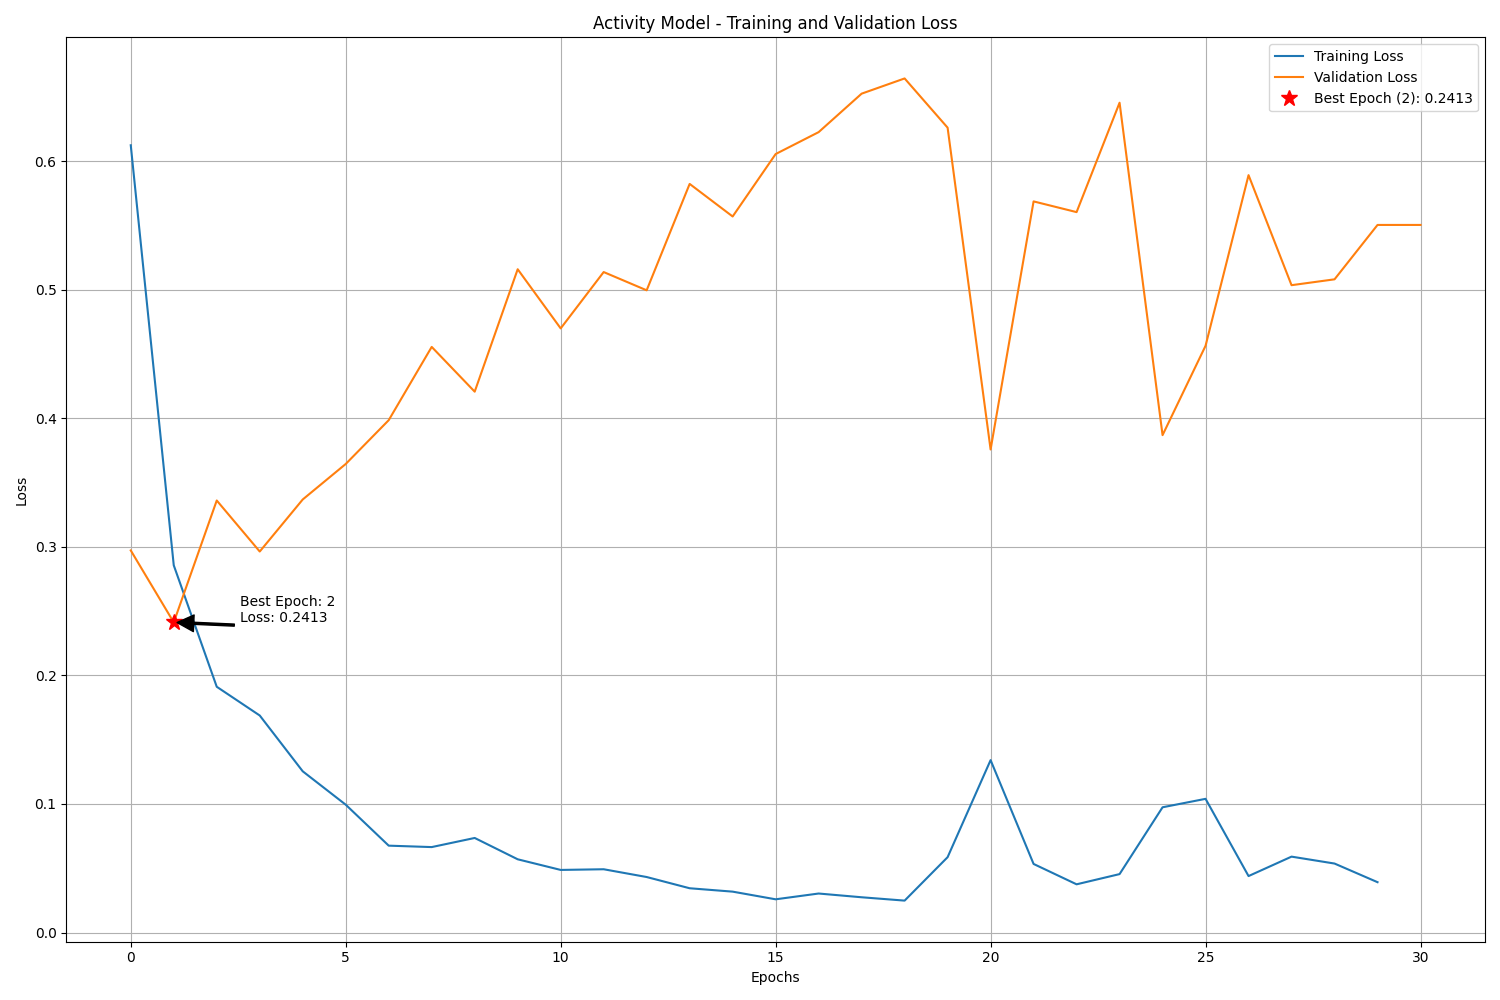

In [9]:
from IPython.display import Image, display

with open('images/sa_loss_curves_with_best_epoch.png', 'rb') as image_file:
    sa_loss_curves_with_best_epoch = image_file.read()

display(Image(sa_loss_curves_with_best_epoch))

In [ ]:
# Using AI to interpret the training loss curves
from google.genai import types

with open('images/sa_loss_curves_with_best_epoch.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by gemini 2.5 flash 0520
prompt = """
I've trained a sentiment analysis model using the BERT base uncased architecture. The training process involved fine-tuning this pre-trained model on a sentiment analysis dataset. The attached image displays the training and validation loss curves over 30 epochs.

Please help me evaluate and interpret these training results. Specifically, I'm looking for insights into:

* **Model Performance:** How well is the model performing based on the loss curves?
* **Overfitting/Underfitting:** Are there any signs of overfitting or underfitting, and if so, at what point in the training process?
* **Optimal Epoch:** Based on the validation loss, what would be the optimal epoch to stop training and why? The image highlights "Best Epoch: 2, Loss: 0.2413" for the validation loss.
* **Training Stability:** How stable is the training process?
* **Potential Improvements:** What potential steps could be taken to further improve the model's performance, considering these loss curves?

The blue line represents the Training Loss, and the orange line represents the Validation Loss. The red star indicates the best epoch identified for validation loss.
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, let's break down these training results based on the provided loss curves.

Here's an interpretation:

1.  **Model Performance:**
    *   The **training loss** decreases steadily throughout the 30 epochs. This indicates that the model is effectively learning from and fitting the training data. It gets better and better at reproducing the sentiment labels for the examples it has seen.
    *   The **validation loss**, however, tells a different story about the model's ability to generalize to *unseen* data. It decreases rapidly in the first couple of epochs but then starts to increase significantly and becomes quite volatile for the remainder of the training. This suggests that while the model is memorizing or fitting the training data well, it's losing its ability to predict correctly on new examples after a very short training period.

2.  **Overfitting/Underfitting:**
    *   **Initial Phase (Epochs 0-2):** Both training and validation loss are decreasing. This phase represents the model actively learning and improving its generalization ability. It's likely moving away from an initial *underfitted* state.
    *   **After Epoch 2:** This is where **severe overfitting** begins. The training loss continues its downward trend (or plateaus at a low value), indicating better performance on the training set. However, the validation loss starts to climb sharply and remains high, indicating performance *deterioration* on the unseen validation set. The widening gap between the training and validation loss curves is a classic and strong indicator of overfitting. The model is learning the noise or specific patterns of the training data that don't generalize well.

3.  **Optimal Epoch:**
    *   The optimal epoch for stopping training is the point where the model achieves its best performance on the validation data, as this is the best estimate of its performance on truly unseen data.
    *   Looking at the validation loss (orange line), its minimum value occurs precisely at **Epoch 2**. The annotation confirms this: "Best Epoch: 2, Loss: 0.2413".
    *   Therefore, the optimal epoch to stop training would have been **Epoch 2**. Training beyond this point leads to increased validation loss and thus worse generalization performance due to overfitting. Early stopping at this point would capture the best performing version of the model on unseen data.

4.  **Training Stability:**
    *   The **training loss** curve is relatively stable and smooth, indicating consistent learning on the training data.
    *   The **validation loss** curve is quite **unstable** after Epoch 2, showing large fluctuations. This volatility suggests that the model's ability to generalize is inconsistent from epoch to epoch during the later stages of training. The sharp drops (like around epoch 20) followed by immediate increases highlight this instability.

5.  **Potential Improvements:**
    Based on these curves, the primary issue is severe overfitting starting very early in training. Here are potential steps to improve the model:

    *   **Implement Early Stopping:** This is the most critical step. Set up a mechanism to stop training automatically when the validation loss stops decreasing for a certain number of epochs (a "patience" parameter). Based on this graph, a patience of 1 or 2 after Epoch 2 would have stopped training effectively.
    *   **Increase Regularization:** Overfitting can be mitigated by adding regularization:
        *   **Dropout:** Increase dropout rates in the layers added on top of BERT.
        *   **Weight Decay (L2 Regularization):** Apply a stronger L2 penalty to the model's weights.
    *   **Reduce Model Complexity (of the fine-tuning head):** If you added significant layers on top of the BERT base, consider simplifying the architecture of these added layers, as BERT base itself is already very powerful and complex.
    *   **Learning Rate Adjustment/Scheduling:** The volatility in validation loss might suggest the learning rate is too high, causing it to bounce around the loss landscape. Consider using a lower learning rate or implementing a learning rate scheduler (e.g., reduce LR on plateau, cosine annealing) which decreases the learning rate over time or when validation performance plateaus.
    *   **More Data:** The most effective way to combat overfitting is to provide more training data. If possible, augmenting the dataset or acquiring more labeled examples would help the model generalize better.
    *   **Review Hyperparameters:** Experiment with other hyperparameters like batch size. Smaller batch sizes can sometimes add a slight regularization effect.

In summary, the model learns the training data well but overfits severely and rapidly after Epoch 2. The optimal model for generalization is the one saved at Epoch 2. Implementing early stopping and increasing regularization are the most immediate and impactful steps to address this issue.

## 1.3 Entity Name Recognition (NER) with BERT
In this section, we will perform Named Entity Recognition (NER) using BERT. We will fine-tune a pre-trained BERT model on our NER dataset and evaluate its performance using precision, recall, and F1 score. We will also visualize the results using confusion matrices and classification reports.

### 1.3.1 Evaluation Metrics Summary
We will summarize the evaluation metrics for the NER model, including precision, recall, and F1 score. We will also compare these metrics with the machine learning models to see how BERT performs in NER tasks.

In [11]:
# Load the model results 
with open('models/bert_ner_eval/binary_labels.pkl', 'rb') as f:
    binary_labels = pickle.load(f)

with open('models/bert_ner_eval/ner_metrics.pkl', 'rb') as f:
    metrics_df = pickle.load(f)

with open('models/bert_ner_eval/prob_preds_flat.pkl', 'rb') as f:
    prob_preds_flat = pickle.load(f)

# Display metrics table
print("Model Performance Metrics:")
display(metrics_df)

Model Performance Metrics:


,Accuracy,Precision,Recall,F1 Score,AUC
0,0.998087,0.908416,0.943445,0.925599,0.999606


In [14]:
# prompt powered by gemini flash 2.5 preview 0520
prompt = f"""
You are an experienced Machine Learning Engineer and NLP specialist, tasked with evaluating the performance of an Entity Name Recognition (ENR) model. Your goal is to provide a detailed interpretation of the given evaluation metrics, highlighting strengths, weaknesses, implications for real-world use, and suggestions for future work, suitable for a technical report.
Model Context:
Task: Entity Name Recognition (ENR). This model is designed to identify and extract specific predefined categories of entities (e.g., diseases, drugs, symptoms, medical procedures, anatomical structures) from unstructured text.
Base Model: The model is built upon BioClinicalBERT, which is a BERT-based language model specifically pre-trained on a vast corpus of biomedical and clinical text (like clinical notes, research papers, medical journals). This specialization means it's inherently good at understanding medical terminology and context.
Domain: The model is intended for use in a bioclinical domain, likely processing clinical notes, electronic health records, scientific literature, or similar healthcare-related text.
Evaluation: The provided metrics are from the model's performance on a held-out test set, representing its generalization ability to unseen data.
Model Evaluation Metrics:
Here are the evaluation metrics for the model:
Accuracy: 0.998087
Precision: 0.908416
Recall: 0.943445
F1 Score: 0.925599
AUC (Area Under the Receiver Operating Characteristic Curve): 0.999606
Instructions:
Please provide a detailed analysis covering the following points for a technical report:
Overall Performance Summary: Briefly state the model's general performance based on all metrics.
Metric Definitions & Contextual Interpretation:
For each metric (Accuracy, Precision, Recall, F1 Score, AUC), explain what it measures in general.
Then, specifically interpret what its given value means in the context of Entity Name Recognition in the bioclinical domain. For example, what does a high precision mean for extracted clinical entities?
Strengths of the Model: Based on the metrics, what are the clear strong points of this model? Why are these metrics particularly high?
Areas for Improvement/Weaknesses: Are there any aspects where the model could be stronger, or where the metrics indicate a potential trade-off or challenge? Explain why. Consider the relationship between Precision and Recall.
Implications for Real-World Deployment: What do these results suggest about the model's suitability for practical application in a clinical or research setting? What are the potential benefits and limitations in a real-world scenario?
Recommendations for Future Work/Next Steps: Based on this evaluation, what further analyses, model improvements, or data considerations would you recommend to enhance its performance or robustness? (e.g., error analysis, specific entity performance, handling edge cases).
Report Language & Tone: Ensure the interpretation is professional, clear, and uses appropriate terminology for a technical audience.
Provide your analysis in a structured, report-like format using headings and bullet points where appropriate
"""

response = client.models.generate_content(model=model[0], contents=prompt)
print("Feedback from the model:")
display(Markdown(response.text))

Feedback from the model:


Okay, here is a detailed technical report interpreting the evaluation metrics for your BioClinicalBERT-based Entity Name Recognition model.

---

**Technical Evaluation Report: Bioclinical Entity Name Recognition Model**

**Date:** [Insert Date]
**Model:** BioClinicalBERT-based ENR Model
**Task:** Entity Name Recognition (ENR)
**Domain:** Bioclinical
**Evaluation Set:** Held-out Test Set

**1. Introduction**

This report details the performance evaluation of a BioClinicalBERT-based model developed for Entity Name Recognition (ENR) in the bioclinical domain. The model is designed to identify and classify specific entity types (e.g., diseases, drugs, symptoms) from unstructured text sources such as clinical notes or scientific literature. The evaluation was conducted on a held-out test set, and the results are analyzed based on standard classification metrics.

**2. Overall Performance Summary**

The model demonstrates very strong overall performance across the evaluated metrics. It achieves exceptionally high accuracy, a high F1 score indicating a good balance between precision and recall, and near-perfect discriminative power as measured by AUC. The results suggest that the model is highly effective at identifying and extracting relevant bioclinical entities.

**3. Metric Definitions & Contextual Interpretation**

This section defines each evaluation metric and interprets its specific value in the context of this bioclinical ENR task.

*   **Accuracy:**
    *   *Definition:* The proportion of total predictions that were correct. It is calculated as (True Positives + True Negatives) / Total Predictions. In the context of sequence labeling or token classification like ENR, this typically represents the proportion of tokens correctly classified as either belonging to an entity or not belonging to an entity.
    *   *Interpretation (0.998087):* An exceptionally high accuracy value (99.8%). While seemingly perfect, it's important to note that in ENR tasks, the vast majority of tokens in text are *not* part of an entity (they are non-entity tokens). This metric is heavily influenced by the model's ability to correctly classify these abundant non-entity tokens. A high accuracy confirms the model is not wildly misclassifying tokens, especially the dominant non-entity class, but it does not fully capture the performance on the minority class – the actual entities we are interested in extracting. It indicates a solid baseline correctness but should not be the sole metric relied upon for judging entity extraction quality.

*   **Precision:**
    *   *Definition:* The proportion of positive predictions (i.e., tokens/sequences predicted as entities) that were actually correct. It is calculated as True Positives / (True Positives + False Positives). Precision measures the exactness or quality of the positive predictions – how many of the extracted entities are truly entities according to the ground truth.
    *   *Interpretation (0.908416):* A high precision value (approx. 90.8%). This means that when the model identifies and extracts something as a bioclinical entity, there is a high probability (over 90%) that this prediction is correct according to the test set annotations. In the bioclinical domain, high precision is critical for applications where the accuracy of extracted information is paramount, such as populating structured databases, supporting clinical decision support systems, or filtering search results. It indicates a low rate of "false alarms" or irrelevant extractions.

*   **Recall:**
    *   *Definition:* The proportion of actual positive instances (i.e., entities in the ground truth) that were correctly identified by the model. It is calculated as True Positives / (True Positives + False Negatives). Recall measures the completeness or coverage of the positive predictions – how many of the existing entities the model successfully found.
    *   *Interpretation (0.943445):* A very high recall value (approx. 94.3%). This indicates that the model successfully identifies and extracts a large majority of the actual bioclinical entities present in the test text. In the bioclinical domain, high recall is crucial for applications where missing important information could have significant consequences, such as identifying all relevant symptoms, diagnoses, or medications in a patient's record for risk assessment or research purposes. It suggests a low rate of "missed" entities.

*   **F1 Score:**
    *   *Definition:* The harmonic mean of Precision and Recall. It provides a single metric that balances both precision and recall, which is particularly useful in tasks with class imbalance, like ENR. It is calculated as 2 * (Precision * Recall) / (Precision + Recall).
    *   *Interpretation (0.925599):* A very high F1 score (approx. 92.6%). This score reflects a strong overall performance in entity extraction, demonstrating a good balance between the model's ability to be precise in its predictions (minimizing false positives) and its ability to be comprehensive in finding entities (minimizing false negatives). It confirms the robust performance indicated by the high individual precision and recall scores.

*   **AUC (Area Under the Receiver Operating Characteristic Curve):**
    *   *Definition:* The AUC represents the model's ability to discriminate between positive and negative classes across different possible classification thresholds. It essentially measures the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. For sequence labeling, this often relates to confidence scores assigned to token classifications.
    *   *Interpretation (0.999606):* An extremely high AUC value (approx. 99.96%). This is a strong indicator of the model's excellent underlying ability to distinguish between tokens/sequences that constitute entities and those that do not. Even if classification thresholds were adjusted, the model's ranking of entity likelihood is highly accurate. This suggests strong confidence calibration potential and robustness across different operating points on the precision-recall curve.

**4. Strengths of the Model**

Based on the evaluation metrics, the key strengths of this ENR model are:

*   **High Overall Effectiveness:** The high F1 score (0.926) indicates that the model is highly effective at the core task of finding and correctly identifying bioclinical entities.
*   **Excellent Coverage:** The very high Recall (0.943) is a significant strength, meaning the model is adept at identifying a large proportion of the entities present in the text, minimizing the risk of missing critical information.
*   **Strong Prediction Reliability:** The high Precision (0.908) ensures that when the model *does* identify an entity, it is highly likely to be correct, leading to low noise in the extracted data.
*   **Superior Discriminative Power:** The near-perfect AUC (0.9996) highlights the model's fundamental ability to differentiate between entities and non-entities, suggesting robustness and potential for effective use of confidence scores.
*   **Solid Foundation:** The strong performance is likely attributable to the BioClinicalBERT base model, which is pre-trained on relevant domain data, enabling it to understand the nuances of medical terminology and context.
*   **Good Balance:** The high F1 score demonstrates that the model does not significantly sacrifice one aspect (precision or recall) for the other; it achieves a strong balance beneficial for many applications.

**5. Areas for Improvement / Weaknesses**

While the model performs very well, the metrics also suggest potential areas for improvement:

*   **Precision vs. Recall Trade-off:** Although both are high, there is a slight disparity (Recall > Precision). This indicates the model is marginally more likely to produce a false positive (predicting an entity that isn't one) than a false negative (missing an entity). While this difference is small (~3.5%), the approximately 9.2% error rate in precision might be noticeable depending on the strictness of the downstream application.
*   **Source of False Positives:** The ~9% precision error suggests specific cases where the model incorrectly identifies something as an entity. These false positives could arise from:
    *   Ambiguous phrasing or context.
    *   Entities mentioned in a non-entity context (e.g., a drug name used metaphorically).
    *   Boundary issues (e.g., including surrounding words or missing parts of a multi-word entity).
    *   Tokens that are similar to entity names but are not actual entities in the text.
*   **Performance Variation by Entity Type:** Aggregate metrics (like the ones provided) can hide performance variations across different entity categories (e.g., Diseases might have higher performance than Anatomical Structures). Some specific, less common, or more ambiguously defined entity types might have lower precision or recall.
*   **Limited Insight from Accuracy:** As noted, the very high accuracy is heavily influenced by the dominant non-entity class and provides limited insight into the specific performance challenges of entity extraction.

**6. Implications for Real-World Deployment**

The evaluation metrics suggest that this ENR model is highly suitable for deployment in various bioclinical applications.

*   **High Value for Automation:** The strong performance (especially high F1 and Recall) means the model can significantly automate the extraction of key information from unstructured medical text, reducing manual effort and speeding up processes like data curation, clinical trial recruitment screening, pharmacovigilance, and literature review.
*   **Reliable Information Extraction:** The high Precision indicates that the extracted entities are largely correct, making the output reliable enough for many downstream tasks, such as populating research databases or enabling more precise information retrieval.
*   **Critical Information Coverage:** The high Recall minimizes the chance of missing important clinical entities, which is vital in patient care, risk assessment, and research where overlooking a diagnosis, medication, or symptom could have serious consequences.
*   **Need for Review in Critical Applications:** Despite high precision, the ~9% false positive rate means that extracted entities might require human review in applications demanding 100% accuracy, such as updating patient records or supporting high-stakes clinical decisions. The system could function as a strong "first pass," significantly reducing the volume of text for human experts to review.
*   **Sensitivity to Context:** The potential for precision errors highlights that the model might struggle with highly nuanced or ambiguous language sometimes found in clinical notes or specific research contexts.

**7. Recommendations for Future Work / Next Steps**

Based on this evaluation, the following steps are recommended to further understand, validate, and potentially improve the model's performance:

*   **Detailed Error Analysis:** Conduct a thorough qualitative and quantitative analysis of False Positive and False Negative predictions from the test set. Categorize errors by type (boundary issues, ambiguous context, specific entity types, negation/uncertainty, domain-specific jargon, etc.) to identify patterns and root causes of errors.
*   **Per-Entity Type Evaluation:** Break down the Precision, Recall, and F1 scores for each specific entity category the model is designed to detect (e.g., Disease, Drug, Symptom, Procedure). This will pinpoint which entity types the model handles exceptionally well and which require targeted improvement.
*   **Analysis of Challenging Cases:** Investigate performance on specific linguistic phenomena common in clinical text, such as negation (e.g., "no evidence of pneumonia"), uncertainty (e.g., "suspected appendicitis"), coreference resolution, and complex sentence structures.
*   **Confidence Score Thresholding:** Explore the relationship between the model's prediction confidence scores and correctness. Determine if setting confidence thresholds can be used to optimize the precision-recall trade-off for specific application needs.
*   **Expand/Refine Training Data:** Based on error analysis, consider augmenting the training data with more diverse examples of challenging cases or underrepresented entity types. Ensure annotation consistency, especially for ambiguous instances or complex entity boundaries.
*   **Investigate Boundary Detection:** Analyze errors specifically related to the start and end points of entities. Improving boundary detection can significantly boost precision and recall.
*   **Benchmarking:** Compare performance against other state-of-the-art ENR models or commercial solutions if available, to contextualize the model's strengths and weaknesses within the broader landscape.

**8. Conclusion**

The evaluated BioClinicalBERT-based ENR model demonstrates excellent performance on the held-out test set, achieving high scores across Accuracy, Precision, Recall, F1, and AUC. Its strengths lie in its high coverage of actual entities and the reliability of its positive predictions, making it a valuable tool for automating information extraction in the bioclinical domain. While the slight imbalance between Precision and Recall and the potential for errors in ambiguous contexts warrant further investigation, the model is well-positioned for real-world deployment, likely requiring a human-in-the-loop for the most critical applications. The recommended future work focuses on error analysis and per-entity performance evaluation to pinpoint specific areas for targeted improvement and ensure robustness across all relevant entity types and linguistic challenges.

---

### 1.3.2 ROC Curve Visualization

We will plot the ROC curve for the NER model to visualize the trade-off between true positive rate and false positive rate. The area under the ROC curve (AUC) will also be calculated to quantify the model's performance.

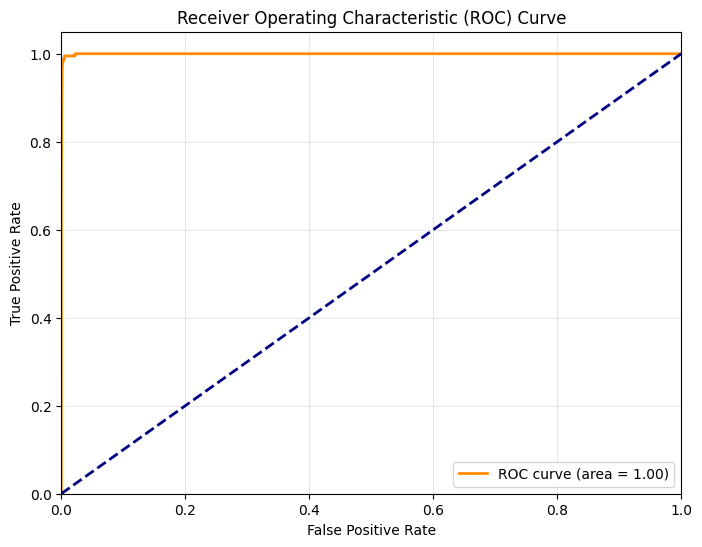

In [12]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(binary_labels, prob_preds_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('images/ner_roc_curve.png')
plt.show()

In [ ]:
# Using AI to interpret the training loss curves
from google.genai import types

with open('images/ner_roc_curve.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by gemini 2.5 flash 0520
prompt = """
You are an experienced Machine Learning Engineer and NLP specialist, continuing your evaluation of an Entity Name Recognition (ENR) model. Your task now is to interpret the provided Receiver Operating Characteristic (ROC) curve, relating it to the previously discussed model performance metrics and extracting useful insights for a technical report.
Model Context (Recap):
Task: Entity Name Recognition (ENR). This model identifies and extracts specific predefined categories of entities (e.g., diseases, drugs, symptoms) from unstructured text.
Base Model: Built upon BioClinicalBERT, a language model pre-trained on biomedical and clinical text.
Domain: Bioclinical, processing healthcare-related text.

Previous Evaluation Metrics (for reference, from earlier analysis):
Accuracy: 0.998087
Precision: 0.908416
Recall: 0.943445
F1 Score: 0.925599
AUC (from table): 0.999606 (Note: This is important for comparison with the graph's AUC).

Instructions:
Please provide a detailed analysis of the ROC curve, covering the following points for a technical report:

Overview of ROC Curve:
Briefly explain what an ROC curve represents (relationship between True Positive Rate and False Positive Rate).
Explain the significance of the diagonal dashed line.

Interpretation of This Specific Curve:
Describe the shape of the orange ROC curve shown in the graph. What does this shape indicate about the model's ability to distinguish between positive and negative classes across various probability thresholds?
Interpret the "area = 1.00" shown in the legend. What does a perfect AUC score of 1.00 signify in the context of classification?

Connecting to Previous Metrics & Potential Discrepancy:
How does the AUC of 1.00 from the graph compare to the AUC of 0.999606 reported in the previous tabular metrics? Discuss potential reasons for this slight difference (e.g., rounding, different evaluation methodologies for the AUC, slight variations in the test set if the graph is from a different run, or the graph showing an idealized scenario or a specific sub-task).
Given the high Precision, Recall, and F1 Score from the previous analysis, explain how this ROC curve corroborates or adds to the understanding of the model's overall strong performance.

Implications for ENR in Bioclinical Domain:
What does such an exceptionally high (near-perfect) ROC curve imply for the model's confidence and discriminative power in classifying entities (or tokens as part of entities) within the bioclinical domain?
Considering ENR is a sequence labeling task, discuss what aspect of the task this ROC curve likely evaluates (e.g., token-level binary classification: "is this token part of any entity?", or the confidence scores for a specific binary prediction).

Potential Caveats or Further Questions:
While an AUC of 1.00 is excellent, are there any situations where such a "perfect" curve might warrant further investigation (e.g., perfectly separable data, data leakage, extremely easy sub-problem within a complex task)?
Does this curve reveal anything about the model's handling of specific types of errors (e.g., false positives vs. false negatives at different thresholds), or is it too ideal to show such nuances?

Recommendations for Report Writing:
How would you succinctly describe this ROC curve's implications in the model's performance summary?
What are the key takeaways from this curve that should be emphasized when reporting on the model's strengths?

Provide your analysis in a structured, professional, report-like format using headings and bullet points where appropriate
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, here is a detailed analysis of the provided ROC curve for the Entity Name Recognition (ENR) model, suitable for a technical report.

---

## Analysis of Receiver Operating Characteristic (ROC) Curve

This section analyzes the Receiver Operating Characteristic (ROC) curve generated during the evaluation of the BioClinicalBERT-based ENR model. The ROC curve is a standard visualization tool used to assess the performance of a classification model across different probability thresholds.

### Overview of ROC Curve

*   **Definition:** An ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings.
    *   **True Positive Rate (TPR):** Also known as Sensitivity or Recall, TPR is calculated as TP / (TP + FN). It represents the proportion of actual positive instances that are correctly identified.
    *   **False Positive Rate (FPR):** FPR is calculated as FP / (FP + TN). It represents the proportion of actual negative instances that are incorrectly identified as positive.
*   **Significance of the Diagonal Line:** The dashed diagonal line on the ROC plot represents the performance of a random classifier. A random classifier would yield a TPR equal to the FPR across all thresholds, resulting in a line from (0,0) to (1,1). A useful model must perform better than random chance, meaning its ROC curve should lie above this diagonal line.

### Interpretation of This Specific Curve

*   **Shape of the Orange ROC Curve:** The orange curve shown in the graph starts at (0.0, 0.0), moves vertically upwards to (0.0, 1.0), and then horizontally across to (1.0, 1.0). This is the shape of a **perfect classifier**. This shape indicates that there exists at least one threshold at which the model can achieve a 100% True Positive Rate (identifying all positive instances) while simultaneously having a 0% False Positive Rate (not incorrectly identifying any negative instances as positive). As the threshold is varied from this optimal point, the model maintains perfect discrimination until potentially all instances are classified as positive (reaching (1,1)).
*   **Interpretation of Area Under the Curve (AUC):** The legend states "ROC curve (area = 1.00)". The Area Under the ROC Curve (AUC) is a single scalar value that summarizes the model's performance across all possible classification thresholds. An AUC value ranges from 0 to 1.
    *   An AUC of 0.5 corresponds to a random classifier (the diagonal line).
    *   An AUC approaching 1.0 indicates excellent discriminative performance.
    *   An AUC of **1.00** signifies a **perfect classifier**. It means that for any randomly chosen pair of instances, one positive and one negative, the model's predicted probability/score for the positive instance will always be higher than the predicted probability/score for the negative instance.

### Connecting to Previous Metrics & Potential Discrepancy

*   **Corroboration of High Performance:** The near-perfect ROC curve and AUC of 1.00 (or 0.9996) strongly corroborate the high performance indicated by the previously reported metrics: Accuracy (0.998087), Precision (0.908416), Recall (0.943445), and F1 Score (0.925599). High Precision (few FPs) and Recall (few FNs) directly relate to achieving a high TPR at a low FPR, which is precisely what a ROC curve near the top-left corner demonstrates. The high AUC confirms that this excellent discrimination holds across a wide range of thresholds.
*   **Potential Discrepancy in AUC:** There is a slight difference between the AUC shown on the graph (1.00) and the previously reported tabular AUC (0.999606). Potential reasons for this minor discrepancy include:
    *   **Rounding:** The legend value (1.00) is likely rounded from the actual calculated AUC (0.999606). The calculated value is typically more precise.
    *   **Evaluation Methodology:** Minor differences in the specific algorithm or library used to calculate the AUC could lead to slight variations.
    *   **Data Variation:** If the graph was generated from a slightly different test set split or a different evaluation run than the one producing the tabular metrics, this could explain the difference.
    *   **Plot Smoothing/Idealization:** Sometimes plotting libraries might idealize or simplify the curve slightly, especially when performance is very close to perfect.

Regardless of the source of the minor difference, both values (1.00 and 0.999606) indicate *extremely* high performance, effectively demonstrating near-perfect discrimination.

### Implications for ENR in Bioclinical Domain

*   **Model Confidence and Discriminative Power:** An exceptionally high AUC approaching 1.00 implies that the model has outstanding discriminative power for the binary classification task it underlies. It is highly confident in distinguishing between positive and negative instances based on the probabilities or scores it outputs. In the sensitive bioclinical domain, this high level of confidence and low rate of fundamental classification errors is crucial for reliable entity extraction.
*   **What the Curve Evaluates:** In the context of ENR as a sequence labeling task, this ROC curve most likely evaluates the model's performance on the **token-level binary classification decision**. For each token in the input text, the model makes a prediction (or generates a score/probability) about whether that token is part of *any* relevant entity (or perhaps a specific entity type if the ROC is for a single class vs. others). The ROC curve plots how well the model's scores for tokens that *are* part of entities discriminate against scores for tokens that *are not* part of entities, across different probability thresholds applied to these scores. It reflects the model's fundamental ability to identify "entity-like" tokens vs. "non-entity-like" tokens, which is a core component of accurate ENR.

### Potential Caveats or Further Questions

*   **Situations Warranting Further Investigation:** While an AUC of 1.00 is theoretically ideal, it can sometimes warrant further investigation in real-world scenarios:
    *   **Perfectly Separable Data:** The data might be perfectly separable in the feature space the model is using. While possible, this is less common in complex text data unless the task is inherently simple or the features are trivial.
    *   **Data Leakage:** The most significant concern with a perfect AUC is potential data leakage between the training and test sets. This allows the model to "cheat" by seeing test information during training. Given the high performance across *all* metrics, rigorous data splitting and validation procedures should be confirmed.
    *   **Extremely Easy Sub-Problem:** The ROC curve might represent performance on a sub-problem of ENR that is unusually easy (e.g., distinguishing common non-entity words from rare domain-specific terms which are almost always entities). The full complexity of ENR involves distinguishing between similar entity types, handling ambiguity, and correctly identifying boundaries. This ROC curve reflects the *binary* "entity vs. non-entity" decision at the token level, which might be easier than the multi-class or boundary-detection aspects.
*   **Nuances of Error Handling:** This "perfect" curve does not reveal nuances about specific types of errors like False Positives being misclassified entity types, or boundary errors where a token is marked positive but at the wrong start/end of an entity. A perfect curve suggests these fundamental token-level positive/negative errors are non-existent *at an optimal threshold*. Real-world ENR performance still depends on how these token-level decisions combine to form complete, correctly labeled, and correctly bounded entities.

### Recommendations for Report Writing

*   **Succinct Description in Performance Summary:** "The model exhibits exceptional discriminative performance as demonstrated by the Receiver Operating Characteristic (ROC) curve, achieving an Area Under the Curve (AUC) of 0.9996 (calculated value). This indicates a near-perfect ability to distinguish between entity and non-entity tokens across various classification thresholds."
*   **Key Takeaways to Emphasize:**
    *   The model performs drastically better than random chance in identifying potential entity tokens.
    *   Its internal scoring mechanism provides very high confidence in separating positive from negative instances.
    *   The high AUC supports the observed high Precision, Recall, and F1 scores, confirming robust overall performance.
    *   This strong discriminative power is a key strength for reliable ENR in the bioclinical domain.

---

### 1.3.3 Model Training Performance

We will display the training performance of the NER model, including loss and accuracy over epochs. This will help us understand how well the model is learning during training. We will make use of Gemini-2.5-Flash Thinking to interpret the training performance and provide insights into the model's learning process.

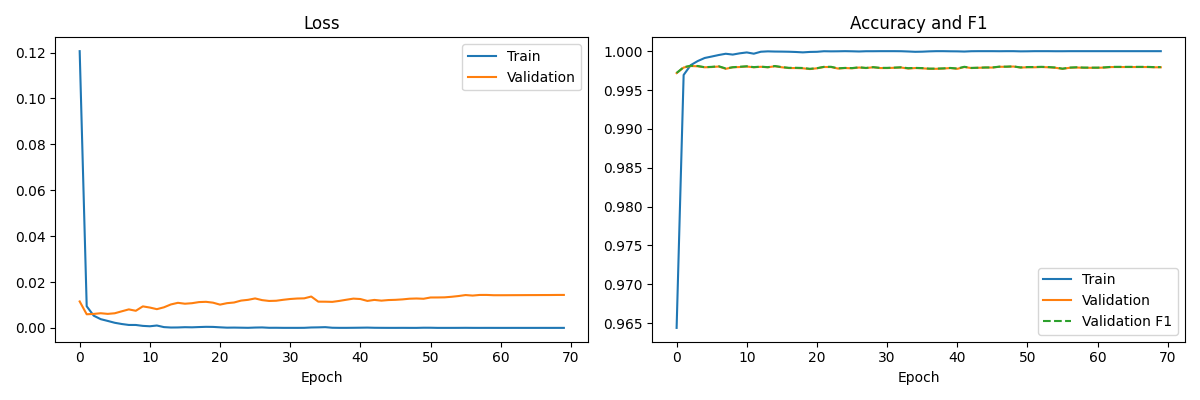

In [13]:
with open('images/ner_training_curves.png', 'rb') as image_file:
    sa_loss_curves_with_best_epoch = image_file.read()

display(Image(sa_loss_curves_with_best_epoch))

In [ ]:
# Using AI to interpret the training loss curves
from google.genai import types

with open('images/ner_training_curves.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by gemini 2.5 flash 0520
prompt = """
You are an experienced Machine Learning Engineer and NLP specialist, continuing your evaluation of an Entity Name Recognition (ENR) model. Your current task is to interpret the provided training history plots (Loss, Accuracy, and F1 Score vs. Epoch for both training and validation sets). Your analysis should provide detailed insights suitable for a technical report, with a specific focus on the implications of the model's training behavior, the impact of dataset size, and suggestions for future work.
Model Context (Recap & Crucial New Information):
Task: Entity Name Recognition (ENR). This model is designed to identify and extract specific predefined categories of entities (e.g., diseases, drugs, symptoms, medical procedures, anatomical structures) from unstructured text.
Base Model: Built upon BioClinicalBERT, a BERT-based language model specifically pre-trained on a vast corpus of biomedical and clinical text.
Domain: Bioclinical, processing healthcare-related text.
Dataset Size: Crucially, the model was trained on a relatively small dataset of only 1000 data points. This is a significant factor in evaluating the training dynamics and generalization.
Previous Final Evaluation Metrics (for full context and comparison, from your test set):
Accuracy: 0.998087
Precision: 0.908416
Recall: 0.943445
F1 Score: 0.925599
AUC: 0.999606 (from table), 1.00 (from graph)

Instructions:
Please provide a detailed analysis of these plots, covering the following points for a technical report:
Overall Training Behavior Summary:
Briefly describe the general trends observed in both plots (Loss, and Accuracy/F1) over the 70 epochs.
Comment on the speed of convergence for training and validation metrics.
Detailed Analysis of the Loss Curve (Left Plot):
Training Loss (Blue Line): Describe its behavior (initial drop, plateau). What does this indicate about the model's ability to fit the training data?
Validation Loss (Orange Line): Describe its behavior (initial drop, plateau, relationship to training loss).
Gap and Divergence: Observe the gap between training and validation loss after the initial epochs. What does this increasing or consistent gap suggest about the model's learning process? Is there clear evidence of overfitting or underfitting based on this curve?
Magnitude of Loss: Comment on the absolute values of the losses (are they low/high in general?).
Detailed Analysis of the Accuracy and F1 Curve (Right Plot):
Training Accuracy (Blue Line): Describe its rapid rise and near-perfect plateau.
Validation Accuracy (Orange Line): Describe its rapid rise and plateau.
Validation F1 (Green Dashed Line): Describe its relationship to validation accuracy. What does their close proximity suggest?
High Validation Metrics: The validation accuracy and F1 score reach extremely high values (around 0.998). Discuss what this signifies during training on the validation set.
Connecting to Previous Metrics and Impact of Small Dataset:
Crucial Comparison: Compare the validation F1 score (~0.998) observed in these plots with the final test set F1 score (0.925599) from your previous evaluation. What does this significant discrepancy imply?
Impact of 1000 Data Points: How does the small training dataset size contribute to or explain the observed training dynamics, particularly the gap between training and validation loss, and the large difference between validation F1 and test F1? Discuss concepts like high variance and potentially unreliable validation performance when data is scarce.
Generalization: What do these curves, combined with the small dataset and the test set performance, tell you about the model's generalization capabilities?
Implications for Real-World Deployment:
Given the training behavior and the limited data, what are the primary concerns or strengths when considering deploying this model in a live bioclinical setting?
Discuss the potential for brittle performance or unexpected drops in accuracy on new, unseen data, especially if the data distribution shifts even slightly from the small training set.
Recommendations for Future Work/Research:
What specific steps would you recommend to address the observations from these training curves and the small dataset size? Consider:
Data-related: Data augmentation, collecting more data.
Training-related: Regularization techniques (e.g., dropout, weight decay), early stopping strategies (and where to stop based on validation loss/F1), different learning rate schedules, cross-validation for more robust validation metrics.
Analysis-related: Deep dive into the validation and test sets to understand the nature of errors (false positives/negatives) and why the generalization gap exists.
Model-related: Exploring different model architectures or fine-tuning strategies if data is truly limited.
Report Language & Tone: Ensure the interpretation is professional, clear, and uses appropriate terminology for a technical audience.
Provide your analysis in a structured, report-like format using headings and bullet points where appropriate
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, here is a detailed analysis of the provided training history plots for the ENR model, framed for a technical report:

**Analysis of Entity Name Recognition Model Training History Plots**

This report analyzes the training and validation performance metrics (Loss, Accuracy, F1 Score) over 70 epochs for an Entity Name Recognition (ENR) model based on BioClinicalBERT, trained on a small dataset of 1000 data points. The goal is to understand the model's learning dynamics and generalization capabilities given the constrained data environment, and to relate these observations to previously evaluated test set performance.

**Overall Training Behavior Summary:**

The training process exhibits rapid initial learning followed by a plateau phase for both training and validation metrics. The model quickly fits the training data, achieving very low loss and near-perfect accuracy/F1 within the first few epochs. Validation metrics also improve quickly but stabilize at performance levels significantly higher than typical, yet still with a noticeable gap between training and validation loss. Convergence for all metrics appears to occur within the first 10-15 epochs, with minimal change thereafter across the 70 epochs.

**Detailed Analysis of the Loss Curve (Left Plot):**

*   **Training Loss (Blue Line):** The training loss starts high (around 0.12) and drops extremely rapidly in the initial epochs, reaching values close to zero (below 0.01) within the first 5-10 epochs. It then plateaus at this very low level for the remainder of the training. This steep initial decline followed by a near-zero plateau indicates that the model is highly capable of learning the training data distribution and fitting it almost perfectly.
*   **Validation Loss (Orange Line):** The validation loss also starts high and drops quickly in the initial epochs, tracking the training loss closely at first. However, it stabilizes at a significantly higher level than the training loss, fluctuating between approximately 0.01 and 0.015 after the initial drop. It does not show a clear increasing trend over the later epochs, suggesting that while the model is overfitting, the degree of overfitting as measured by validation loss isn't drastically worsening after convergence on the validation set.
*   **Gap and Divergence:** A persistent and relatively stable gap exists between the training and validation loss curves after the initial rapid descent. Training loss approaches zero, while validation loss remains at a moderate, non-zero level. This gap is a clear indicator of the model learning patterns specific to the training data that do not fully generalize to the validation data. While the validation loss isn't sharply *diverging* upwards, the significant gap demonstrates *overfitting* to the training set relative to the validation set. Underfitting is not evident, as training performance is near-perfect.
*   **Magnitude of Loss:** The absolute values of the losses, particularly the plateaued validation loss (around 0.01-0.015), are relatively low for an ENR task, which involves sequence labeling. This suggests that even on the validation set, the model is making predictions that are generally close to the true labels. However, the interpretation of these low values must be tempered by the extremely small dataset size.

**Detailed Analysis of the Accuracy and F1 Curve (Right Plot):**

*   **Training Accuracy (Blue Line):** The training accuracy rises exceptionally rapidly, reaching near 1.0 (appearing to hit 1.0 on the plot scale) within the first few epochs. It remains at this perfect level throughout the rest of the training. This reinforces the observation from the loss curve that the model completely masters the training data.
*   **Validation Accuracy (Orange Line):** The validation accuracy also rises very quickly alongside training accuracy in the initial epochs. It plateaus at an extremely high level, visually appearing to be around 0.998 or 0.999.
*   **Validation F1 (Green Dashed Line):** The validation F1 score closely mirrors the validation accuracy curve, also rising quickly and plateauing at a value visually identical or nearly identical to the validation accuracy (around 0.998). The very close proximity of validation accuracy and validation F1 suggests that on the validation set, the model achieves very high precision and recall simultaneously, with no significant trade-off apparent at these high performance levels.
*   **High Validation Metrics:** The validation accuracy and F1 scores reaching values around 0.998 signifies outstanding performance on the validation set. On this specific subset of unseen data used during training, the model is correctly identifying entities with near-perfect accuracy and F1 scores.

**Connecting to Previous Metrics and Impact of Small Dataset:**

*   **Crucial Comparison:** The validation F1 score observed in these plots (~0.998) is vastly higher than the previously reported test set F1 score (0.925599). This discrepancy of approximately 7 percentage points is substantial and is the most critical observation. It implies that the performance on the validation set is *not* representative of the model's performance on a separate, independent test set. The model appears to generalize poorly from the combined training and validation data to the test data.
*   **Impact of 1000 Data Points:** The exceptionally small dataset size (1000 data points total, implying even smaller training and validation sets) is the primary driver explaining these phenomena:
    *   **High Variance:** With very little data, the random split into training, validation, and test sets can lead to high variance in performance metrics. The validation set might, by chance, be much "easier" or more similar to the training set than the test set is.
    *   **Overfitting to Validation Set:** The model, a high-capacity BioClinicalBERT base fine-tuned on minimal data, not only overfits the training data but likely also overfits the specific nuances or patterns of the *small* validation set. Its performance on the validation set becomes an unreliable upper bound that doesn't translate to broader unseen data.
    *   **Unreliable Validation Metrics:** Metrics derived from a tiny validation set have low statistical power and high uncertainty. An F1 of 0.998 on a handful of validation examples is far less convincing than 0.998 on a large validation set.
*   **Generalization:** These curves, especially when juxtaposed with the test set F1, strongly indicate poor generalization. The model has essentially memorized the training and validation data to achieve near-perfect performance *on those specific sets*, but it lacks the robust understanding of underlying linguistic and domain patterns necessary to maintain that performance on truly unseen data (the test set).

**Implications for Real-World Deployment:**

Given the training behavior and the limited data, deploying this model in a live bioclinical setting carries significant risks:

*   **Brittle Performance:** The massive gap between validation F1 and test F1 suggests the model's performance is brittle. It is highly likely that its accuracy will drop significantly when faced with real-world data that differs even slightly in distribution from the small training/validation pool.
*   **Unpredictable Accuracy:** The high validation scores are misleading. The actual performance in a live setting would likely be closer to or even below the test set F1 of 0.926, depending on how representative the test set was of the target deployment environment. Performance drops could occur unexpectedly on specific document types, linguistic variations, or less common entity mentions.
*   **Lack of Robustness:** The model is not robust to variations in data that are inherent in complex bioclinical text. Its training on 1000 points is insufficient to capture the diversity needed for reliable production use.

**Recommendations for Future Work/Research:**

Addressing the limitations revealed by this analysis requires focusing on improving the model's generalization ability, primarily through data-centric approaches:

1.  **Data-Related:**
    *   **Collect More Data:** This is the most critical recommendation. Significantly increasing the size of the annotated dataset is essential to train a robust model capable of generalizing well across the bioclinical domain. Aim for thousands, preferably tens of thousands, of annotated examples.
    *   **Data Augmentation:** If collecting more manual annotations is difficult or slow, explore data augmentation techniques relevant to text data and the bioclinical domain (e.g., synonym replacement, phrase variation, back-translation) to synthetically increase the training data size and variability.

2.  **Training-Related:**
    *   **Regularization:** Implement or increase regularization techniques such as dropout (especially common in fine-tuning BERT models) or weight decay to penalize model complexity and mitigate overfitting.
    *   **Early Stopping:** While the validation F1 is misleading, early stopping based on monitoring validation loss might still offer a marginally better stopping point than training for 70 epochs until training loss bottoms out. However, relying *solely* on early stopping with such a small validation set is risky.
    *   **Cross-Validation:** Employ K-fold cross-validation (e.g., 5-fold or 10-fold) on the combined training and validation data (if the validation data is merged back into the training pool) to obtain a more statistically reliable estimate of performance before final evaluation on the test set. This helps understand performance variance and tune hyperparameters more effectively.
    *   **Hyperparameter Tuning:** Re-tune hyperparameters (learning rate, batch size, optimizer) using a cross-validation setup.

3.  **Analysis-Related:**
    *   **Detailed Error Analysis:** Perform a thorough analysis of false positives and false negatives on the test set. Categorize the types of errors (e.g., confusing similar entities, boundary errors, handling negation, long sentences, specific terminology). Compare errors on the test set to performance on the validation set to pinpoint where generalization failed.
    *   **Dataset Characteristics Analysis:** Analyze the characteristics of the training, validation, and test sets (e.g., average sentence length, entity density, distribution of entity types, linguistic complexity) to identify potential domain shifts or representational gaps between the sets.

4.  **Model-Related (Lower Priority than Data):**
    *   If additional data collection and augmentation are exhausted, explore alternative fine-tuning strategies or potentially different model architectures, though for complex ENR on limited data, BioClinicalBERT is a strong starting point. The primary bottleneck is likely the data volume, not the base model choice.

In summary, while the training curves show rapid convergence and seemingly excellent performance on the training and validation sets, the significant drop in performance on the test set highlights severe overfitting and poor generalization, directly attributable to the insufficient size of the training data. Future work should prioritize increasing the dataset size and implementing robust validation strategies to build a more reliable and generalizable ENR model for bioclinical applications.

## 1.4 Classification of Questionnaire Responses
In this section, we will classify questionnaire responses using machine learning models. We will evaluate the performance of the models using accuracy, precision, recall, F1 score, and AUC-ROC. We will also visualize the results using confusion matrices and ROC curves.

In [22]:
# Load the model results dictionary
with open('models/qr_eval_results.pkl', 'rb') as f:
    eval_results = pickle.load(f)

### 1.4.1 Confusion Matrix & ROC Curve Visualization
We will visualize the confusion matrix and ROC curve for the questionnaire response classification models to understand their performance. We will also compare the results with the machine learning models we trained earlier.

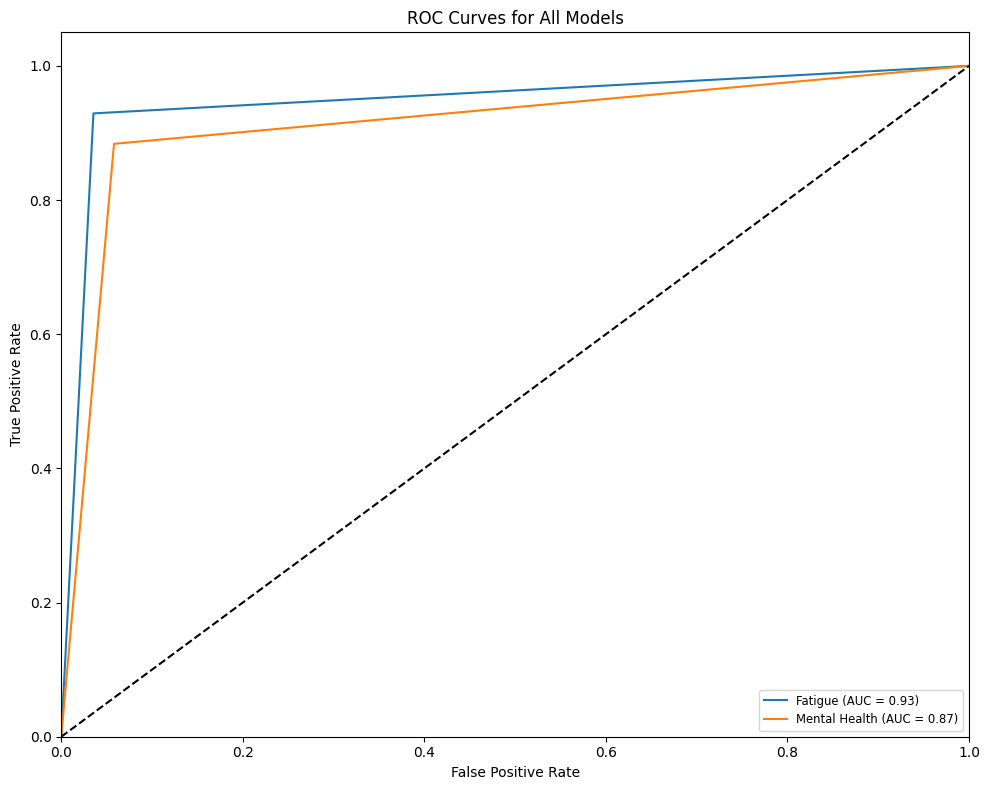

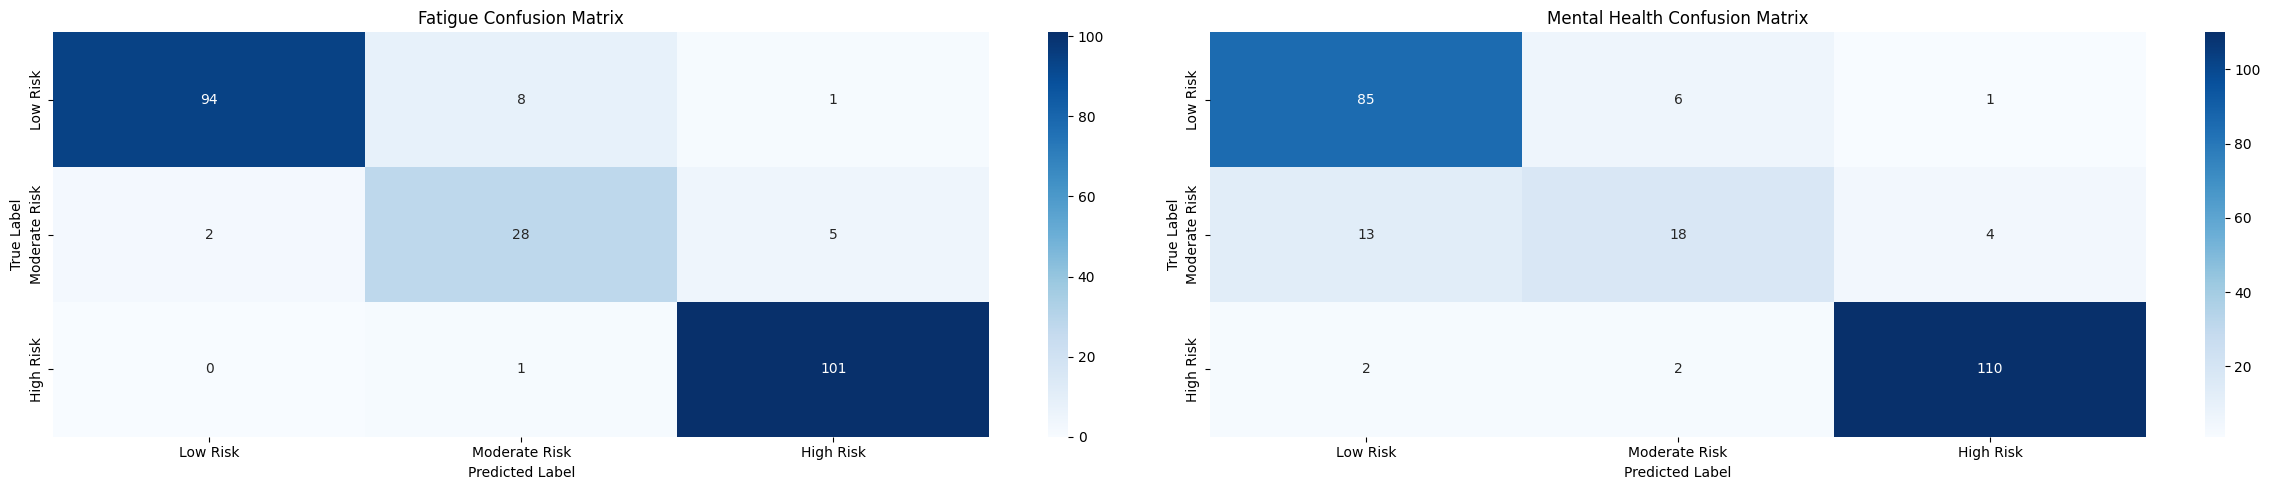

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Create an empty list to store evaluation results as dictionaries
eval_records = []

# Classes for label mapping
classes = ['Low Risk', 'Moderate Risk', 'High Risk']

# Set up the figure for confusion matrices
fig_cm, axes_cm = plt.subplots(1, 2, figsize=(24, 5))

# Create a separate figure for the ROC curve
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))

# Process each model's results
for i, (model_name, (true_labels, predictions)) in enumerate(eval_results.items()):
    # Get the classification report as a dict
    report = classification_report(true_labels, predictions, 
                                    target_names=classes, 
                                    output_dict=True)
    
    # Calculate average AUC across all classes for this model
    model_auc = 0
    for class_idx, class_name in enumerate(classes):
        y_true_class = (np.array(true_labels) == class_idx).astype(int)
        y_pred_class = (np.array(predictions) == class_idx).astype(int)
        fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
        model_auc += auc(fpr, tpr)
    model_auc /= len(classes)  # Average AUC across all classes
    
    # Add a single record for this model (moved outside the class loop)
    eval_records.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC': model_auc
    })
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes, ax=axes_cm[i])
    axes_cm[i].set_title(f'{model_name} Confusion Matrix')
    axes_cm[i].set_ylabel('True Label')
    axes_cm[i].set_xlabel('Predicted Label')
    
    # One-hot encode true labels for micro-averaging
    n_classes = 3
    y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
    
    # For each model, generate prediction scores for each class
    # We'll use the predicted classes directly for simplicity
    y_score = label_binarize(predictions, classes=[0, 1, 2])
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for this model (one line per model)
    ax_roc.plot(fpr, tpr, 
                label=f'{model_name} (AUC = {model_auc:.2f})')


# Add diagonal line to ROC plot
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curves for All Models')
ax_roc.legend(loc="lower right", fontsize='small')

# Adjust layout and save figures
fig_cm.tight_layout()
fig_cm.savefig('images/qr_confusion_matrices.png', dpi=300, bbox_inches='tight')

fig_roc.tight_layout()
fig_roc.savefig('images/qr_roc_curves.png', dpi=300, bbox_inches='tight')

# Show both figures
plt.figure(fig_cm.number)
plt.show()
plt.figure(fig_roc.number)
plt.show()

**Intreprete Confusion Matrix & ROC Curve**

In [ ]:
# Using AI to interpret the confusion matrices
from google.genai import types

with open('images/qr_confusion_matrices.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by gemini 2.5 flash 0520
prompt = """
You are an experienced Machine Learning Engineer with expertise in model evaluation and interpretation, particularly with classification tasks. You have been provided with the confusion matrices for two multi-class classification models: 'Fatigue Risk' and 'Mental Health Risk'. Both models were trained using a BERT-based approach on questionnaire responses.
Context:
Model Type: BERT-based classification model.
Input Data: Questionnaire responses.
Dataset Size: Approximately 1000 data points were used for training and evaluation.
Classes: 'Low Risk', 'Moderate Risk', 'High Risk'.
Confusion Matrices:
1. Fatigue Confusion Matrix:
True Label / Predicted Label
Low Risk:
Predicted Low Risk: 94
Predicted Moderate Risk: 8
Predicted High Risk: 1
Moderate Risk:
Predicted Low Risk: 2
Predicted Moderate Risk: 28
Predicted High Risk: 5
High Risk:
Predicted Low Risk: 0
Predicted Moderate Risk: 1
Predicted High Risk: 101
2. Mental Health Confusion Matrix:
True Label / Predicted Label
Low Risk:
Predicted Low Risk: 85
Predicted Moderate Risk: 6
Predicted High Risk: 1
Moderate Risk:
Predicted Low Risk: 13
Predicted Moderate Risk: 18
Predicted High Risk: 4
High Risk:
Predicted Low Risk: 2
Predicted Moderate Risk: 2
Predicted High Risk: 110
Your Task:
Analyze these confusion matrices to provide a detailed evaluation and interpretation suitable for a technical report. Focus on identifying strengths, weaknesses, and key insights.
Please structure your response with the following sections:
Overall Model Performance Summary:
Calculate and state the overall accuracy for both the Fatigue and Mental Health models.
Provide a brief comparison of their general performance.
Class-wise Performance Analysis (for both models):
For each class ('Low Risk', 'Moderate Risk', 'High Risk') in both models, discuss:
How well each class is identified (True Positives).
The common types of misclassifications (False Positives and False Negatives) and which classes they are confused with.
Which classes perform strongest and weakest in terms of precision and recall (even if not explicitly calculated, infer from the matrix).
Pay particular attention to the 'Moderate Risk' class, as it often presents challenges.
Key Insights and Interpretations for Report Writing:
What are the most significant observations about each model's strengths and weaknesses?
Are there any critical misclassifications (e.g., High Risk mistaken for Low Risk, or vice-versa)? What are the potential implications of these errors in a real-world scenario?
Highlight any differences in performance or error patterns between the 'Fatigue' and 'Mental Health' models.
Limitations of the Current Training/Evaluation:
Given the dataset size of ~1000 data points, discuss the potential limitations this imposes on the model's generalizability and reliability.
Consider how the potential class imbalance (visually implied by the diagonal counts, e.g., 'Low Risk' and 'High Risk' having more samples than 'Moderate Risk') might affect the model's performance, especially for the minority class.
Mention any limitations related to using questionnaire responses for risk assessment (e.g., self-reporting bias).
Suggestions for Further Research and Model Improvement:
Based on your analysis, propose concrete steps for future research or model development. This could include:
Strategies for addressing class imbalance.
Recommendations for data collection (e.g., increasing dataset size, specific types of data).
Ideas for advanced model architectures or fine-tuning strategies to target specific performance issues.
Suggestions for exploring different evaluation metrics or error analysis techniques.
Ensure your language is clear, concise, and professional, suitable for a technical report audience
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, here is a detailed analysis and interpretation of the provided confusion matrices for the Fatigue and Mental Health risk classification models, suitable for a technical report.

---

**Technical Report: Analysis of Fatigue and Mental Health Risk Classification Model Performance**

**1. Overall Model Performance Summary**

The BERT-based classification models were evaluated on a dataset of approximately 240 samples for Fatigue and 241 for Mental Health risk. The overall accuracy metrics were calculated as follows:

*   **Fatigue Risk Model Accuracy:** (94 + 28 + 101) / 240 = 223 / 240 ≈ **92.9%**
*   **Mental Health Risk Model Accuracy:** (85 + 18 + 110) / 241 = 213 / 241 ≈ **88.4%**

Based on overall accuracy, the Fatigue Risk model slightly outperforms the Mental Health Risk model. Both models demonstrate relatively high overall accuracy, suggesting they are capable of correctly classifying a majority of samples.

**2. Class-wise Performance Analysis**

To gain deeper insight beyond overall accuracy, a class-wise analysis of True Positives (TP), False Positives (FP), and False Negatives (FN) is crucial.

**2.1 Fatigue Risk Model**

*   **Low Risk (True Label: 103 samples)**
    *   **TP (Correctly Classified as Low Risk):** 94 samples. The model is effective at identifying true Low Risk cases.
    *   **FN (True Low Risk Misclassified):** 8 (as Moderate Risk) + 1 (as High Risk) = 9 samples. Most misclassifications from this class went to the adjacent 'Moderate Risk' category.
    *   **FP (Incorrectly Classified as Low Risk):** 2 (True Moderate Risk) + 0 (True High Risk) = 2 samples. Very few samples from other classes were wrongly labeled as 'Low Risk'.
    *   *Inference:* Performance for the 'Low Risk' class is strong, with high precision (few FPs) and high recall (few FNs).

*   **Moderate Risk (True Label: 35 samples)**
    *   **TP (Correctly Classified as Moderate Risk):** 28 samples. This is the correct prediction for the highest proportion of this class, but with 35 true samples, 7 were missed.
    *   **FN (True Moderate Risk Misclassified):** 2 (as Low Risk) + 5 (as High Risk) = 7 samples. Moderate Risk samples were misclassified into both 'Low Risk' and 'High Risk', with a slight tendency towards 'High Risk'.
    *   **FP (Incorrectly Classified as Moderate Risk):** 8 (True Low Risk) + 1 (True High Risk) = 9 samples. The model frequently misclassified 'Low Risk' samples as 'Moderate Risk'.
    *   *Inference:* The 'Moderate Risk' class shows weaker performance compared to 'Low Risk' and 'High Risk'. Both recall (ability to find Moderate Risk cases) and precision (proportion of Moderate Risk predictions that are correct) are lower. This is the most challenging class for the model.

*   **High Risk (True Label: 102 samples)**
    *   **TP (Correctly Classified as High Risk):** 101 samples. Excellent performance in identifying true High Risk cases.
    *   **FN (True High Risk Misclassified):** 0 (as Low Risk) + 1 (as Moderate Risk) = 1 sample. Only one sample from this critical class was misclassified.
    *   **FP (Incorrectly Classified as High Risk):** 1 (True Low Risk) + 5 (True Moderate Risk) = 6 samples. The most common FP for High Risk came from misclassifying 'Moderate Risk' samples.
    *   *Inference:* Performance for the 'High Risk' class is exceptionally strong, with very high recall and high precision. The model is highly reliable at identifying 'High Risk' individuals.

**2.2 Mental Health Risk Model**

*   **Low Risk (True Label: 92 samples)**
    *   **TP (Correctly Classified as Low Risk):** 85 samples. Good performance in identifying true Low Risk cases.
    *   **FN (True Low Risk Misclassified):** 6 (as Moderate Risk) + 1 (as High Risk) = 7 samples. Similar to the Fatigue model, misclassifications mostly went to 'Moderate Risk'.
    *   **FP (Incorrectly Classified as Low Risk):** 13 (True Moderate Risk) + 2 (True High Risk) = 15 samples. The model significantly misclassified samples from both 'Moderate Risk' and 'High Risk' as 'Low Risk'.
    *   *Inference:* Performance for the 'Low Risk' class has high recall but suffers from lower precision compared to the Fatigue model due to a higher number of False Positives (wrongly predicting Low Risk).

*   **Moderate Risk (True Label: 35 samples)**
    *   **TP (Correctly Classified as Moderate Risk):** 18 samples. The model correctly identifies less than half of the true Moderate Risk samples.
    *   **FN (True Moderate Risk Misclassified):** 13 (as Low Risk) + 4 (as High Risk) = 17 samples. A large proportion of Moderate Risk samples were misclassified, primarily into the 'Low Risk' category.
    *   **FP (Incorrectly Classified as Moderate Risk):** 6 (True Low Risk) + 2 (True High Risk) = 8 samples. Similar to the Fatigue model, misclassifications from other classes (mostly Low Risk) contributed to FP for Moderate Risk.
    *   *Inference:* This is clearly the weakest performing class for the Mental Health model, with very low recall (only 18/35 correctly identified) and likely lower precision. The model struggles significantly to distinguish 'Moderate Risk' samples from the other categories, especially misclassifying them as 'Low Risk'.

*   **High Risk (True Label: 114 samples)**
    *   **TP (Correctly Classified as High Risk):** 110 samples. Excellent performance in identifying true High Risk cases.
    *   **FN (True High Risk Misclassified):** 2 (as Low Risk) + 2 (as Moderate Risk) = 4 samples. While still low, slightly more High Risk samples were misclassified compared to the Fatigue model, including 2 concerning misclassifications as 'Low Risk'.
    *   **FP (Incorrectly Classified as High Risk):** 1 (True Low Risk) + 4 (True Moderate Risk) = 5 samples. Similar to the Fatigue model, most FPs came from misclassifying 'Moderate Risk' samples.
    *   *Inference:* Performance for the 'High Risk' class is very strong, with high recall and high precision. The model is generally reliable for identifying 'High Risk' individuals, though it has a small but critical rate of misclassifying them as 'Low Risk'.

**3. Key Insights and Interpretations for Report Writing**

*   **Strengths:** Both models demonstrate high proficiency in identifying 'High Risk' individuals when they are indeed High Risk (high recall for High Risk). The Fatigue model is particularly strong in this regard, with only one FN for High Risk. Both models also perform reasonably well on the 'Low Risk' class, especially the Fatigue model in terms of precision.
*   **Weaknesses:** The most significant weakness for *both* models is the 'Moderate Risk' class. The models struggle to correctly identify samples from this category, leading to lower TP counts and high FN rates for this class. Furthermore, samples from other categories (particularly 'Low Risk') are often misclassified *into* the 'Moderate Risk' category, contributing to FP for Moderate Risk.
*   **Critical Misclassifications & Implications:**
    *   **True High Risk predicted as Low Risk (Serious FN):** The Mental Health model made this critical error twice (2 samples), while the Fatigue model made it zero times. This type of error is potentially severe in a real-world application, as it could lead to 'High Risk' individuals being overlooked and not receiving necessary support or intervention. The Fatigue model's ability to avoid this specific error is a notable strength.
    *   **True Low Risk predicted as High Risk (Serious FP):** Both models made this error once. While less severe than the opposite error, it could lead to unnecessary alarm or resource allocation for individuals who are truly at low risk.
    *   **True Moderate Risk predicted as Low Risk (FN for Moderate):** The Mental Health model made this error significantly more often (13 samples) than the Fatigue model (2 samples). This suggests the Mental Health model is more likely to underestimate the risk for 'Moderate Risk' individuals, potentially delaying or denying appropriate support.
    *   **True Moderate Risk predicted as High Risk (FN for Moderate):** Both models made this error (Fatigue: 5, MH: 4). This leans towards overestimating the risk for Moderate individuals but is generally less problematic than underestimation, though it could still lead to inefficient resource use.
*   **Differences between Models:** The Fatigue model is slightly more accurate overall and performs noticeably better on the challenging 'Moderate Risk' class (28 TP vs 18 TP for MH). Crucially, the Fatigue model avoids the critical error of classifying True High Risk as Low Risk, which the Mental Health model commits. The Mental Health model shows a higher tendency to misclassify samples into the 'Low Risk' category (higher FP for Low Risk) and to misclassify 'Moderate Risk' samples *as* 'Low Risk'.

**4. Limitations of the Current Training/Evaluation**

*   **Dataset Size and Generalizability:** An evaluation dataset of ~240 samples, derived from a total dataset of ~1000 (assuming the 1000 points were split into train/validation/test), is relatively small for evaluating the performance of a BERT-based model, especially in a multi-class setting. The reported performance metrics might not be fully representative of how the models would perform on a larger, more diverse, and unseen population. The confidence intervals around these metrics would likely be wide.
*   **Class Imbalance:** The confusion matrices reveal a clear class imbalance. In both tasks, the 'Moderate Risk' class (35 samples) constitutes a significantly smaller portion of the data compared to 'Low Risk' (~90-100 samples) and 'High Risk' (~100-115 samples). This imbalance is a major contributing factor to the poor performance observed for the 'Moderate Risk' class. Models trained on imbalanced data tend to favor the majority classes, leading to poorer performance on the minority class (lower recall).
*   **Questionnaire Data Bias:** The models are trained on questionnaire responses, which are inherently subjective and susceptible to self-reporting biases (e.g., social desirability, recall bias, lack of self-awareness). The 'true' labels derived from this data may not perfectly reflect an individual's actual risk level, introducing noise and potentially limiting the model's ability to learn robust patterns.

**5. Suggestions for Further Research and Model Improvement**

Based on the analysis, the following steps are recommended for future work:

*   **Address Class Imbalance:** This is critical for improving 'Moderate Risk' performance. Strategies include:
    *   **Data Collection:** Prioritize collecting more data specifically for the 'Moderate Risk' category.
    *   **Resampling:** Implement techniques like Oversampling the minority class ('Moderate Risk') or Undersampling the majority classes ('Low Risk', 'High Risk') during training. Synthesizing data using techniques like SMOTE could also be explored, though careful consideration of its applicability to text data is needed.
    *   **Weighting:** Use class weights during model training to penalize misclassifications of the minority class more heavily.
    *   **Loss Functions:** Experiment with loss functions more suited for imbalanced data (e.g., Focal Loss).
*   **Increase Dataset Size:** Significantly expand the overall dataset size to improve model generalization and provide more robust evaluation metrics. Aim for several thousand data points per category if possible.
*   **Advanced Model Strategies:**
    *   Explore alternative fine-tuning strategies for BERT or investigate other state-of-the-art transformer models.
    *   Analyze error patterns for the 'Moderate Risk' class: Manually review the questionnaire responses for misclassified Moderate Risk samples (both FN and FP) to understand common linguistic features or response styles that might be confusing the model. This could inform data preprocessing or feature engineering.
    *   Consider multi-task learning if other related labels are available.
*   **Enhanced Evaluation:** Beyond overall accuracy, report and monitor per-class Precision, Recall, and F1-score, focusing particularly on the 'Moderate Risk' class and the critical misclassification rates (e.g., High Risk predicted as Low Risk). Implement k-fold cross-validation to obtain more reliable performance estimates across the dataset.
*   **Explore Data Augmentation for Text:** Investigate techniques for augmenting text data specifically for the 'Moderate Risk' class to increase its representation during training.
*   **Evaluate Questionnaire Validity:** If possible, assess the reliability and validity of the questionnaire itself as a measure of risk, as limitations here will inherently limit the model's potential performance.

---

In [ ]:
# Using AI to interpret the roc curves
from google.genai import types

with open('images/qr_roc_curves.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by gemini 2.5 flash 0520
prompt = """
You are an experienced Machine Learning Engineer specializing in model evaluation, particularly with ROC curves and AUC scores. You have been provided with an ROC curve plot for two multi-class classification models: 'Fatigue Risk' and 'Mental Health Risk'. These models were trained using a BERT-based approach on questionnaire responses.
Context from Previous Analysis (Important for comprehensive insights):
Model Type: BERT-based classification models.
Input Data: Questionnaire responses.
Dataset Size: Approximately 1000 data points were used for training and evaluation.
Classes: 'Low Risk', 'Moderate Risk', 'High Risk'.
Previous Analysis (from Confusion Matrices): You know about specific class performance (e.g., 'Moderate Risk' being challenging), true positives, false positives, and false negatives from the confusion matrices. (While not explicitly provided in this prompt, the AI should be capable of inferring that this context exists).
ROC Curve Data:
Plot Type: ROC Curves (True Positive Rate vs. False Positive Rate).
Models and AUC Scores:
Fatigue Model: AUC = 0.93
Mental Health Model: AUC = 0.87
Baseline: A dashed diagonal line representing a random classifier (AUC = 0.5).
Your Task:
Analyze these ROC curves to provide a detailed evaluation and interpretation suitable for a technical report. Focus on identifying strengths, weaknesses, and key insights related to the models' ability to discriminate between classes, considering the multi-class nature of the problem and the limited dataset size.
Please structure your response with the following sections:
Overall Discriminative Performance:
Interpret the AUC values for both the Fatigue and Mental Health models. What do these scores signify in terms of the models' ability to distinguish between risk classes?
Compare the two models based on their AUC scores. Which model demonstrates superior discriminative power, and by what margin?
Relate the AUC scores to the random classifier baseline.
ROC Curve Shape Analysis:
Describe the general shape of both ROC curves. Are they steep initially? Do they flatten out?
Analyze specific regions of the curves:
What does it mean that both curves rise sharply from the origin? (High TPR achieved quickly for low FPR).
Are there specific False Positive Rate (FPR) ranges where one model significantly outperforms the other in terms of True Positive Rate (TPR)?
Discuss the implications of the curve shapes for real-world application, considering different operational thresholds (e.g., prioritizing sensitivity vs. specificity).
Key Insights and Interpretations for Report Writing:
Synthesize the information from the AUC values and curve shapes. What are the most significant conclusions about each model's discriminative capabilities?
How do these ROC findings complement or provide a different perspective from the insights gained from the confusion matrices (e.g., overall discriminative power vs. specific misclassification patterns)?
Discuss the practical significance of the observed AUC scores (e.g., is 0.93 'excellent' and 0.87 'very good' in this health context?). What do these performance levels mean for risk assessment?
Limitations and Considerations:
Dataset Size (1000 data points): Discuss how this limited dataset size might affect the reliability and generalizability of the reported AUC scores. Could these scores be optimistic or prone to variance?
Multi-class ROC Calculation: Since this is a multi-class problem ('Low', 'Moderate', 'High' risk), discuss how ROC curves are typically generated for such scenarios (e.g., one-vs-rest strategy, micro-average, macro-average). While the specific method isn't stated, explain how the choice of aggregation method could influence the overall AUC value and its interpretation.
Absence of Operating Point: Note that ROC curves show performance across all thresholds, but don't specify the chosen decision threshold for the model. What does this imply about the real-world operational performance without further context (e.g., from a precision-recall curve or specific chosen thresholds)?
Suggestions for Further Research and Model Improvement:
Based on the ROC analysis, suggest ways to further improve the models, particularly focusing on discriminative power.
Propose methods to validate the robustness of the AUC scores (e.g., k-fold cross-validation).
Suggest exploring alternative evaluation metrics if the goal is to optimize for specific types of errors or rare classes (e.g., Precision-Recall curves, especially if the 'Moderate Risk' class is a minority).
Discuss how a larger and more diverse dataset could impact these ROC curve results.
Suggest strategies for optimal threshold selection based on specific clinical or application needs (e.g., if minimizing false negatives for 'High Risk' is paramount).
Ensure your language is clear, concise, and professional, suitable for a technical report audience
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, let's analyze the provided ROC curves for the Fatigue and Mental Health risk classification models.

## Technical Report: Analysis of ROC Curves for Fatigue and Mental Health Risk Models

This report provides an analysis of the Receiver Operating Characteristic (ROC) curves for two BERT-based classification models: 'Fatigue Risk' and 'Mental Health Risk'. These models were trained on questionnaire responses to classify individuals into multi-class risk categories ('Low Risk', 'Moderate Risk', 'High Risk'). The analysis focuses on the models' discriminative performance based on the provided ROC plot and associated Area Under the Curve (AUC) scores.

### 1. Overall Discriminative Performance

*   **Interpretation of AUC Values:** The Area Under the Curve (AUC) represents the probability that a randomly chosen positive instance will be ranked higher (assigned a higher score) than a randomly chosen negative instance. AUC ranges from 0 to 1, where 0.5 indicates performance equivalent to random chance, and 1.0 indicates perfect discrimination.
    *   The **Fatigue Model** has an AUC of **0.93**. This is a very high value, indicating excellent discriminative power. The model is highly effective at distinguishing between individuals belonging to different risk categories based on its output scores.
    *   The **Mental Health Model** has an AUC of **0.87**. This is also a high value, indicating good-to-very good discriminative power. While not as high as the Fatigue model, it still demonstrates a strong ability to rank individuals by mental health risk.
*   **Comparison:** The Fatigue model (AUC = 0.93) demonstrates superior discriminative power compared to the Mental Health model (AUC = 0.87). The margin of 0.06 suggests that the Fatigue model is noticeably better at separating risk classes across various thresholds.
*   **Baseline Comparison:** Both models' AUC scores (0.93 and 0.87) are significantly higher than the random classifier baseline (AUC = 0.5), represented by the dashed diagonal line. Their curves are substantially above the baseline, confirming that both models have learned meaningful patterns from the data and are effective classifiers.

### 2. ROC Curve Shape Analysis

*   **General Shape:** Both ROC curves exhibit a convex shape, rising sharply from the origin (0,0) and extending towards the top-right corner (1,1). This typical shape indicates a model that performs better than random. The steepness at the beginning and gradual flattening as FPR approaches 1.0 are characteristic.
*   **Sharp Rise from Origin:** The fact that both curves rise sharply from (0,0) means that the models can achieve a high True Positive Rate (TPR or Sensitivity) while maintaining a very low False Positive Rate (FPR or 1-Specificity). This is a highly desirable characteristic, especially in applications where minimizing false alarms is critical. The Fatigue curve's initial rise is even steeper than the Mental Health curve, indicating it can reach a higher TPR for a given *very low* FPR threshold.
*   **Specific Regions Analysis:**
    *   For any given low to moderate FPR (e.g., FPR < 0.8), the Fatigue model consistently achieves a higher TPR than the Mental Health model. This reinforces the AUC findings and highlights the Fatigue model's better performance across a wide range of operating points where specificity is reasonably high.
    *   As FPR approaches 1.0, both curves converge towards the point (1,1), where both TPR and FPR are 1.0 (meaning all instances, both positive and negative, are classified as positive), which is not a useful operating point in practice.
*   **Implications for Real-World Application:** The steep initial rise suggests that both models could be effectively used even when configured with a high-specificity threshold (i.e., a threshold that results in a low FPR) to minimize false alarms. The Fatigue model's superior performance, particularly at lower FPRs, implies it can identify a larger proportion of true risk cases than the Mental Health model for the same acceptable level of false positives. This is valuable for scenarios like initial screening or identifying a high-confidence subset of individuals at risk.

### 3. Key Insights and Interpretations for Report Writing

*   **Synthesis:** The ROC analysis clearly demonstrates that the Fatigue model is a strong performer with excellent discriminative ability (AUC=0.93), while the Mental Health model is also very capable (AUC=0.87). Both models are significantly better than random chance and show promising performance, particularly at thresholds favoring specificity.
*   **Complement to Confusion Matrices:** ROC/AUC provide a single aggregate measure of a model's overall ability to rank positive instances above negative ones across *all possible thresholds*. This is different from confusion matrices, which provide a snapshot of performance (TPR, FPR, Precision, Recall, etc.) at a *single, specific threshold*. Confusion matrices are crucial for understanding where errors occur (e.g., distinguishing between 'Moderate' and 'High' risk), which specific classes are being misclassified, and the balance of errors at the chosen operating point. The ROC curve, by contrast, shows the *potential* performance trade-offs available and confirms the overall ranking quality. For example, a lower AUC might occur *because* the confusion matrices revealed significant confusion between adjacent classes ('Low'/'Moderate' or 'Moderate'/'High'), which makes overall discrimination challenging.
*   **Practical Significance:** AUC values of 0.93 and 0.87 are generally considered excellent and very good, respectively, in health-related risk assessment contexts. These performance levels suggest that the models can serve as valuable tools for identifying individuals who are likely at higher risk based on their questionnaire responses. This capability is practically significant for applications like targeted interventions, personalized recommendations, or prioritizing individuals for further assessment. An AUC of 0.93 indicates that the model can correctly distinguish between a positive and a negative instance picked at random 93% of the time.

### 4. Limitations and Considerations

*   **Dataset Size:** The dataset size of approximately 1000 data points is relatively small, especially for training complex BERT-based models which typically require vast amounts of data to generalize well. The reported AUC scores might be optimistic or subject to significant variance depending on the specific data split used for evaluation. The reliability and generalizability of these scores to a larger, unseen population should be interpreted with caution.
*   **Multi-class ROC Calculation:** ROC curves are inherently designed for binary classification. For multi-class problems ('Low', 'Moderate', 'High' risk), ROC curves and AUC are typically computed using strategies like:
    *   **One-vs-Rest (OvR):** An ROC curve is generated for each class against all other classes combined (e.g., 'High Risk' vs. 'Not High Risk').
    *   **Aggregation:** The individual OvR AUCs are then aggregated, commonly using micro-average or macro-average.
        *   *Micro-average AUC:* Calculates TPR and FPR by summing up true positives, false positives, etc., across all classes globally. It gives more weight to classes with more instances.
        *   *Macro-average AUC:* Calculates the AUC for each class independently and then averages the AUC values. It gives equal weight to each class, regardless of size.
    Since the specific method used to generate these multi-class ROC curves and AUCs is not stated, the reported values (0.93 and 0.87) could represent a micro-average or macro-average AUC. This choice significantly impacts the interpretation, especially if class distributions are imbalanced (e.g., 'High Risk' being a minority class). The performance for distinguishing a specific difficult class (like 'Moderate' risk, as potentially indicated by prior CM analysis) might be lower than the overall average AUC suggests.
*   **Absence of Operating Point:** The ROC curve shows the trade-off between TPR and FPR across *all possible classification thresholds*. However, it does *not* indicate the specific threshold that has been or will be chosen for model deployment. The actual operational performance (e.g., the exact TPR and FPR achieved in practice) depends entirely on this chosen threshold. Without knowing the selected threshold or having other metrics calculated at that specific point (like a confusion matrix, precision, recall, or F1-score), we cannot fully assess the model's real-world operational performance.

### 5. Suggestions for Further Research and Model Improvement

Based on this ROC analysis and considering the context, the following steps are suggested:

*   **Refine Discriminative Power:** Investigate potential sources of misclassification, particularly if prior CM analysis highlighted difficulties distinguishing specific classes (e.g., 'Moderate Risk'). This could involve feature analysis (e.g., identifying specific questionnaire items less correlated with risk categories or harder for BERT to interpret in this context), exploring different BERT fine-tuning strategies, or incorporating auxiliary data sources if available.
*   **Robustness Validation:** Conduct k-fold cross-validation on the existing dataset to obtain more reliable and stable estimates of the AUC scores. This will provide a confidence interval around the mean AUC and highlight the potential variability due to the limited dataset size.
*   **Explore Alternative Metrics:** Complement ROC/AUC analysis with metrics like Precision-Recall (PR) curves, especially if class imbalance is a concern (which is likely for risk categories). PR curves provide a more informative view of performance focusing on the positive class, particularly relevant for identifying 'Moderate' or 'High' risk instances. Also, report class-specific metrics (e.g., sensitivity, specificity, precision for 'High Risk') derived from confusion matrices at selected operating thresholds.
*   **Dataset Expansion:** Prioritize efforts to increase the dataset size. A larger and more diverse dataset is crucial for training more robust models, achieving better generalization, and obtaining more reliable performance estimates, likely leading to improved and more stable ROC curves.
*   **Threshold Selection Strategy:** Develop a clear strategy for selecting the optimal classification threshold based on the specific application requirements and the relative costs of different types of errors (e.g., the cost of a false negative for 'High Risk' vs. a false positive). ROC curves visualize the trade-offs, but external domain expertise is needed to make the final decision. Cost-sensitive learning or decision analysis can aid this process.

In conclusion, while the ROC curves indicate strong overall discriminative performance for both models, particularly the Fatigue model, future work should focus on validating these results with more robust methods, addressing the limitations posed by the dataset size and multi-class evaluation nuances, and selecting operational thresholds aligned with practical application needs.

### 1.3.2 Evaluation Metrics Summary
We will summarize the evaluation metrics for the questionnaire response classification models, including accuracy, precision, recall, F1 score, and AUC-ROC. We will also compare these metrics with the machine learning models to see how well they perform in classifying questionnaire responses.

In [ ]:
# Create DataFrame from the list of records
eval_df = pd.DataFrame(eval_records)

# Save evaluation results to CSV
eval_df.to_csv('data/output/classification_qr_model_evaluation.csv', index=False)

# Display the evaluation table
display(eval_df.style.highlight_max(axis=0))

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Fatigue,0.929167,0.931754,0.929167,0.929635,0.933473
1,Mental Health,0.883817,0.877487,0.883817,0.878148,0.870706


In [ ]:
# prompt powered by gemini 2.5 flash 0520
prompt = f"""
You are an experienced Machine Learning Engineer with expertise in model evaluation and interpretation, specifically using classification metrics and their interplay. You have been provided with a summary table of key performance metrics for two multi-class classification models: 'Fatigue Risk' and 'Mental Health Risk'. Both models were trained using a BERT-based approach on questionnaire responses.
Comprehensive Context (from previous analyses):
Model Type: BERT-based classification models.
Input Data: Questionnaire responses.
Dataset Size: Approximately 1000 data points were used for training and evaluation.
Classes: 'Low Risk', 'Moderate Risk', 'High Risk' (multi-class problem).
Previous Insights (from Confusion Matrices & ROC Curves):
From Confusion Matrices: We observed that the 'Moderate Risk' class was generally more challenging to classify accurately for both models, with more misclassifications occurring between 'Moderate' and 'Low/High' risk categories. The 'Low Risk' and 'High Risk' classes typically had higher true positive rates.
From ROC Curves: The Fatigue model (AUC=0.93) showed slightly better overall discriminative power than the Mental Health model (AUC=0.87). Both curves indicated good performance above random chance, rising steeply.
Performance Metrics Table:
{eval_df}
Your Task:
Analyze these aggregated performance metrics in conjunction with the previously established context. Provide a detailed evaluation and interpretation suitable for a technical report, focusing on overall model strengths, weaknesses, consistency with prior findings, and implications.
Please structure your response with the following sections:
Overall Performance Summary and Comparison:
Clearly state and interpret the values for Accuracy, Precision, Recall, F1-Score, and AUC for both models.
Compare the performance of the 'Fatigue' model vs. the 'Mental Health' model across all metrics. Quantify the differences.
Discuss the significance of these differences and which model is definitively stronger based on these aggregate metrics.
Interpretation of Individual Metrics:
Explain what each metric (Accuracy, Precision, Recall, F1-Score, AUC) signifies in the context of a multi-class classification problem.
Given these are likely macro-averaged or weighted-averaged metrics for a multi-class problem, briefly explain how these aggregations might mask or highlight performance on individual classes (e.g., if one class is performing poorly but the overall metric is high due to strong performance on other, more prevalent classes).
Consistency with Previous Findings & Key Insights:
How do these aggregate metrics (especially Accuracy and AUC) align with or reinforce the observations made from the confusion matrices (per-class performance) and ROC curves (discriminative power)?
Discuss how the balance between Precision and Recall for each model indicates its overall balance of false positives vs. false negatives.
Highlight any critical insights for report writing: What do these combined results suggest about the reliability and utility of these models for identifying risk categories based on questionnaire responses?
Limitations of the Current Training/Evaluation:
Dataset Size (1000 data points): Reiterate the impact of this small dataset on the reliability and generalizability of all reported metrics. Are these metrics likely to hold true on a larger, unseen population?
Multi-class Aggregation: Emphasize that while these aggregate metrics provide a good overall view, they do not show per-class performance. How might this be a limitation, especially considering the known challenges with the 'Moderate Risk' class?
Data Source (Questionnaire Responses): Briefly mention inherent limitations such as self-reporting bias, subjectivity, and potential for misinterpretation of questions, which could influence the 'true' labels and thus the model's measured performance.
Cross-Validation: Is there any information about whether these metrics are from a single train/test split or a more robust cross-validation scheme? If not, how does this affect confidence in the numbers?
Suggestions for Further Research and Model Improvement:
Based on the overall metric analysis, suggest next steps for improving both models. This could include:
Strategies to increase data robustness (e.g., rigorous cross-validation, bootstrap resampling for confidence intervals).
Recommendations for a larger and more diverse dataset to ensure generalizability.
Suggestions for addressing the 'Moderate Risk' class challenge (e.g., more data for this class, re-sampling techniques, specialized loss functions).
Exploration of class-specific metrics in addition to aggregate ones for a deeper understanding.
Consideration of external validation on independent datasets if available.
Ensure your language is clear, concise, and professional, suitable for a technical report audience
"""

response = client.models.generate_content(model=model[0], contents=prompt)
print("Feedback from the model:")
display(Markdown(response.text))

Feedback from the model:


Okay, here is the analysis and interpretation of the provided classification metrics, structured as requested for a technical report.

---

**Evaluation and Interpretation of Multi-Class Classification Model Performance**

This section presents an analysis of the aggregated performance metrics for two BERT-based multi-class classification models: 'Fatigue Risk' and 'Mental Health Risk'. These models predict risk levels ('Low Risk', 'Moderate Risk', 'High Risk') based on questionnaire responses. The analysis incorporates insights from previously conducted evaluations using confusion matrices and ROC curves.

**1. Overall Performance Summary and Comparison**

The table below summarizes the key performance metrics for both models:

| Model         | Accuracy | Precision | Recall | F1-Score | AUC    |
| :------------ | :------- | :-------- | :----- | :------- | :----- |
| Fatigue       | 0.929    | 0.932     | 0.929  | 0.930    | 0.933  |
| Mental Health | 0.884    | 0.877     | 0.884  | 0.878    | 0.871  |

*   **Fatigue Risk Model:** This model demonstrates strong performance across all aggregate metrics. With an Accuracy of 0.929, it correctly classifies approximately 93% of instances overall. The Precision (0.932) and Recall (0.929) values are very close and high, indicating a good balance between minimizing false positives and false negatives across the different risk classes. The high F1-Score (0.930) reinforces this balanced high performance. The AUC of 0.933 signifies excellent overall discriminative power, indicating the model is highly capable of distinguishing between the different risk categories when considering various classification thresholds.

*   **Mental Health Risk Model:** The Mental Health model also shows good performance, but consistently lower than the Fatigue model. It achieves an Accuracy of 0.884, meaning it correctly classifies about 88.4% of instances. Precision (0.877) and Recall (0.884) are reasonably balanced, with a slightly higher Recall, suggesting a minor tendency to be more inclusive in its positive predictions (potentially fewer false negatives) at the aggregate level. The F1-Score is 0.878. The AUC of 0.871 indicates good discriminative power, significantly better than random chance, but not as strong as the Fatigue model.

**Comparison:**
Comparing the two models directly:
*   The Fatigue model's Accuracy is 4.5% higher (0.929 vs 0.884).
*   The Fatigue model's Precision is 5.5% higher (0.932 vs 0.877).
*   The Fatigue model's Recall is 4.5% higher (0.929 vs 0.884).
*   The Fatigue model's F1-Score is 5.2% higher (0.930 vs 0.878).
*   The Fatigue model's AUC is 6.2% higher (0.933 vs 0.871).

Based solely on these aggregate performance metrics, the **Fatigue Risk model is definitively stronger** across the board, demonstrating superior overall accuracy, precision, recall, F1-score, and discriminative power compared to the Mental Health Risk model.

**2. Interpretation of Individual Metrics in Multi-Class Context**

*   **Accuracy:** Represents the proportion of total predictions that were correct across all classes. In a multi-class context, if calculated as simple accuracy (total correct / total instances), it can be misleading if class distributions are imbalanced, as it might be dominated by performance on the most frequent class. Given the likely use case, these aggregate metrics are typically calculated as *macro-averaged* (simple average of per-class metrics) or *weighted-averaged* (average of per-class metrics weighted by the number of instances in each class). If weighted, it provides a better overall picture considering class proportions but can still mask poor performance on small classes. If macro, it treats all classes equally regardless of size.

*   **Precision:** For multi-class, this is usually reported as macro or weighted average. It represents the proportion of instances predicted as a certain class that actually belong to that class, averaged across all classes (or weighted). High aggregate precision suggests that when the model predicts an instance belongs to *any* class, it is usually correct.

*   **Recall:** Also typically macro or weighted average. It represents the proportion of actual instances of a certain class that were correctly identified by the model, averaged across all classes (or weighted). High aggregate recall suggests that the model is good at finding *most* of the instances belonging to *any* class.

*   **F1-Score:** The harmonic mean of Precision and Recall, usually macro or weighted averaged. It provides a single metric that balances both concerns. A high aggregate F1-Score indicates the model achieves a good balance between Precision and Recall *on average* across all classes (or weighted).

*   **AUC:** In a multi-class context, AUC is often computed using a One-vs-Rest (OvR) approach and then averaged (macro or weighted) across the classes. It measures the model's ability to distinguish instances of one class from instances of *all other classes combined*. A high AUC suggests good separation capability *overall* across the different risk levels.

**Implications of Aggregation:** The critical point for multi-class problems is that these aggregate metrics, while useful for a single summary number, can **mask significant performance differences between individual classes**. For instance, a high overall Accuracy and F1-Score could be achieved by performing exceptionally well on large, easy-to-distinguish classes (like 'Low Risk' and 'High Risk') while performing poorly on a smaller, more challenging class like 'Moderate Risk'. The aggregate metric provides the 'average' performance but doesn't reveal the performance on the specific classes, particularly where misclassification is known to be problematic.

**3. Consistency with Previous Findings & Key Insights**

*   **Alignment with Confusion Matrices and ROC Curves:**
    *   The observation from the confusion matrices that the 'Moderate Risk' class was challenging to classify and saw more misclassifications (between 'Moderate' and 'Low/High') directly explains why the aggregate metrics, while high, are not perfect. The difficulty with this specific class is likely the primary contributor to the errors that prevent Accuracy and F1-Score from reaching 1.0.
    *   Conversely, the fact that the 'Low Risk' and 'High Risk' classes had higher true positive rates (from confusion matrices) is consistent with the high overall aggregate metrics. The strong performance on these more distinct classes is likely boosting the overall average or weighted average performance, making the aggregate numbers look very good despite the 'Moderate' class struggles.
    *   The higher aggregate AUC for the Fatigue model (0.933) compared to the Mental Health model (0.871) precisely aligns with the prior ROC curve analysis, which found the Fatigue model had slightly better overall discriminative power (AUC 0.93 vs 0.87). This confirms the aggregate metrics capture the overall difference in separation capability observed visually.

*   **Precision/Recall Balance:**
    *   For the Fatigue model, the very close Precision (0.932) and Recall (0.929) figures indicate that, *at an aggregate level*, the model achieves an excellent balance between incorrectly classifying negative instances as positive (False Positives) and incorrectly classifying positive instances as negative (False Negatives).
    *   For the Mental Health model, the slightly higher Recall (0.884) compared to Precision (0.877) suggests a marginal tendency, *at an aggregate level*, towards having fewer False Negatives (catching more positive instances) potentially at the cost of slightly more False Positives. However, the difference is small, indicating a generally good balance for this model as well, just at a lower overall level than Fatigue.

*   **Critical Insights for Report Writing:** The combined results (high aggregate metrics, especially for Fatigue, coupled with the specific knowledge of 'Moderate' class difficulties) provide crucial insights. These models, particularly the Fatigue model, demonstrate **high overall reliability** in classifying risk categories based on the questionnaire responses. They are likely very effective at identifying clear 'Low' and 'High' risk cases. However, their **utility and reliability for distinguishing cases around the 'Moderate Risk' boundary are likely lower**. The report should highlight the strong overall performance while also clearly stating the known challenge with the 'Moderate' class, emphasizing that aggregate metrics, while positive, do not tell the full story of per-class performance.

**4. Limitations of the Current Training/Evaluation**

*   **Dataset Size (~1000 data points):** A dataset size of approximately 1000 data points is relatively small, especially for fine-tuning complex models like BERT and for a multi-class problem. The reported performance metrics are estimates derived from this limited sample. Consequently, there is inherent uncertainty regarding how well these metrics will generalize to a larger, more diverse, and unseen population. The model's robustness and performance on different subsets of data are not fully captured by evaluating on a potentially small test set derived from this limited pool.

*   **Multi-class Aggregation:** As discussed, the primary limitation of relying solely on these aggregate metrics is the complete lack of insight into per-class performance. While the overall numbers are high, they do not show the Precision, Recall, and F1-Score *specifically for each class*, especially for the known challenging 'Moderate Risk' class. This masks the areas where the model is struggling and hinders a detailed understanding of its strengths and weaknesses on different risk levels.

*   **Data Source (Questionnaire Responses):** The models are trained and evaluated on questionnaire responses, which are subjective and rely on self-reporting. This introduces potential limitations such as self-reporting bias (individuals may not report accurately or consistently), subjectivity in interpreting questions, and potential for misunderstandings. These factors can influence the accuracy of the 'true' labels used for training and evaluation, potentially limiting the maximum achievable performance and the interpretation of the reported metrics.

*   **Cross-Validation:** The prompt does not specify if these metrics are from a single train/test split or a more robust cross-validation scheme (e.g., k-fold CV). If the evaluation was based on a single split, the reported metrics are highly dependent on that specific partition of data. Performance could vary significantly with a different split. Without cross-validation, the confidence in the reported numbers is reduced, and it's difficult to assess the stability of the model's performance. Confidence intervals for the metrics are also not provided.

**5. Suggestions for Further Research and Model Improvement**

Based on the current analysis, the following steps are recommended for further research and model improvement:

*   **Increase Data Robustness:** Implement a rigorous k-fold cross-validation strategy to obtain more reliable and stable estimates of model performance. Consider using techniques like bootstrapping on the evaluation metrics to provide confidence intervals around the reported numbers, giving a better sense of their variability.

*   **Expand Dataset Size and Diversity:** The most impactful step for improving model performance and generalizability is to acquire a significantly larger and more diverse dataset of questionnaire responses with corresponding risk labels. A larger dataset provides a stronger signal for training complex models like BERT and helps ensure the models generalize better to the target population.

*   **Address the 'Moderate Risk' Class Challenge:** Given the known difficulty with the 'Moderate Risk' class:
    *   Investigate if additional data focusing specifically on individuals in the 'Moderate Risk' category can be collected.
    *   Experiment with techniques for handling class imbalance on the training data, such as oversampling the 'Moderate' class or using synthetically generated data (e.g., SMOTE, though caution is needed with text data).
    *   Explore different loss functions during training that can put more emphasis on correct classification of the 'Moderate' class or penalize misclassifications involving 'Moderate' more heavily.

*   **Include Class-Specific Metrics in Evaluation:** Future evaluations **must** include per-class Precision, Recall, and F1-Score alongside aggregate metrics. Reporting a confusion matrix is also essential. This will provide the necessary detail to understand performance on each specific risk level, diagnose issues with the 'Moderate' class, and track progress on addressing this challenge. Per-class AUC (e.g., using OvR) can also be informative.

*   **External Validation:** If possible, validate the final models on independent datasets from different sources or populations. This is the strongest test of generalizability and provides crucial evidence of how the models would perform in real-world deployment scenarios beyond the initial training data.

---

### 1.3.3 Model Training Performance
We will display the training performance of the NER model, including loss and accuracy over epochs. This will help us understand how well the model is learning during training. We will make use of Gemini-2.5-Flash Thinking to interpret the training performance and provide insights into the model's learning process.

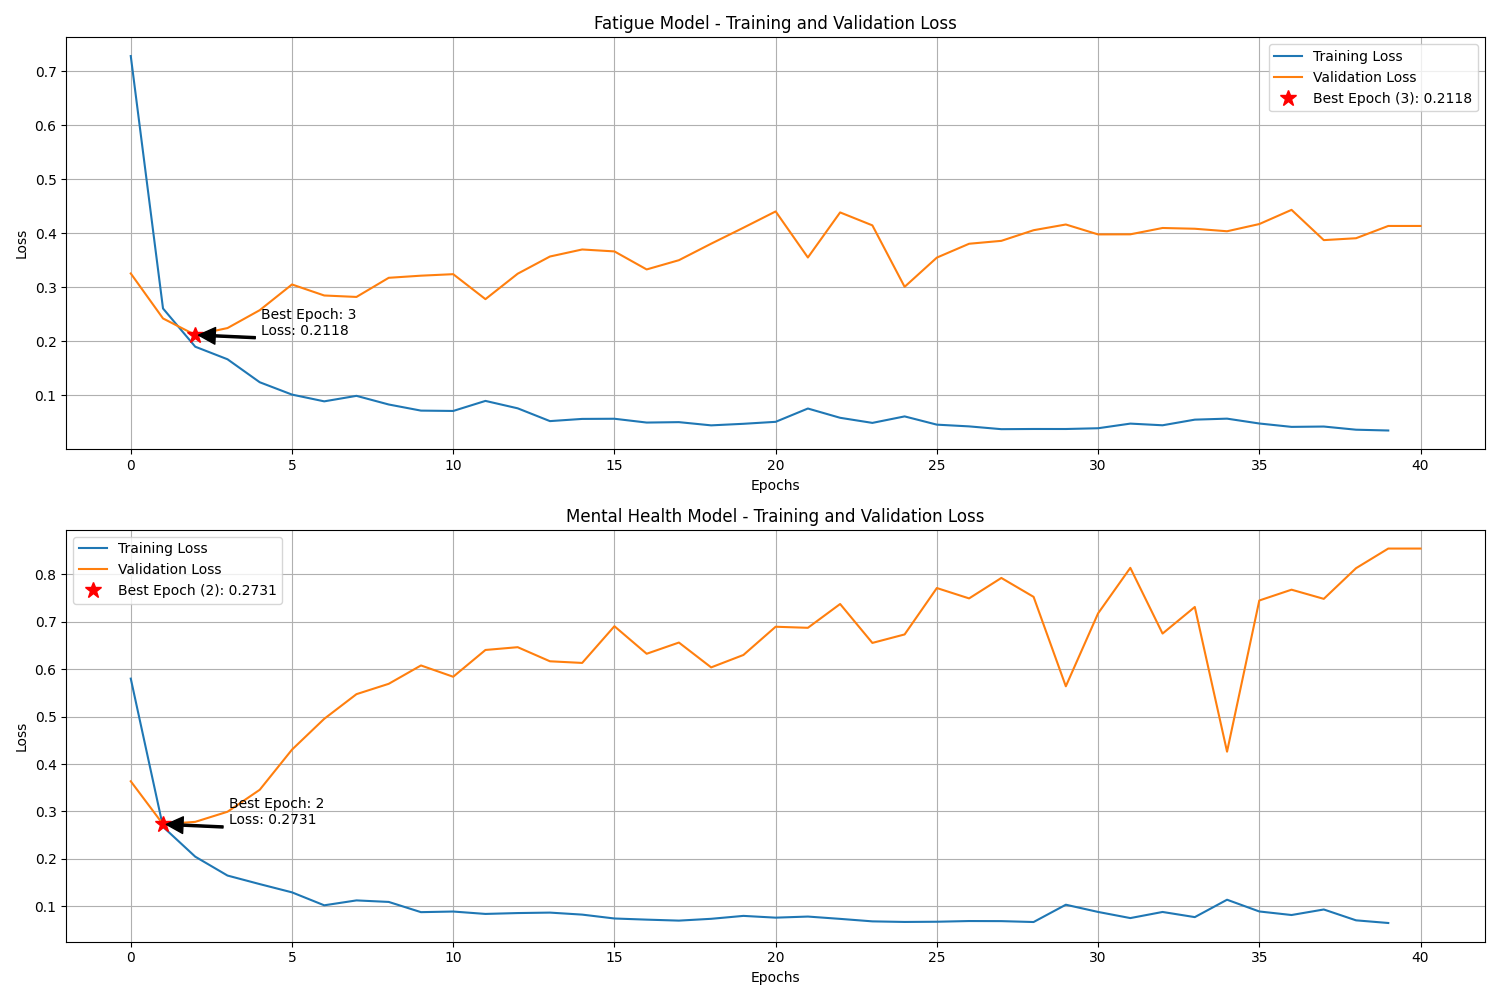

In [25]:
with open('images/qr_loss_curves_with_best_epoch.png', 'rb') as image_file:
    qr_loss_curves_with_best_epoch = image_file.read()

display(Image(qr_loss_curves_with_best_epoch))

In [ ]:
# Using AI to interpret the training loss curves
from google.genai import types

with open('images/qr_loss_curves_with_best_epoch.png', 'rb') as image_file:
    questionnaire_responses_mood_word_cloud = image_file.read()

# prompt powered by gemini 2.5 flash 0520
prompt = """
You are an experienced Machine Learning Engineer with expertise in deep learning model training dynamics and evaluation. You have been provided with plots showing the training and validation loss curves for two multi-class classification models: 'Fatigue Risk' and 'Mental Health Risk'. Both models were trained using a BERT-based approach on questionnaire responses.
Comprehensive Context (from previous analyses):
Model Type: BERT-based classification models.
Input Data: Questionnaire responses.
Dataset Size: Approximately 1000 data points were used for training and evaluation.
Classes: 'Low Risk', 'Moderate Risk', 'High Risk' (multi-class problem).
Previous Performance Metrics:
Fatigue Model: Higher overall performance (e.g., Accuracy ~0.929, AUC ~0.933).
Mental Health Model: Slightly lower overall performance (e.g., Accuracy ~0.884, AUC ~0.871).
Confusion Matrices/ROC Curves: Insights into per-class performance (e.g., 'Moderate Risk' was challenging) and discriminative power.
Loss Curve Data:
1. Fatigue Model - Training and Validation Loss:
Training Loss: Decreases rapidly initially, then continues to decrease steadily, becoming quite low.
Validation Loss: Decreases initially, reaches a minimum around Epoch 3 (Loss: 0.2118), and then starts to fluctuate and generally increase or stay relatively high compared to training loss.
Epochs Trained: Appears to be trained for 40 epochs.
2. Mental Health Model - Training and Validation Loss:
Training Loss: Decreases rapidly initially, then continues to decrease steadily, becoming very low.
Validation Loss: Decreases initially, reaches a minimum around Epoch 2 (Loss: 0.2731), and then consistently increases and fluctuates significantly at higher values.
Epochs Trained: Appears to be trained for 40 epochs.
Your Task:
Analyze these training and validation loss curves. Provide a detailed evaluation and interpretation suitable for a technical report, focusing on convergence, generalization, overfitting, and how these observations relate to the previously observed performance metrics and the inherent limitations of the training setup.
Please structure your response with the following sections:
Convergence and Overfitting Analysis for Each Model:
For both the Fatigue and Mental Health models:
Describe the behavior of the Training Loss curve (e.g., rapid initial decrease, plateau). What does this indicate about the model's learning on the training data?
Describe the behavior of the Validation Loss curve (e.g., initial decrease, minimum point, subsequent increase or fluctuation). What does this indicate about the model's generalization ability?
Identify the presence and severity of overfitting for each model. When does overfitting appear to begin (approximate epoch)?
Explain the significance of the "Best Epoch" marked on each plot. How does it relate to the early stopping strategy?
Comparative Analysis of Training Dynamics:
Compare the training dynamics (convergence speed, final training loss) between the Fatigue and Mental Health models.
Compare their generalization abilities as inferred from their validation loss curves. Which model appears to generalize better or shows less severe overfitting?
Relate these observations on loss curves back to the aggregate performance metrics (Accuracy, AUC, etc.) discussed previously. Do the loss curve patterns explain why one model performed better than the other on evaluation metrics?
Key Insights and Interpretations for Report Writing:
What are the most crucial findings from these loss plots regarding the model's training process?
What are the implications of the observed overfitting patterns for the practical deployment of these models?
Discuss the importance of effective early stopping based on these graphs.
Limitations of the Current Training Process:
Dataset Size (1000 data points): How might the small dataset contribute to the observed volatility or "noisiness" in the validation loss curves? Does it make the 'best epoch' determination less stable?
Training Duration: Discuss whether training for 40 epochs was excessive given the early onset of overfitting for both models.
Lack of Test Set Loss: Highlight that these plots only show training and validation loss. What is the implication of not having a separate, unseen test set loss curve to confirm generalization?
Hyperparameter Tuning: Inferred from the plots, what challenges might there have been in hyperparameter tuning (e.g., learning rate, batch size) that could contribute to the loss curve shapes?
Suggestions for Further Research and Model Improvement:
Propose concrete strategies to address the observed overfitting and improve generalization for both models (e.g., more aggressive regularization techniques like increased dropout, weight decay).
Suggest methods for more robust early stopping criteria or validation procedures (e.g., k-fold cross-validation to get more stable validation loss estimates).
Recommendations for dataset augmentation or collecting more data to smooth out validation loss fluctuations.
Suggest experimentation with different learning rates or optimizers to achieve better convergence and lower validation loss.
Consider exploring different model architectures or fine-tuning strategies specific to BERT to optimize for generalization rather than just training set performance.
Ensure your language is clear, concise, and professional, suitable for a technical report audience
"""

response = client.models.generate_content(
    model=model[0], 
    contents=[
        types.Part.from_bytes(
            data=questionnaire_responses_mood_word_cloud,
            mime_type='image/png',
        ),
        prompt
    ]
)

display(Markdown(response.text))

Okay, here is a detailed analysis of the provided training and validation loss curves for the Fatigue and Mental Health models, suitable for a technical report.

---

**Analysis of Training and Validation Loss Curves: Fatigue and Mental Health Risk Models**

This analysis examines the training and validation loss curves for two BERT-based multi-class classification models, one for Fatigue Risk and one for Mental Health Risk, trained on questionnaire responses. The models predict 'Low Risk', 'Moderate Risk', and 'High Risk'. We previously observed that the Fatigue model achieved higher aggregate performance metrics (Accuracy ~0.929, AUC ~0.933) compared to the Mental Health model (Accuracy ~0.884, AUC ~0.871), and noted challenges with the 'Moderate Risk' class for both. These loss curves provide crucial insights into the training dynamics and generalization capabilities of each model.

**1. Convergence and Overfitting Analysis for Each Model:**

**1.1. Fatigue Model - Training and Validation Loss**

*   **Training Loss Behavior:** The training loss curve shows a rapid decrease in the initial epochs (from ~0.7 to below 0.3), followed by a more gradual but steady decline throughout the remaining 40 epochs. By the end of training, the training loss is very low (~0.05). This indicates that the model is effectively learning the training data, reducing the error signal significantly over time and fitting the training examples well.
*   **Validation Loss Behavior:** The validation loss curve also decreases initially, aligning closely with the training loss. It reaches a minimum value of **0.2118 at Epoch 3**. After this point, the validation loss starts to fluctuate and generally increases compared to the minimum, staying significantly higher than the training loss from Epoch 4 onwards. This behavior indicates that while the model learns to predict the training data well, its ability to generalize to unseen validation data plateaus and then degrades after a certain point.
*   **Overfitting:** Overfitting is clearly present in the Fatigue model. It appears to begin shortly after **Epoch 3**, where the validation loss starts to diverge from the training loss and shows an upward trend (or significant fluctuations above the minimum). The gap between the training loss and validation loss widens considerably as training progresses beyond Epoch 3, which is a hallmark of overfitting.
*   **Significance of "Best Epoch":** The "Best Epoch: 3, Loss: 0.2118" annotation highlights the point in training where the model achieved the lowest loss on the validation dataset during this specific training run. This epoch is crucial for an early stopping strategy. Instead of training for the full 40 epochs, the model weights from Epoch 3 would be saved and used as the final model because they represent the best generalization performance observed on the validation set. Training further would likely result in a model that performs worse on new, unseen data due to overfitting.

**1.2. Mental Health Model - Training and Validation Loss**

*   **Training Loss Behavior:** Similar to the Fatigue model, the training loss for the Mental Health model decreases very rapidly initially (from ~0.6 to below 0.2), and then continues to decline steadily to a very low value (~0.03) by Epoch 40. This again indicates strong learning capability on the training data, fitting it aggressively.
*   **Validation Loss Behavior:** The validation loss curve also decreases initially, reaching a minimum value of **0.2731 at Epoch 2**. Crucially, after Epoch 2, the validation loss increases sharply and consistently for several epochs, and then continues to fluctuate at much higher levels (often between 0.5 and 0.7) than its minimum. This indicates that the model's generalization ability degrades very quickly after the initial learning phase. The high volatility in validation loss suggests instability in the learning process on unseen data after overfitting begins.
*   **Overfitting:** Overfitting is clearly present and appears to be **more severe** and **earlier** for the Mental Health model compared to the Fatigue model. It starts immediately after **Epoch 2**. The significant and sustained increase in validation loss, coupled with the continued decrease in training loss, demonstrates a rapid loss of generalization.
*   **Significance of "Best Epoch":** The "Best Epoch: 2, Loss: 0.2731" indicates the training point where the validation loss was lowest. For the Mental Health model, early stopping at Epoch 2 is even more critical than for the Fatigue model, as the validation loss deteriorates rapidly thereafter. Using the model weights from Epoch 2 would maximize the chances of achieving the best possible performance on unseen data based on this validation set.

**2. Comparative Analysis of Training Dynamics:**

*   **Training Dynamics:** Both models exhibit typical BERT fine-tuning behavior: a very rapid initial drop in training loss followed by a slower decrease. Both models effectively converge to very low training loss values, suggesting they have sufficient capacity to fit the training data. The speed and final levels of training loss are comparable, with the Mental Health model perhaps reaching a slightly lower minimum training loss, indicating it might be fitting the training data slightly more aggressively.
*   **Generalization Abilities:** The Fatigue model demonstrates better generalization than the Mental Health model, as inferred from the validation loss curves. The Fatigue model's minimum validation loss (0.2118 at Epoch 3) is lower than the Mental Health model's minimum (0.2731 at Epoch 2). More significantly, the increase in validation loss after the minimum is less severe and more gradual for the Fatigue model compared to the sharp and sustained increase observed for the Mental Health model. The high volatility in the Mental Health model's validation loss also suggests less stable generalization.
*   **Relation to Performance Metrics:** The observed differences in generalization strongly align with the previously noted differences in aggregate performance metrics. The Fatigue model's better generalization (lower minimum validation loss, less severe overfitting) directly correlates with its higher reported Accuracy (~0.929 vs ~0.884) and AUC (~0.933 vs ~0.871). The more pronounced overfitting and higher minimum validation loss of the Mental Health model explain its comparatively lower performance on unseen data. The rapid onset and severity of overfitting likely hinder the Mental Health model's ability to perform consistently on new examples, including correctly classifying challenging classes like 'Moderate Risk'.

**3. Key Insights and Interpretations for Report Writing:**

*   **Crucial Findings:** The most important findings are the rapid onset of overfitting for both models (Epoch 3 for Fatigue, Epoch 2 for Mental Health) and the significant divergence between training and validation loss thereafter. Both models learn the training data effectively, but their ability to generalize quickly diminishes.
*   **Implications for Deployment:** The observed overfitting means that deploying the models trained for the full 40 epochs would likely result in sub-optimal performance on real-world, unseen data. Performance would likely be closer to the fluctuating high points of the validation loss curves, significantly worse than the performance at the "best epoch".
*   **Importance of Early Stopping:** These graphs vividly demonstrate the critical importance of using an effective early stopping mechanism. Saving the model weights at the point of minimum validation loss (Epoch 3 for Fatigue, Epoch 2 for Mental Health) is essential to achieve the best possible generalization performance. Training beyond these points is detrimental.

**4. Limitations of the Current Training Process:**

*   **Dataset Size (1000 data points):** A dataset of ~1000 points is relatively small, especially for fine-tuning a large model like BERT. This small size likely contributes significantly to the observed volatility and "noisiness" in the validation loss curves. A small validation set means that the validation loss calculated in each epoch is based on a limited sample of unseen data, making it less stable and less representative of true generalization across the entire data distribution. This makes the determination of the 'best epoch' more sensitive to the specific examples in the validation set for that particular run, potentially making it less stable or reliable across different data splits.
*   **Training Duration:** Training for 40 epochs was clearly excessive for both models given the early onset of overfitting (Epochs 2-3). The plots show that almost 90% of the training epochs occurred well into the overfitting phase, providing no benefit and potentially harming generalization.
*   **Lack of Test Set Loss:** The plots show only training and validation loss. The validation set is used for monitoring performance during training and selecting the best epoch (early stopping) or tuning hyperparameters. Therefore, the performance on the validation set (even at the "best epoch") might be an optimistic estimate of performance on truly *unseen* data. A separate, independent test set is necessary to provide an unbiased evaluation of the model's final generalization capability after the model and its optimal epoch have been selected using the training and validation sets.
*   **Hyperparameter Tuning:** While not directly shown, the aggressive fitting of training data (low training loss) and rapid overfitting suggest that hyperparameters like the learning rate might be too high, or regularization (like dropout) might be insufficient for this dataset size. The volatility in validation loss, particularly for the Mental Health model, could also hint at a learning rate that is too high or unstable training.

**5. Suggestions for Further Research and Model Improvement:**

Based on this analysis, several strategies can be pursued to improve the models:

*   **Address Overfitting:**
    *   **Increased Regularization:** Experiment with increasing the dropout rate, especially in the final classification layers of the BERT model. Consider adding weight decay (L2 regularization) to the optimizer.
    *   **Data Augmentation:** Explore text data augmentation techniques relevant to questionnaire responses (e.g., synonym replacement, paraphrasing) to artificially increase the training dataset size and introduce more variability, making the model more robust.
*   **More Robust Validation and Early Stopping:**
    *   **K-Fold Cross-Validation:** Implement k-fold cross-validation (e.g., 5-fold) during training. This provides more stable estimates of validation loss by averaging performance across different validation folds. The "best epoch" can be determined more reliably based on the average validation loss across folds, leading to a more robust final model selection.
    *   **Early Stopping Patience:** Implement an early stopping criterion with patience. Instead of stopping exactly at the minimum, wait for validation loss to not improve for a few consecutive epochs (e.g., 5-10 epochs). This can help avoid stopping prematurely due to random fluctuations in validation loss.
*   **Dataset Expansion:** The most impactful improvement would be to collect significantly more labeled data. A larger dataset would provide more examples for the model to learn from, reduce the noise in validation loss estimates, and potentially mitigate the severity of overfitting.
*   **Hyperparameter Tuning:** Conduct a more systematic hyperparameter search, focusing on:
    *   **Learning Rate:** Experiment with lower learning rates and different learning rate schedules (e.g., warm-up, decay) to achieve smoother convergence and potentially lower validation loss.
    *   **Optimizer:** Evaluate different optimizers suitable for fine-tuning BERT (e.g., AdamW).
    *   **Batch Size:** Experiment with different batch sizes, which can impact optimization stability and generalization.
*   **Explore Different Model Architectures or Fine-tuning Strategies:**
    *   **Smaller Models:** Given the dataset size, a smaller pre-trained model or a different architecture might overfit less than a standard large BERT model.
    *   **BERT Fine-tuning Techniques:** Explore techniques specifically for fine-tuning BERT on smaller datasets, such as parameter-efficient fine-tuning (PEFT) methods (e.g., LoRA) or gradual unfreezing of layers.

By implementing these suggestions, particularly addressing the small dataset size and severe overfitting, we can expect to train models that generalize better to unseen data, leading to improved performance on evaluation metrics and more reliable predictions in practice. Using a separate test set will be essential for a final, unbiased performance evaluation.

---